Differential expression analysis of Bulk RNA-seq data of MEF cells


Date last updated: February 14,2024

Created by : Sayane Shome

The workflow for the DESEQ2 analysis has been adapted from the tutorial :
https://rstudio-pubs-static.s3.amazonaws.com/329027_593046fb6d7a427da6b2c538caf601e1.html#example-3-two-conditions-two-genotypes-with-an-interaction-term


"Here we have two genotypes, wild-type (wt) and mutant (mut). Two conditions: control (Control) and treated (LPS treated). We are interested in the responses of both wild-type and mutant to treatment. We are also interested in the differences in response between genotypes, which is captured by the interaction term in linear models."

The order of the samples has to be WT +/- LPS and then KO +/- LPS.

Update: Based on Lance's suggestion (Mar 21, 2024), entire images, data frame, the order should be WT -/+ LPS and KO -/+ LPS.

In [2]:
version #to make sure which R version and computer architecture the code was run

               _                           
platform       aarch64-apple-darwin20      
arch           aarch64                     
os             darwin20                    
system         aarch64, darwin20           
status                                     
major          4                           
minor          2.1                         
year           2022                        
month          06                          
day            23                          
svn rev        82513                       
language       R                           
version.string R version 4.2.1 (2022-06-23)
nickname       Funny-Looking Kid           

In [3]:
#loading packages

In [4]:
library(EnsDb.Mmusculus.v79)
library(DESeq2)
library(EnhancedVolcano)
library(tidyr)
library(ashr)
library(tidyverse)
library(knitr)
library(Glimma)
library(DESeq2)
library(pheatmap)
library(ggplot2)
library(dplyr)
library(plotly)
library(VennDiagram)
library(clusterProfiler)
library(enrichplot)
library(ggplot2)
library(ggridges)


Loading required package: ensembldb

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: S4Vectors

Warning message:
“package ‘S4Vectors’ was built under R version 4.2.2”

Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading

In [5]:
#loading count matrix from processed data. The count matrix contains the count values obtained from RSEM. 

s <- read.csv('../all_unnorm_counts_MEF_minus_het_arranged.csv')
colnames(s)[1] <- "Ensemble_ID"
s4 <- s
#reading metadata about the count matrix
coldata <- read.csv('MEF_counts/coldata_minus_het_mef2020counts_v1.csv',header = FALSE)
metadata <- coldata



Complete sets of LPS + Ctrl

P4_5_lps1,P4_5_lps2,P4_5_lps3,P7_4_lps1,P7_4_lps2,P8_4_lps3,P8_4_lps4,P8_4_lps5,P4_5_ctrl1,P4_5_ctrl2,P4_5_ctrl3,P7_4_ctrl1,P7_4_ctrl2,P8_4_ctrl3,P8_4_ctrl4,P8_4_ctrl5	

In [6]:
# Renaming the column names for the R dataframe.

In [7]:
colnames(s4)

[1] "Ensemble_ID" "Gene_name"   "P8_4_Lps3"   "P8_4_Lps5"   "P8_4_Lps4"  
 [6] "P7_4_Lps1"   "P7_4_Lps2"   "P4_5_Lps2"   "P4_5_Lps3"   "P4_5_Lps1"  
[11] "P7_4_Ctrl1"  "P7_4_Ctrl2"  "P8_4_Ctrl3"  "P8_4_Ctrl4"  "P8_4_Ctrl5" 
[16] "P4_5_Ctrl1"  "P4_5_Ctrl3"  "P4_5_Ctrl2"

In [8]:
metadata

V1    V2         V3  V4     
1  AMC11 P8_4_Lps3  wt  LPS    
2  AMC12 P8_4_Lps5  wt  LPS    
3  AMC21 P8_4_Lps4  wt  LPS    
4  AMC3  P7_4_Lps1  wt  LPS    
5  AMC4  P7_4_Lps2  wt  LPS    
6  AMC6  P4_5_Lps2  mut LPS    
7  AMC18 P4_5_Lps3  mut LPS    
8  AMC22 P4_5_Lps1  mut LPS    
9  AMC1  P7_4_Ctrl1 wt  Control
10 AMC2  P7_4_Ctrl2 wt  Control
11 AMC10 P8_4_Ctrl3 wt  Control
12 AMC19 P8_4_Ctrl4 wt  Control
13 AMC20 P8_4_Ctrl5 wt  Control
14 AMC5  P4_5_Ctrl1 mut Control
15 AMC26 P4_5_Ctrl3 mut Control
16 AMC13 P4_5_Ctrl2 mut Control

In [9]:
#Renaming the column names of metadata

In [10]:
colnames(metadata)[1] <- "sample"
colnames(metadata)[2] <- "id"
colnames(metadata)[3] <- "genotype"
colnames(metadata)[4] <- "condition"


In [11]:
#This is how metadata table looks like.
metadata

sample id         genotype condition
1  AMC11  P8_4_Lps3  wt       LPS      
2  AMC12  P8_4_Lps5  wt       LPS      
3  AMC21  P8_4_Lps4  wt       LPS      
4  AMC3   P7_4_Lps1  wt       LPS      
5  AMC4   P7_4_Lps2  wt       LPS      
6  AMC6   P4_5_Lps2  mut      LPS      
7  AMC18  P4_5_Lps3  mut      LPS      
8  AMC22  P4_5_Lps1  mut      LPS      
9  AMC1   P7_4_Ctrl1 wt       Control  
10 AMC2   P7_4_Ctrl2 wt       Control  
11 AMC10  P8_4_Ctrl3 wt       Control  
12 AMC19  P8_4_Ctrl4 wt       Control  
13 AMC20  P8_4_Ctrl5 wt       Control  
14 AMC5   P4_5_Ctrl1 mut      Control  
15 AMC26  P4_5_Ctrl3 mut      Control  
16 AMC13  P4_5_Ctrl2 mut      Control

In [12]:
# Filtering rows with zero counts in more than four columns/samples

In [13]:
zeros_count <- apply(s4 == 0, 1, sum)
filtered_df <- s4[zeros_count <= 4, ]
s4 <- filtered_df 
s4[,3:18] <- s4[,3:18]+1 
s4[,3:18] <- round(s4[,3:18])

In [14]:
countData <- s4     #assigning metadata and countdata
metaData <- metadata


In [15]:
#Formatted the countData dataframe and 

In [16]:
countData <- read.csv('all_unnorm_counts_MEF_minus_het_arranged_genenames_added_for_ensembleids_v1.csv')

In [17]:
rownames(countData) <- countData$Ensemble_ID
#countData$Ensemble_ID <- NULL

In [18]:
countData <- countData %>%
  mutate(Gene_name = ifelse(is.na(Gene_name) | Gene_name == "", Ensemble_ID, Gene_name))

In [19]:
# Assuming numeric columns 2 to n contain expression data
countData_resolved <- countData %>%
  group_by(Gene_name) %>%
  summarise(across(where(is.numeric), mean))

In [20]:
countData_resolved

Gene_name     P8_4_Lps3 P8_4_Lps5 P8_4_Lps4 P7_4_Lps1 P7_4_Lps2 P4_5_Lps2
1     0610005C13Rik    22        33       23        18        17        19     
2     0610007P14Rik  1218      1106      949       678       813       383     
3     0610009B22Rik   471       445      383       269       344       224     
4     0610009E02Rik    36        17       29        12        16        26     
5     0610009L18Rik    19        14       24         9        18        15     
6     0610009O20Rik  1005       944      788       525       645       338     
7     0610010F05Rik  1094      1061      884       642       835       388     
8     0610010K14Rik   416       351      335       220       267       192     
9     0610011F06Rik   300       223      219       139       158        95     
10    0610012G03Rik   104        90       89        51        44        18     
11    0610030E20Rik   812       710      594       406       528       317     
12    0610031J06Rik  7781      7190     6086      4316      5127      2995     
13    0610031O16Rik    21        19       14         7        15         5     
14    0610037L13Rik  1083       899      820       586       729       366     
15    0610039K10Rik     4         2        1         1         2         2     
16    0610040B10Rik    28        29       19        21        27        24     
17    0610040F04Rik     3         2        3         3         5         1     
18    0610040J01Rik     3         3        3         1         2         1     
19    0610043K17Rik     9         6       10         6         8         4     
20    1-Mar           109       125       91        60        80        11     
21    1-Sep            71        51       65        38        43        16     
22    10-Mar            6         1        4         2         2         3     
23    10-Sep          907       820      748       486       676       168     
24    1010001B22Rik     9         1        2         2         4         7     
25    1010001N08Rik    11         9        8        10        17         2     
26    11-Mar           10        13       15         8         6         9     
27    11-Sep        11088     10658     8611      6892      8870      2341     
28    1110001J03Rik    78        76       54        45        50        47     
29    1110002E22Rik    46        41       40        20        23         1     
30    1110002J07Rik    16        12        7        10        11         2     
⋮     ⋮             ⋮         ⋮         ⋮         ⋮         ⋮         ⋮        
20269 n-R5s100      36         1         3         3         2        6        
20270 n-R5s103      36         1         3         3         2        6        
20271 n-R5s104      36         1         3         3         2        6        
20272 n-R5s105      36         1         3         3         2        6        
20273 n-R5s106      25         2         2         1         2        3        
20274 n-R5s107      36         1         3         3         2        6        
20275 n-R5s108      36         1         3         3         2        6        
20276 n-R5s110      36         1         3         3         2        6        
20277 n-R5s111      36         1         3         3         2        6        
20278 n-R5s113      36         1         3         3         2        6        
20279 n-R5s117      36         1         3         3         2        6        
20280 n-R5s118      25         2         2         1         2        3        
20281 n-R5s121      36         1         3         3         2        6        
20282 n-R5s122      36         1         3         3         2        6        
20283 n-R5s123      36         1         3         3         2        6        
20284 n-R5s124      36         1         3         3         2        6        
20285 n-R5s128      36         1         3         3         2        6        
20286 n-R5s130      25         2         2         1         2        3        
20287 

In [21]:
countData1 <- as.data.frame(countData_resolved)
countData1[,2:17] <- round(countData1[,2:17])

In [22]:
countData1

Gene_name     P8_4_Lps3 P8_4_Lps5 P8_4_Lps4 P7_4_Lps1 P7_4_Lps2 P4_5_Lps2
1     0610005C13Rik    22        33       23        18        17        19     
2     0610007P14Rik  1218      1106      949       678       813       383     
3     0610009B22Rik   471       445      383       269       344       224     
4     0610009E02Rik    36        17       29        12        16        26     
5     0610009L18Rik    19        14       24         9        18        15     
6     0610009O20Rik  1005       944      788       525       645       338     
7     0610010F05Rik  1094      1061      884       642       835       388     
8     0610010K14Rik   416       351      335       220       267       192     
9     0610011F06Rik   300       223      219       139       158        95     
10    0610012G03Rik   104        90       89        51        44        18     
11    0610030E20Rik   812       710      594       406       528       317     
12    0610031J06Rik  7781      7190     6086      4316      5127      2995     
13    0610031O16Rik    21        19       14         7        15         5     
14    0610037L13Rik  1083       899      820       586       729       366     
15    0610039K10Rik     4         2        1         1         2         2     
16    0610040B10Rik    28        29       19        21        27        24     
17    0610040F04Rik     3         2        3         3         5         1     
18    0610040J01Rik     3         3        3         1         2         1     
19    0610043K17Rik     9         6       10         6         8         4     
20    1-Mar           109       125       91        60        80        11     
21    1-Sep            71        51       65        38        43        16     
22    10-Mar            6         1        4         2         2         3     
23    10-Sep          907       820      748       486       676       168     
24    1010001B22Rik     9         1        2         2         4         7     
25    1010001N08Rik    11         9        8        10        17         2     
26    11-Mar           10        13       15         8         6         9     
27    11-Sep        11088     10658     8611      6892      8870      2341     
28    1110001J03Rik    78        76       54        45        50        47     
29    1110002E22Rik    46        41       40        20        23         1     
30    1110002J07Rik    16        12        7        10        11         2     
⋮     ⋮             ⋮         ⋮         ⋮         ⋮         ⋮         ⋮        
20269 n-R5s100      36         1         3         3         2        6        
20270 n-R5s103      36         1         3         3         2        6        
20271 n-R5s104      36         1         3         3         2        6        
20272 n-R5s105      36         1         3         3         2        6        
20273 n-R5s106      25         2         2         1         2        3        
20274 n-R5s107      36         1         3         3         2        6        
20275 n-R5s108      36         1         3         3         2        6        
20276 n-R5s110      36         1         3         3         2        6        
20277 n-R5s111      36         1         3         3         2        6        
20278 n-R5s113      36         1         3         3         2        6        
20279 n-R5s117      36         1         3         3         2        6        
20280 n-R5s118      25         2         2         1         2        3        
20281 n-R5s121      36         1         3         3         2        6        
20282 n-R5s122      36         1         3         3         2        6        
20283 n-R5s123      36         1         3         3         2        6        
20284 n-R5s124      36         1         3         3         2        6        
20285 n-R5s128      36         1         3         3         2        6        
20286 n-R5s130      25         2         2         1         2        3        
20287 

In [23]:
new_order <- c(9,10,11,12,13,1,2,3,4,5,14,15,16,6,7,8)

# Step 3: Rearrange the dataframe by the specified row indices
metadata <- metadata[new_order, ]
metadata

sample id         genotype condition
9  AMC1   P7_4_Ctrl1 wt       Control  
10 AMC2   P7_4_Ctrl2 wt       Control  
11 AMC10  P8_4_Ctrl3 wt       Control  
12 AMC19  P8_4_Ctrl4 wt       Control  
13 AMC20  P8_4_Ctrl5 wt       Control  
1  AMC11  P8_4_Lps3  wt       LPS      
2  AMC12  P8_4_Lps5  wt       LPS      
3  AMC21  P8_4_Lps4  wt       LPS      
4  AMC3   P7_4_Lps1  wt       LPS      
5  AMC4   P7_4_Lps2  wt       LPS      
14 AMC5   P4_5_Ctrl1 mut      Control  
15 AMC26  P4_5_Ctrl3 mut      Control  
16 AMC13  P4_5_Ctrl2 mut      Control  
6  AMC6   P4_5_Lps2  mut      LPS      
7  AMC18  P4_5_Lps3  mut      LPS      
8  AMC22  P4_5_Lps1  mut      LPS

In [24]:
write.csv(countData1$Gene_name,'Gene_MEF.csv')

In [25]:
countData1$Gene_name

[1] "0610005C13Rik"      "0610007P14Rik"      "0610009B22Rik"     
    [4] "0610009E02Rik"      "0610009L18Rik"      "0610009O20Rik"     
    [7] "0610010F05Rik"      "0610010K14Rik"      "0610011F06Rik"     
   [10] "0610012G03Rik"      "0610030E20Rik"      "0610031J06Rik"     
   [13] "0610031O16Rik"      "0610037L13Rik"      "0610039K10Rik"     
   [16] "0610040B10Rik"      "0610040F04Rik"      "0610040J01Rik"     
   [19] "0610043K17Rik"      "1-Mar"              "1-Sep"             
   [22] "10-Mar"             "10-Sep"             "1010001B22Rik"     
   [25] "1010001N08Rik"      "11-Mar"             "11-Sep"            
   [28] "1110001J03Rik"      "1110002E22Rik"      "1110002J07Rik"     
   [31] "1110002L01Rik"      "1110004E09Rik"      "1110004F10Rik"     
   [34] "1110007C09Rik"      "1110008F13Rik"      "1110008L16Rik"     
   [37] "1110008P14Rik"      "1110012L19Rik"      "1110017D15Rik"     
   [40] "1110018N20Rik"      "1110019D14Rik"      "1110020A21Rik"     
   [43] "1110032A03Rik"      "1110034G24Rik"      "1110035H17Rik"     
   [46] "1110037F02Rik"      "1110038B12Rik"      "1110038F14Rik"     
   [49] "1110046J04Rik"      "1110051M20Rik"      "1110054M08Rik"     
   [52] "1110057K04Rik"      "1110058L19Rik"      "1110059E24Rik"     
   [55] "1110059G10Rik"      "1110065P20Rik"      "1190002N15Rik"     
   [58] "1190005I06Rik"      "1190007I07Rik"      "1200007C13Rik"     
   [61] "1200014J11Rik"      "1300002E11Rik"      "1300017J02Rik"     
   [64] "15-Sep"             "1500002C15Rik"      "1500004A13Rik"     
   [67] "1500009L16Rik"      "1500011B03Rik"      "1500011K16Rik"     
   [70] "1500012F01Rik"      "1500012K07Rik"      "1500015A07Rik"     
   [73] "1500015L24Rik"      "1500015O10Rik"      "1500017E21Rik"     
   [76] "1500026H17Rik"      "1520401A03Rik"      "1600002H07Rik"     
   [79] "1600002K03Rik"      "1600010F14Rik"      "1600012H06Rik"     
   [82] "1600014C10Rik"      "1600020E01Rik"      "1600025M17Rik"     
   [85] "1600029O15Rik"      "1700001C19Rik"      "1700001G11Rik"     
   [88] "1700001G17Rik"      "1700001K19Rik"      "1700001L05Rik"     
   [91] "1700001O22Rik"      "1700003E16Rik"      "1700003F12Rik"     
   [94] "1700003M02Rik"      "1700003M07Rik"      "1700006J14Rik"     
   [97] "1700007J10Rik"      "1700007K09Rik"      "1700007K13Rik"     
  [100] "1700007L15Rik"      "1700007M16Rik"      "1700007P06Rik"     
  [103] "1700008F21Rik"      "1700008I05Rik"      "1700008O03Rik"     
  [106] "1700009N14Rik"      "1700009P17Rik"      "1700010I14Rik"     
  [109] "1700010K23Rik"      "1700012B09Rik"      "1700013F07Rik"     
  [112] "1700014D04Rik"      "1700016D06Rik"      "1700016H13Rik"     
  [115] "1700017B05Rik"      "1700018A04Rik"      "1700019B03Rik"     
  [118] "1700019D03Rik"      "1700019G17Rik"      "1700019L03Rik"     
  [121] "1700020A23Rik"      "1700020I14Rik"      "1700020L24Rik"     
  [124] "1700021F05Rik"      "1700021J08Rik"      "1700021K19Rik"     
  [127] "1700022I11Rik"      "1700022N22Rik"      "1700023F06Rik"     
  [130] "1700023H06Rik"      "1700023L04Rik"      "1700024J04Rik"     
  [133] "1700024P16Rik"      "1700025G04Rik"      "1700026D08Rik"     
  [136] "1700026L06Rik"      "1700027A07Rik"      "1700028E10Rik"     
  [139] "1700028I16Rik"      "1700028J19Rik"      "1700028K03Rik"     
  [142] "1700028P15Rik"      "1700029F12Rik"      "1700029I15Rik"     
  [145] "1700029J07Rik"      "1700030C10Rik"      "1700030C14Rik"     
  [148] "1700030J22Rik"      "1700030K09Rik"      "1700030M09Rik"     
  [151] "1700034H15Rik"      "1700034J05Rik"      "1700034P13Rik"     
  [154] "1700037C18Rik"      "1700037H04Rik"      "1700040L02Rik"     
  [157] "1700041G16Rik"      "1700042O10Rik"      "1700047A11Rik"     
  [160] "1700047I17Rik2"     "1700047K16Rik"      "1700048M11Rik"     
  [163] "1700048O20Rik"      "1700049E17Rik2"     "1700049G17Rik"     
  [166] "1700051A21Rik"      "1700052N19Rik"      "1700055D18Rik"     
  [169] "1700056E22Rik"     

In [26]:
new_order1 <- c(1,10,11,12,13,14,2,3,4,5,6,15,16,17,7,8,9)
countData1 <- countData1[,new_order1]
countData1

Gene_name     P7_4_Ctrl1 P7_4_Ctrl2 P8_4_Ctrl3 P8_4_Ctrl4 P8_4_Ctrl5
1     0610005C13Rik   22          50         47         65         36     
2     0610007P14Rik  776        1632       1519       2159       1426     
3     0610009B22Rik  356         725        672        999        592     
4     0610009E02Rik   18          43         32         48         45     
5     0610009L18Rik   20          49         32         46         30     
6     0610009O20Rik  613        1273       1286       1920       1162     
7     0610010F05Rik  699        1481       1372       1951       1222     
8     0610010K14Rik  258         484        525        787        434     
9     0610011F06Rik  178         355        382        515        336     
10    0610012G03Rik   50         108        162        331        127     
11    0610030E20Rik  455         972        955       1295        850     
12    0610031J06Rik 4888       10227      10239      14239       8706     
13    0610031O16Rik    5          12         16         22         25     
14    0610037L13Rik  627        1368       1262       1651       1107     
15    0610039K10Rik    3           2          3          3          4     
16    0610040B10Rik   35          42         47         59         39     
17    0610040F04Rik    2           7          2          6          3     
18    0610040J01Rik    3          10          7         11          9     
19    0610043K17Rik    5           6          4          8          4     
20    1-Mar          137         294        279        373        267     
21    1-Sep           44         100        141        193        101     
22    10-Mar           8           8         11         10          8     
23    10-Sep         545        1224        983       1400        918     
24    1010001B22Rik    4          16         11         12         12     
25    1010001N08Rik    4          13         14          9         12     
26    11-Mar           2           3          5         16         12     
27    11-Sep        7376       16158      13002      17706      11338     
28    1110001J03Rik   43         105         96        154         83     
29    1110002E22Rik    9          14         19         16         15     
30    1110002J07Rik    7          18         17         32         16     
⋮     ⋮             ⋮          ⋮          ⋮          ⋮          ⋮         
20269 n-R5s100      2           2         11          2         1         
20270 n-R5s103      2           2         11          2         1         
20271 n-R5s104      2           2         11          2         1         
20272 n-R5s105      2           2         11          2         1         
20273 n-R5s106      2           2          5          2         2         
20274 n-R5s107      2           2         11          2         1         
20275 n-R5s108      2           2         11          2         1         
20276 n-R5s110      2           2         11          2         1         
20277 n-R5s111      2           2         11          2         1         
20278 n-R5s113      2           2         11          2         1         
20279 n-R5s117      2           2         11          2         1         
20280 n-R5s118      2           2          5          2         2         
20281 n-R5s121      2           2         11          2         1         
20282 n-R5s122      2           2         11          2         1         
20283 n-R5s123      2           2         11          2         1         
20284 n-R5s124      2           2         11          2         1         
20285 n-R5s128      2           2         11          2         1         
20286 n-R5s130      2           2          5          2         2         
20287 n-R5s133      2           2         11          2         1         
20288 n-R5s134      2           2         11          2         1         
20289 n-R5s138      2           2         11          2         1         
20290 n-R5s139      2          

In [27]:
metadata

sample id         genotype condition
9  AMC1   P7_4_Ctrl1 wt       Control  
10 AMC2   P7_4_Ctrl2 wt       Control  
11 AMC10  P8_4_Ctrl3 wt       Control  
12 AMC19  P8_4_Ctrl4 wt       Control  
13 AMC20  P8_4_Ctrl5 wt       Control  
1  AMC11  P8_4_Lps3  wt       LPS      
2  AMC12  P8_4_Lps5  wt       LPS      
3  AMC21  P8_4_Lps4  wt       LPS      
4  AMC3   P7_4_Lps1  wt       LPS      
5  AMC4   P7_4_Lps2  wt       LPS      
14 AMC5   P4_5_Ctrl1 mut      Control  
15 AMC26  P4_5_Ctrl3 mut      Control  
16 AMC13  P4_5_Ctrl2 mut      Control  
6  AMC6   P4_5_Lps2  mut      LPS      
7  AMC18  P4_5_Lps3  mut      LPS      
8  AMC22  P4_5_Lps1  mut      LPS

In [28]:
library(DESeq2)
library(tibble) # For tidy data handling

# Assuming 'metadata' is your metadata DataFrame and 'countData1' is your count matrix
# First, make sure 'countData1' has the correct row names (genes) and column names (samples)
rownames(countData1) <- countData1$Gene_name
countData1 <- countData1[, -1] # Remove the 'Gene_name' column

# Make sure the 'metadata' DataFrame is correctly ordered to match the samples in 'countData1'
# The order should match exactly with the column names of 'countData1'
metadata_ordered <- metadata[match(colnames(countData1), metadata$id), ]

# Create a DESeqDataSet
# Assuming 'metadata_ordered' now has the columns in the correct order: 'sample', 'id', 'genotype', 'condition'
# The 'design' formula you have can stay the same
dds <- DESeqDataSetFromMatrix(countData = countData1,
                              colData = DataFrame(metadata_ordered),
                              design = ~ genotype + condition + genotype:condition)

# At this point, 'dds' should have 'genotype' and 'condition' correctly aligned
# You can proceed with your DESeq2 analysis workflow


converting counts to integer mode

Warning message in DESeqDataSet(se, design = design, ignoreRank):
"some variables in design formula are characters, converting to factors"


In [29]:
#Setting reference as Control and wildtype(wt) respectively.

In [30]:
#dds$condition <- factor(dds$condition, levels = c("LPS","Control"))
#dds$genotype <- factor(dds$genotype, levels = c("wt","mut"))

dds$condition <- relevel(dds$condition, ref = "Control")
dds$genotype <- relevel(dds$genotype, ref = "wt")

In [31]:
dds$genotype
dds$condition

[1] wt  wt  wt  wt  wt  wt  wt  wt  wt  wt  mut mut mut mut mut mut
Levels: wt mut

[1] Control Control Control Control Control LPS     LPS     LPS     LPS    
[10] LPS     Control Control Control LPS     LPS     LPS    
Levels: Control LPS

In [32]:
colData(dds)

DataFrame with 16 rows and 4 columns
                sample          id genotype condition
           <character> <character> <factor>  <factor>
P7_4_Ctrl1        AMC1  P7_4_Ctrl1       wt   Control
P7_4_Ctrl2        AMC2  P7_4_Ctrl2       wt   Control
P8_4_Ctrl3       AMC10  P8_4_Ctrl3       wt   Control
P8_4_Ctrl4       AMC19  P8_4_Ctrl4       wt   Control
P8_4_Ctrl5       AMC20  P8_4_Ctrl5       wt   Control
...                ...         ...      ...       ...
P4_5_Ctrl3       AMC26  P4_5_Ctrl3      mut   Control
P4_5_Ctrl2       AMC13  P4_5_Ctrl2      mut   Control
P4_5_Lps2         AMC6   P4_5_Lps2      mut   LPS    
P4_5_Lps3        AMC18   P4_5_Lps3      mut   LPS    
P4_5_Lps1        AMC22   P4_5_Lps1      mut   LPS    

In [33]:
#running DESEq to obtain the DE results

In [34]:
#design(dds) <- ~ genotype + condition + genotype:condition
dds <- DESeq(dds) 
resultsNames(dds)

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



[1] "Intercept"                "genotype_mut_vs_wt"      
[3] "condition_LPS_vs_Control" "genotypemut.conditionLPS"

In [35]:
#Next part of code shows the results of how many DE genes shows up.

In [36]:
normalized_counts <- counts(dds, normalized=TRUE)
write.csv(normalized_counts,"MEF_Deseq2_2020countsdata_normalized_chk.csv")

In [37]:
normalized_counts

P7_4_Ctrl1  P7_4_Ctrl2  P8_4_Ctrl3  P8_4_Ctrl4  P8_4_Ctrl5 
0610005C13Rik   27.844568   30.293965   28.922857   29.406584   25.276999
0610007P14Rik  982.153861  988.795019  934.762114  976.750989 1001.250003
0610009B22Rik  450.575740  439.262493  413.535313  451.956572  415.666201
0610009E02Rik   22.781919   26.052810   19.692158   21.715631   31.596248
0610009L18Rik   25.313244   29.688086   19.692158   20.810813   21.064166
0610009O20Rik  775.850924  771.284350  791.378590  868.625243  815.885346
0610010F05Rik  884.697872  897.307244  844.301264  882.649921  858.013677
0610010K14Rik  326.540846  293.245581  323.074463  356.045868  304.728262
0610011F06Rik  225.287870  215.087152  235.075133  232.990625  235.918654
0610012G03Rik   63.283110   65.434964   99.691549  149.747373   89.171634
0610030E20Rik  575.876297  588.914680  587.687834  585.869630  596.818024
0610031J06Rik 6186.556794 6196.327607 6300.875107 6441.851477 6112.820847
0610031O16Rik    6.328311    7.270552    9.846079    9.952998   17.553471
0610037L13Rik  793.570194  828.842883  776.609472  746.927227  777.267709
0610039K10Rik    3.796987    1.211759    1.846140    1.357227    2.808555
0610040B10Rik   44.298177   25.446931   28.922857   26.692130   27.383415
0610040F04Rik    2.531324    4.241155    1.230760    2.714454    2.106417
0610040J01Rik    3.796987    6.058793    4.307660    4.976499    6.319250
0610043K17Rik    6.328311    3.635276    2.461520    3.619272    2.808555
1-Mar          173.395720  178.128514  171.691001  168.748550  187.471074
1-Sep           55.689136   60.587930   86.768570   87.314933   70.916024
10-Mar          10.125298    4.847034    6.769179    4.524090    5.617111
10-Sep         689.785895  741.596264  604.918472  633.372573  644.563466
1010001B22Rik    5.062649    9.694069    6.769179    5.428908    8.425666
1010001N08Rik    5.062649    7.876431    8.615319    4.071681    8.425666
11-Mar           2.531324    1.817638    3.076900    7.238544    8.425666
11-Sep        9335.524328 9789.797739 8001.169855 8010.353413 7960.850306
1110001J03Rik   54.423474   63.617327   59.076473   69.670983   58.277525
1110002E22Rik   11.390960    8.482310   11.692219    7.238544   10.532083
1110002J07Rik    8.859635   10.905827   10.461459   14.477087   11.234222
⋮             ⋮           ⋮           ⋮           ⋮           ⋮          
n-R5s100      2.531324    1.211759    6.769179    0.904818    0.7021389  
n-R5s103      2.531324    1.211759    6.769179    0.904818    0.7021389  
n-R5s104      2.531324    1.211759    6.769179    0.904818    0.7021389  
n-R5s105      2.531324    1.211759    6.769179    0.904818    0.7021389  
n-R5s106      2.531324    1.211759    3.076900    0.904818    1.4042777  
n-R5s107      2.531324    1.211759    6.769179    0.904818    0.7021389  
n-R5s108      2.531324    1.211759    6.769179    0.904818    0.7021389  
n-R5s110      2.531324    1.211759    6.769179    0.904818    0.7021389  
n-R5s111      2.531324    1.211759    6.769179    0.904818    0.7021389  
n-R5s113      2.531324    1.211759    6.769179    0.904818    0.7021389  
n-R5s117      2.531324    1.211759    6.769179    0.904818    0.7021389  
n-R5s118      2.531324    1.211759    3.076900    0.904818    1.4042777  
n-R5s121      2.531324    1.211759    6.769179    0.904818    0.7021389  
n-R5s122      2.531324    1.211759    6.769179    0.904818    0.7021389  
n-R5s123      2.531324    1.211759    6.769179    0.904818    0.7021389  
n-R5s124      2.531324    1.211759    6.769179    0.904818    0.7021389  
n-R5s128      2.531324    1.211759    6.769179    0.904818    0.7021389  
n-R5s130      2.531324    1.211759    3.076900    0.904818    1.4042777  
n-R5s133      2.531324    1.211759    6.769179    0.904818    0.7021389  
n-R5s134      2.531324    1.211759    6.769179    0.904818    0.7021389  
n-R5s138      2.531324    1.211759    6.769179    0.904818    0.7021389  
n-R5s139      2.531324    1.211759    6.769179    0.904818    0.7021389  
n-R5s141      2.53

In [38]:
manual_annotation <- data.frame(
  Genotype = factor(c("wt", "wt", "wt","wt","wt","wt","wt","wt","wt","wt","mut","mut","mut","mut","mut","mut")),
  Condition = factor(c("Control", "Control", "Control", "Control","Control","LPS", "LPS", "LPS","LPS","LPS","Control","Control", "Control","LPS","LPS","LPS"))
)

#annotation_col = as.data.frame(manual_annotation)

ann_colors <- list(
  Genotype = c("wt" = "#fe9388", "mut" = "#9bca1e"),
  Condition = c("Control" = "#05d8e1", "LPS" = "#e298fe")
)


# Ensure row names of annotations match the sample names, if needed
rownames(manual_annotation) <- colnames(normalized_counts)

In [39]:
normalized_counts

P7_4_Ctrl1  P7_4_Ctrl2  P8_4_Ctrl3  P8_4_Ctrl4  P8_4_Ctrl5 
0610005C13Rik   27.844568   30.293965   28.922857   29.406584   25.276999
0610007P14Rik  982.153861  988.795019  934.762114  976.750989 1001.250003
0610009B22Rik  450.575740  439.262493  413.535313  451.956572  415.666201
0610009E02Rik   22.781919   26.052810   19.692158   21.715631   31.596248
0610009L18Rik   25.313244   29.688086   19.692158   20.810813   21.064166
0610009O20Rik  775.850924  771.284350  791.378590  868.625243  815.885346
0610010F05Rik  884.697872  897.307244  844.301264  882.649921  858.013677
0610010K14Rik  326.540846  293.245581  323.074463  356.045868  304.728262
0610011F06Rik  225.287870  215.087152  235.075133  232.990625  235.918654
0610012G03Rik   63.283110   65.434964   99.691549  149.747373   89.171634
0610030E20Rik  575.876297  588.914680  587.687834  585.869630  596.818024
0610031J06Rik 6186.556794 6196.327607 6300.875107 6441.851477 6112.820847
0610031O16Rik    6.328311    7.270552    9.846079    9.952998   17.553471
0610037L13Rik  793.570194  828.842883  776.609472  746.927227  777.267709
0610039K10Rik    3.796987    1.211759    1.846140    1.357227    2.808555
0610040B10Rik   44.298177   25.446931   28.922857   26.692130   27.383415
0610040F04Rik    2.531324    4.241155    1.230760    2.714454    2.106417
0610040J01Rik    3.796987    6.058793    4.307660    4.976499    6.319250
0610043K17Rik    6.328311    3.635276    2.461520    3.619272    2.808555
1-Mar          173.395720  178.128514  171.691001  168.748550  187.471074
1-Sep           55.689136   60.587930   86.768570   87.314933   70.916024
10-Mar          10.125298    4.847034    6.769179    4.524090    5.617111
10-Sep         689.785895  741.596264  604.918472  633.372573  644.563466
1010001B22Rik    5.062649    9.694069    6.769179    5.428908    8.425666
1010001N08Rik    5.062649    7.876431    8.615319    4.071681    8.425666
11-Mar           2.531324    1.817638    3.076900    7.238544    8.425666
11-Sep        9335.524328 9789.797739 8001.169855 8010.353413 7960.850306
1110001J03Rik   54.423474   63.617327   59.076473   69.670983   58.277525
1110002E22Rik   11.390960    8.482310   11.692219    7.238544   10.532083
1110002J07Rik    8.859635   10.905827   10.461459   14.477087   11.234222
⋮             ⋮           ⋮           ⋮           ⋮           ⋮          
n-R5s100      2.531324    1.211759    6.769179    0.904818    0.7021389  
n-R5s103      2.531324    1.211759    6.769179    0.904818    0.7021389  
n-R5s104      2.531324    1.211759    6.769179    0.904818    0.7021389  
n-R5s105      2.531324    1.211759    6.769179    0.904818    0.7021389  
n-R5s106      2.531324    1.211759    3.076900    0.904818    1.4042777  
n-R5s107      2.531324    1.211759    6.769179    0.904818    0.7021389  
n-R5s108      2.531324    1.211759    6.769179    0.904818    0.7021389  
n-R5s110      2.531324    1.211759    6.769179    0.904818    0.7021389  
n-R5s111      2.531324    1.211759    6.769179    0.904818    0.7021389  
n-R5s113      2.531324    1.211759    6.769179    0.904818    0.7021389  
n-R5s117      2.531324    1.211759    6.769179    0.904818    0.7021389  
n-R5s118      2.531324    1.211759    3.076900    0.904818    1.4042777  
n-R5s121      2.531324    1.211759    6.769179    0.904818    0.7021389  
n-R5s122      2.531324    1.211759    6.769179    0.904818    0.7021389  
n-R5s123      2.531324    1.211759    6.769179    0.904818    0.7021389  
n-R5s124      2.531324    1.211759    6.769179    0.904818    0.7021389  
n-R5s128      2.531324    1.211759    6.769179    0.904818    0.7021389  
n-R5s130      2.531324    1.211759    3.076900    0.904818    1.4042777  
n-R5s133      2.531324    1.211759    6.769179    0.904818    0.7021389  
n-R5s134      2.531324    1.211759    6.769179    0.904818    0.7021389  
n-R5s138      2.531324    1.211759    6.769179    0.904818    0.7021389  
n-R5s139      2.531324    1.211759    6.769179    0.904818    0.7021389  
n-R5s141      2.53

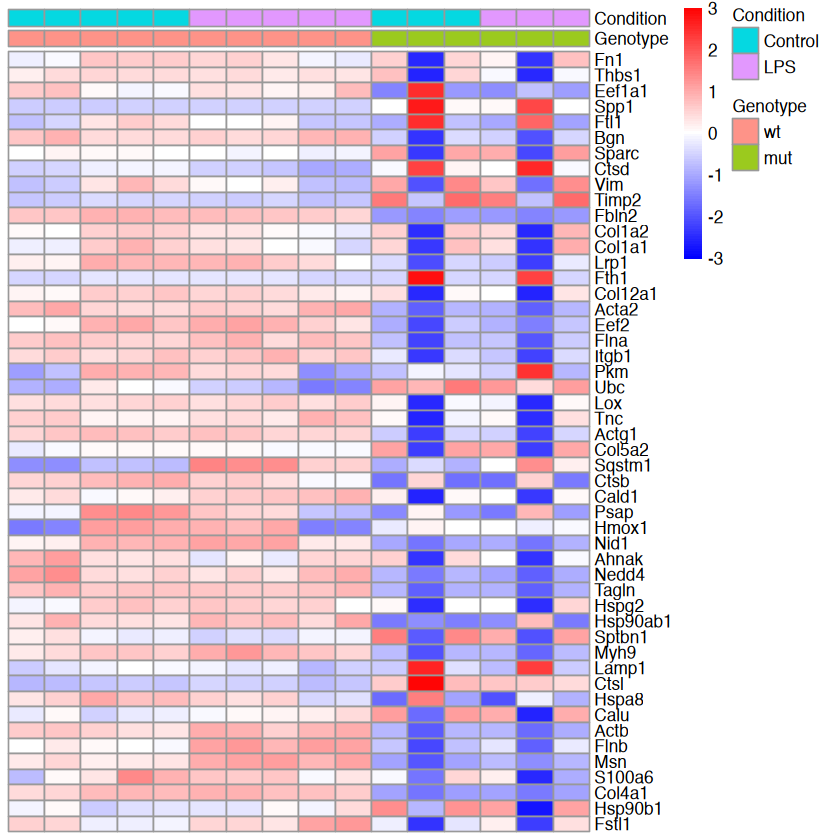

In [40]:
row_means_norm_counts <- apply(normalized_counts, 1, mean)

ordered_indices_norm_counts <- order(-row_means_norm_counts)
ordered_norm_counts <- normalized_counts[ordered_indices_norm_counts, ]
rows_to_keep <- !grepl("^(Gm|Mir|ENSMUS|Rpl.*|.*Rik|mt-|Malat1)", rownames(ordered_norm_counts))

# Filter the dataframe to remove undesired rows
ordered_norm_counts <- ordered_norm_counts[rows_to_keep, ]

# Assuming ordered_norm_counts, manual_annotation, and ann_colors are already defined

# Define the color palette, you might adjust this based on your preference
color_palette <- colorRampPalette(c("blue", "white", "red"))(101) # 101 colors for -3 to 3 scale

# Generate breaks from -3 to 3
breaks <- seq(-3, 3, length.out = length(color_palette))

# Plot the heatmap with the specified breaks and color scale
pheatmap(ordered_norm_counts[1:50, ],
         cluster_rows = FALSE, 
         cluster_cols = FALSE, 
         scale = "row", 
         show_rownames = TRUE, 
         show_colnames = FALSE,
         annotation_col = manual_annotation,
         annotation_colors = ann_colors,
         breaks = breaks,
         color = color_palette)


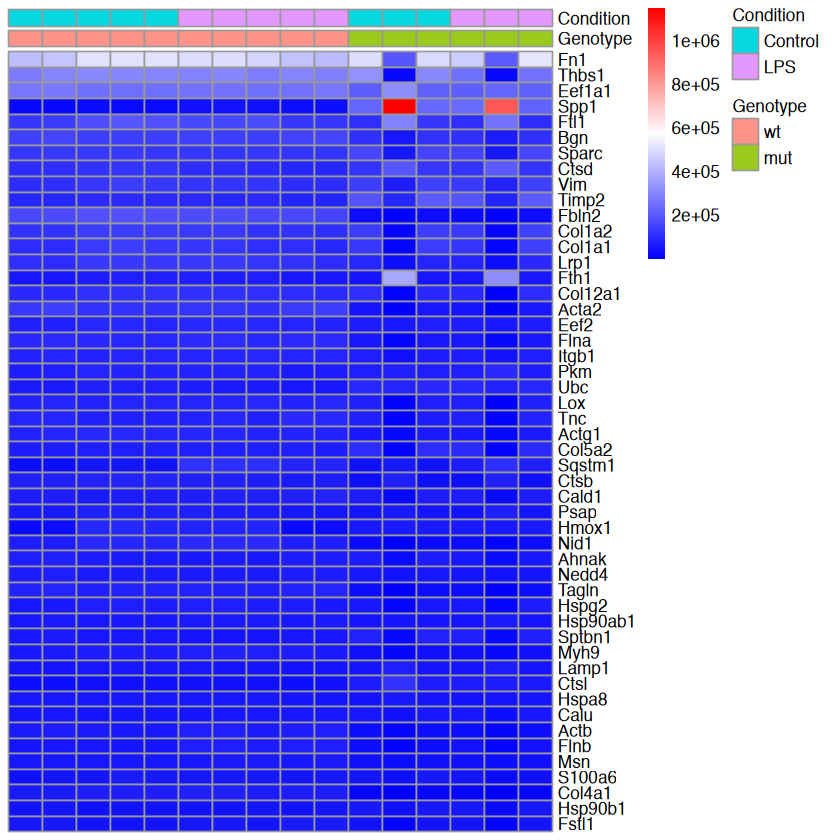

In [41]:
# Step 3: Plot the heatmap with ordered rows of normalized counts
pheatmap(ordered_norm_counts[1:50,],
         cluster_rows = FALSE, 
         cluster_cols = FALSE, 
         scale = "none", 
         show_rownames = TRUE, 
         show_colnames = FALSE,
         annotation_col = manual_annotation,
         annotation_colors = ann_colors,# Adjust based on your preference
         color = colorRampPalette(c("blue", "white", "red"))(255)) # Adjust color gradient as needed

In [42]:
write.csv(rownames(ordered_norm_counts[1:50,]),"MEF_top50_meanvalues_genenames.csv")

In [43]:
LMC_top50genes_bycounts <- read.csv('LMC_top50_meanvalues_genenames.csv')

In [44]:
LMC_top50genes_bycounts$X <- NULL
colnames(LMC_top50genes_bycounts)[1] <- "Gene_name"


In [45]:
LMC_genes_data <- ordered_norm_counts[rownames(ordered_norm_counts) %in% LMC_top50genes_bycounts$Gene_name, ]
gene_names <- LMC_top50genes_bycounts$Gene_name[LMC_top50genes_bycounts$Gene_name %in% rownames(LMC_genes_data)]
LMC_genes_data_ordered <- LMC_genes_data[gene_names, ]


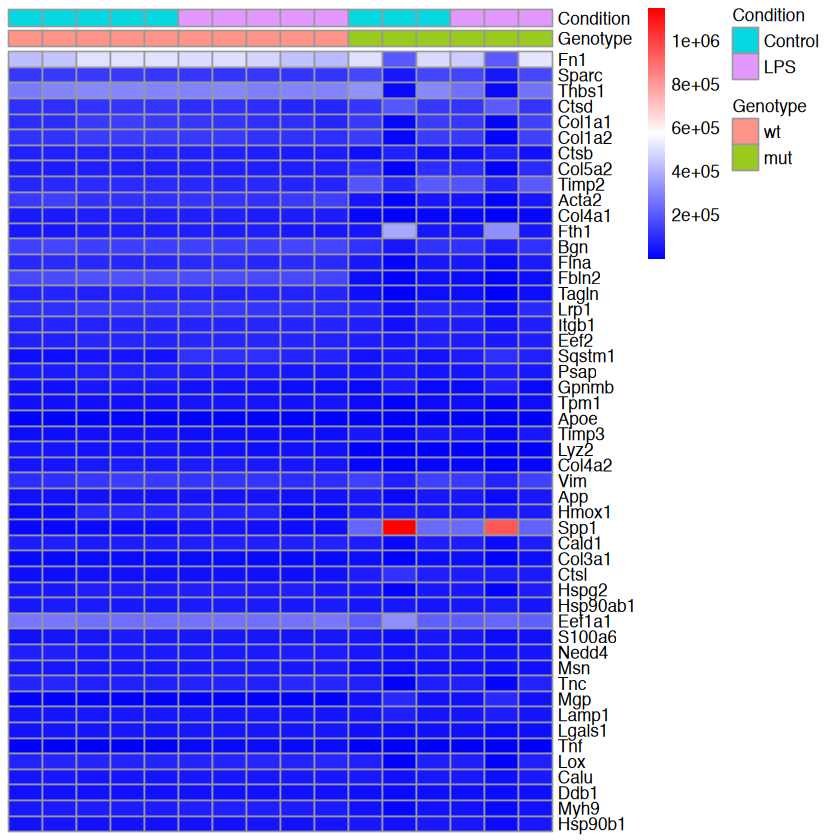

In [46]:
pheatmap(LMC_genes_data_ordered,
         cluster_rows = FALSE, 
         cluster_cols = FALSE, 
         scale = "none", 
         show_rownames = TRUE, 
         show_colnames = FALSE,
         annotation_col = manual_annotation,
         annotation_colors = ann_colors,# Adjust based on your preference
         color = colorRampPalette(c("blue", "white", "red"))(255)) # Adjust color gradient as needed

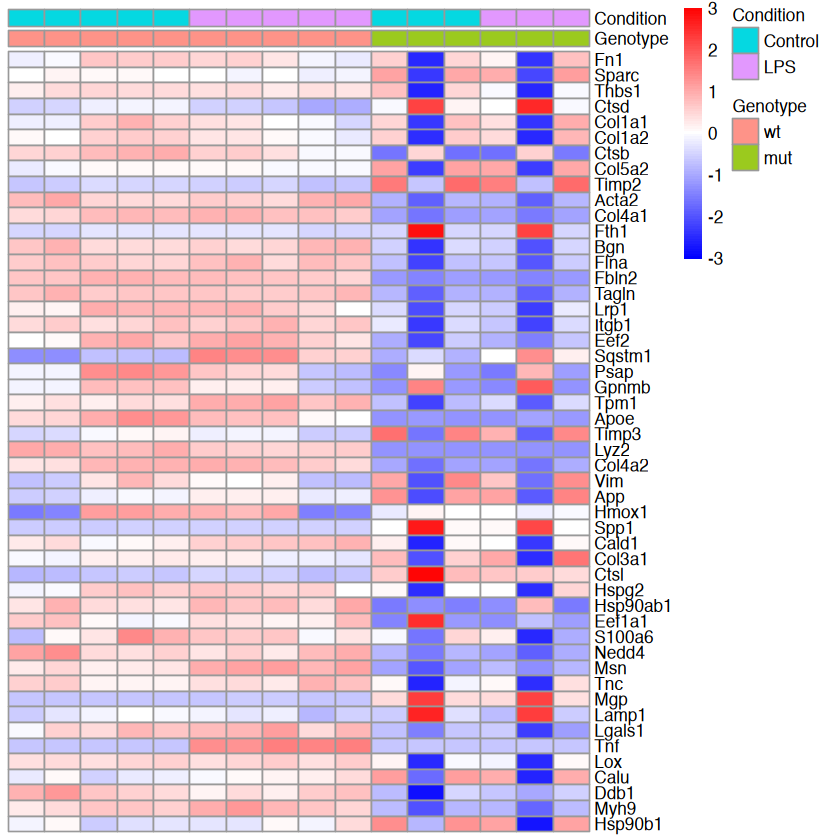

In [47]:
breaks <- seq(-3, 3, length.out = length(color_palette))

# Plot the heatmap with the specified breaks and color scale
pheatmap(LMC_genes_data_ordered,
         cluster_rows = FALSE, 
         cluster_cols = FALSE, 
         scale = "row", 
         show_rownames = TRUE, 
         show_colnames = FALSE,
         annotation_col = manual_annotation,
         annotation_colors = ann_colors,
         breaks = breaks,
         color = color_palette)

In [48]:
groups <- c("wt_Control", "wt_Control", "wt_Control","wt_Control","wt_Control","wt_LPS","wt_LPS","wt_LPS","wt_LPS","wt_LPS","mut_Control","mut_Control","mut_Control", "mut_LPS", "mut_LPS","mut_LPS")

In [49]:
normalized_counts_1 <- data.frame(normalized_counts)

In [50]:
normalized_counts_2 <- data.frame(
  Gene = rownames(normalized_counts_1),
  P8_4_Lps3_minus_Ctrl3 = normalized_counts_1$P8_4_Lps3 - normalized_counts_1$P8_4_Ctrl3,
  P8_4_Lps5_minus_Ctrl5 = normalized_counts_1$P8_4_Lps5 - normalized_counts_1$P8_4_Ctrl5,
  P8_4_Lps4_minus_Ctrl4 = normalized_counts_1$P8_4_Lps4 - normalized_counts_1$P8_4_Ctrl4,
  P7_4_Lps1_minus_Ctrl1 = normalized_counts_1$P7_4_Lps1 - normalized_counts_1$P7_4_Ctrl1,
  P7_4_Lps2_minus_Ctrl2 = normalized_counts_1$P7_4_Lps2 - normalized_counts_1$P7_4_Ctrl2,
  P4_5_Lps2_minus_Ctrl2 = normalized_counts_1$P4_5_Lps2 - normalized_counts_1$P4_5_Ctrl2,
  P4_5_Lps3_minus_Ctrl3 = normalized_counts_1$P4_5_Lps3 - normalized_counts_1$P4_5_Ctrl3,
  P4_5_Lps1_minus_Ctrl1 = normalized_counts_1$P4_5_Lps1 - normalized_counts_1$P4_5_Ctrl1
)


In [51]:
colnames(normalized_counts_2)[1] <- "Gene_name"
colnames(normalized_counts_2)[7] <- "P8_4_3"
colnames(normalized_counts_2)[9] <- "P8_4_5"
colnames(normalized_counts_2)[8] <- "P8_4_4"
colnames(normalized_counts_2)[5] <- "P7_4_1"
colnames(normalized_counts_2)[6] <- "P7_4_2"
colnames(normalized_counts_2)[3] <- "P4_5_2"
colnames(normalized_counts_2)[4] <- "P4_5_3"
colnames(normalized_counts_2)[2] <- "P4_5_1"

In [52]:
write.csv(normalized_counts_2,'MEF_normalized_counts_differences.csv')

In [53]:
glimmaMDS(dds,html = "MDS_plot_MEF_all_samples_March27_2024.html")

Saving widget...

MDS_plot_MEF_all_samples_March27_2024.html generated.



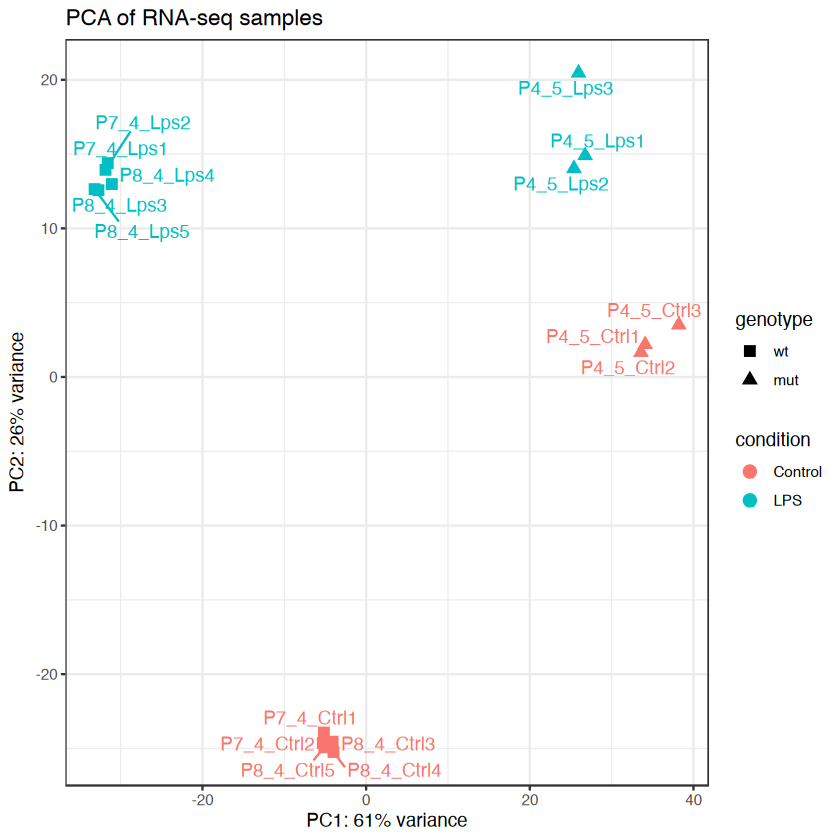

In [54]:
rlog_data <- rlog(dds)
pca_data <- plotPCA(rlog_data, intgroup=c("condition", "genotype"), returnData=TRUE)
percentVar <- round(100 * attr(pca_data, "percentVar"))
ggplot(pca_data, aes(x = PC1, y = PC2, color = condition, shape = genotype)) +
    geom_point(size = 3) +
    geom_text_repel(aes(label = row.names(pca_data))) +
    xlab(paste0("PC1: ", percentVar[1], "% variance")) +
    ylab(paste0("PC2: ", percentVar[2], "% variance")) +
    ggtitle("PCA of RNA-seq samples") +
    theme_bw() +
    scale_shape_manual(values = c(15, 17, 19))


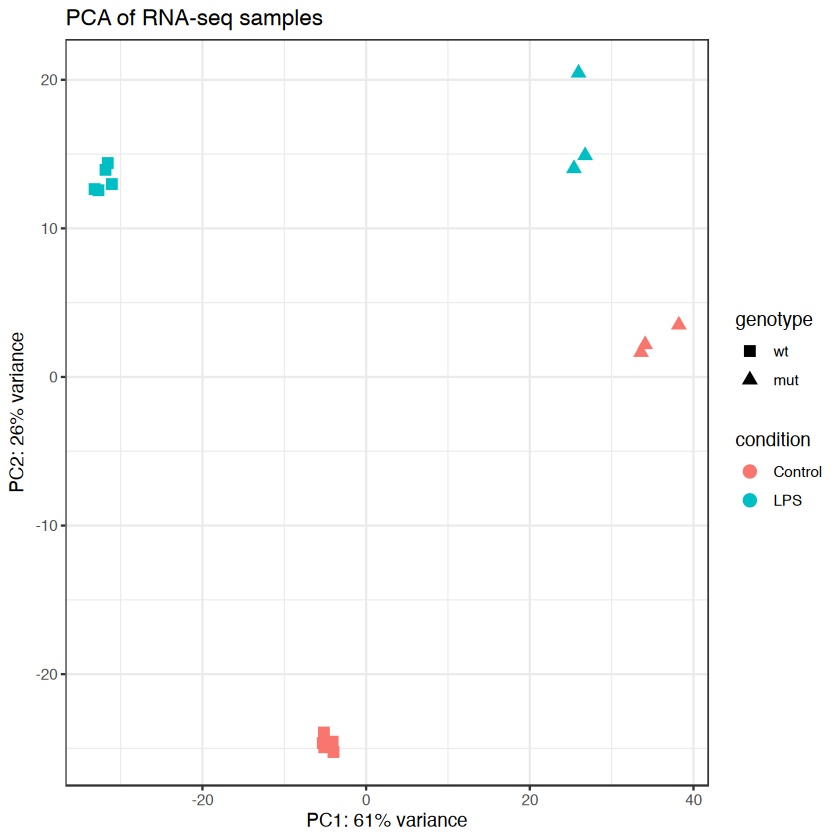

In [55]:
library(DESeq2)
library(ggplot2)
library(ggrepel) # Ensure you have ggrepel installed for geom_text_repel

# Assuming rlog_data and dds are already defined and correctly prepared
rlog_data <- rlog(dds)

pca_data <- plotPCA(rlog_data, intgroup=c("condition", "genotype"), returnData=TRUE)
percentVar <- round(100 * attr(pca_data, "percentVar"))

# Generate the PCA plot without sample names
ggplot(pca_data, aes(x = PC1, y = PC2, color = condition, shape = genotype)) +
    geom_point(size = 3) +
    xlab(paste0("PC1: ", percentVar[1], "% variance")) +
    ylab(paste0("PC2: ", percentVar[2], "% variance")) +
    ggtitle("PCA of RNA-seq samples") +
    theme_bw() +
    scale_shape_manual(values = c(15, 17, 19)) # Adjust shapes or colors as needed


In [56]:
pca_data_onlyControl <- pca_data %>%
  filter(condition == "Control")

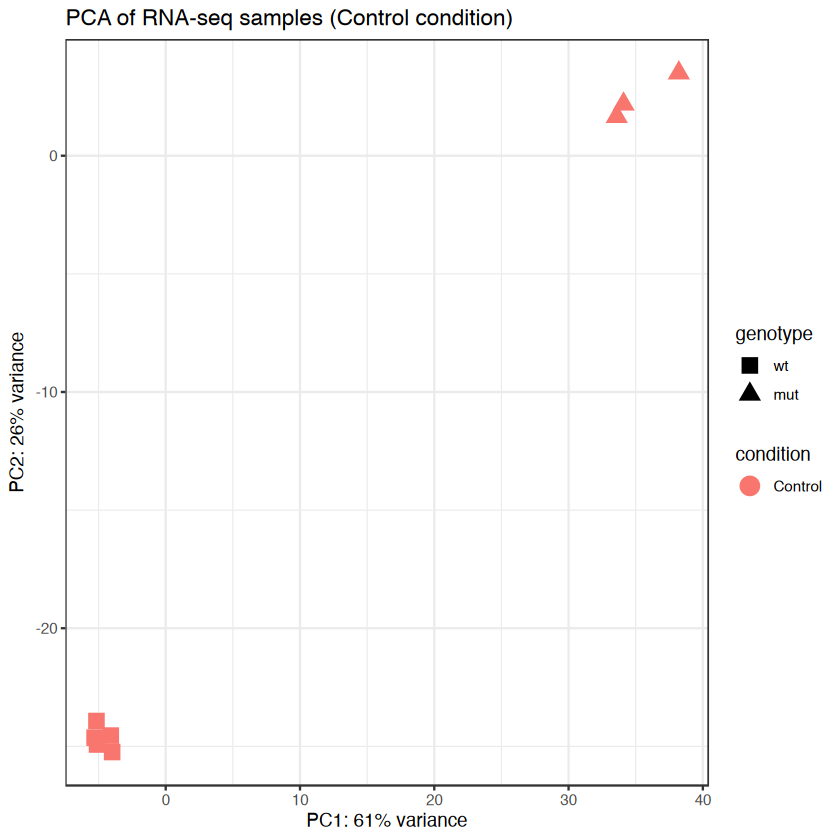

In [57]:
ggplot(pca_data_onlyControl, aes(x = PC1, y = PC2, color = condition, shape = genotype)) +
    geom_point(size = 4, stroke = 1) + # Adjust size and stroke for visibility
    xlab(paste0("PC1: ", percentVar[1], "% variance")) +
    ylab(paste0("PC2: ", percentVar[2], "% variance")) +
    ggtitle("PCA of RNA-seq samples (Control condition)") +
    theme_bw() +
    scale_shape_manual(values = c(15, 17, 19)) # Adjust shapes or colors as needed


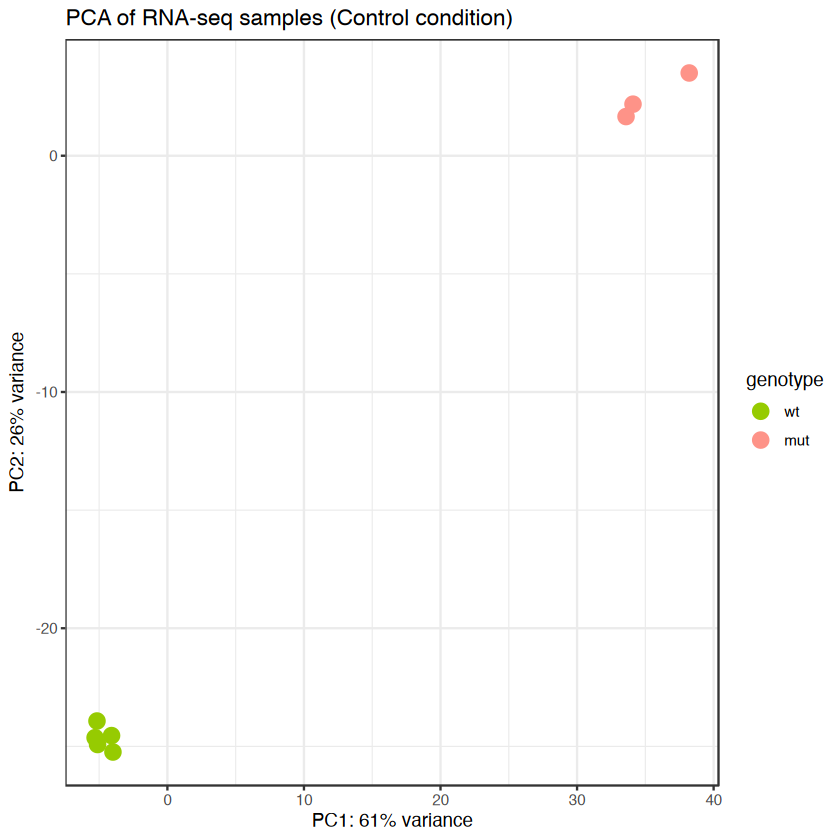

In [58]:
ggplot(pca_data_onlyControl, aes(x = PC1, y = PC2, color = genotype)) +
    geom_point(size = 4, stroke = 1, shape = 16) + # Shape set to 16 for all points
    xlab(paste0("PC1: ", percentVar[1], "% variance")) +
    ylab(paste0("PC2: ", percentVar[2], "% variance")) +
    ggtitle("PCA of RNA-seq samples (Control condition)") +
    theme_bw() +
    scale_color_manual(values = c("wt" = "#96cb01", "mut" = "#fe9388")) # Adjust as per your genotypes

Carrying out DE analysis using DESeq2


Next part of code should help answer this :


I.The effect of treatment in wild-type.[This is for WT, treated compared with untreated.]

1.Genes upregulated with LPS in wild-type samples

2.Genes downregulated with LPS in wild-type samples



II.The effect of treatment in mutant[This is for knockout,treated compared with untreated ]   


3.Genes upregulated with LPS in Sp3 knockout samples

4.Genes downregulated with LPS in Sp3 knockout samples



III.What is the difference between mutant and wild-type in control treatments ?[mutant ctrl compared with wild type ctrl]

5.Genes upregulated in wild-type samples in control treatment/Genes downregulated in wild-type samples in control treatment

6.Genes downregulated in wild-type samples in control treatment/Genes downregulated in wild-type samples in control treatment



IV.With LPS treatment, what is the difference between mutant and wild-type?[mutant LPS compared with wild type LPS]

8.Genes upregulated in mutant samples compared to wildtype with LPS treatment

9.Genes downregulated in mutant samples compared to wildtype with LPS treatment




In [59]:
res <- results(dds)
summary(res)


out of 20298 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 472, 2.3%
LFC < 0 (down)     : 806, 4%
outliers [1]       : 106, 0.52%
low counts [2]     : 2361, 12%
(mean count < 6)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [60]:
#Plotting Glimma/scatter plots showing expression levels of particular gene across samples.
countData2 <- countData1
rownames(countData2) <- toupper(rownames(countData2))

gene_expression <- countData2["MEF2A",]  # Extract expression levels for particular gene
plot_data <- data.frame(
  Sample = colnames(countData2),  
  Expression = as.numeric(gene_expression),  
  Group = groups  
)
gene_name <- "MEF2A"

In [61]:
gene_expression

P7_4_Ctrl1 P7_4_Ctrl2 P8_4_Ctrl3 P8_4_Ctrl4 P8_4_Ctrl5 P8_4_Lps3
MEF2A 2247       4712       4714       6443       4350       4830     
      P8_4_Lps5 P8_4_Lps4 P7_4_Lps1 P7_4_Lps2 P4_5_Ctrl1 P4_5_Ctrl3 P4_5_Ctrl2
MEF2A 4655      3851      2621      3230      7329       3691       5075      
      P4_5_Lps2 P4_5_Lps3 P4_5_Lps1
MEF2A 2636      1719      6645

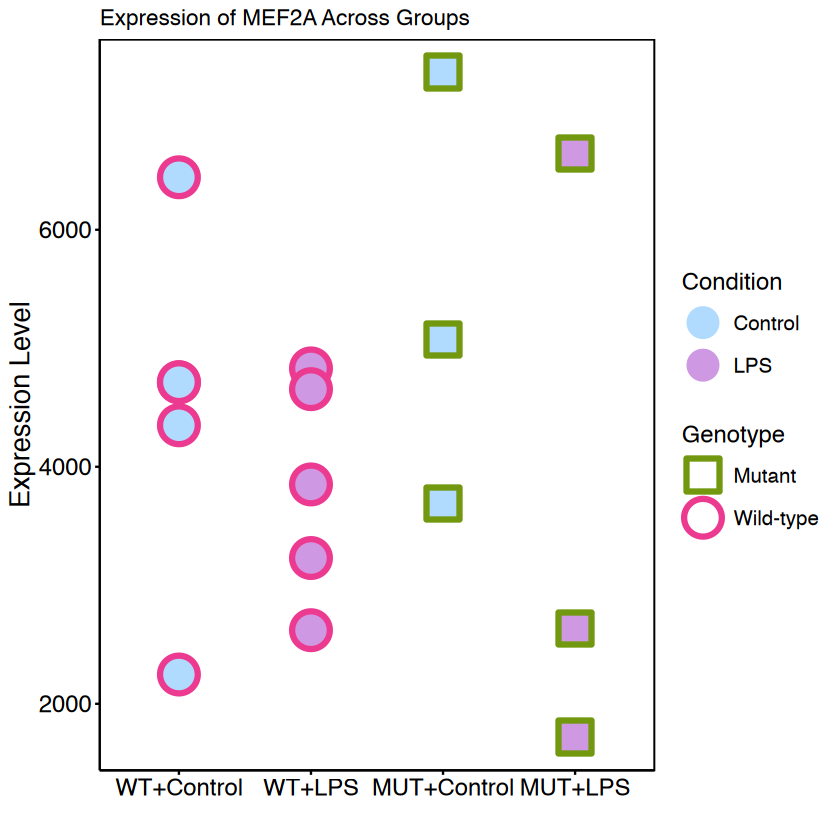

In [62]:
# Create Genotype and Condition columns based on the Group column
plot_data$Genotype <- ifelse(grepl("wt", plot_data$Group), "WT", "MUT")
plot_data$Condition <- ifelse(grepl("Control", plot_data$Group), "Control", "LPS")

# Create a new column for the combined labels
plot_data$Group_Combined <- with(plot_data, paste(Genotype, Condition, sep = "+"))

# Define the colors
genotype_colors <- c("WT" = "#fe9388", "MUT" = "#9bca1e")
condition_colors <- c("Control" = "#add8e6", "LPS" = "#e298fe")  # Lighter blue for Control

# Define the colors
genotype_colors <- c("WT" = "#EC3A91", "MUT" = "#71980E")  # Adjusted colors
condition_colors <- c("Control" = "#B0DBFF", "LPS" = "#CF98E2")  # Lightened inside colors

# Create the plot
ggplot(plot_data, aes(x = Group_Combined, y = Expression)) +
  geom_point(aes(fill = Condition, color = Genotype, shape = Genotype), size = 9, stroke = 2) +  # Use shape 21 for filled points with outline
  scale_fill_manual(name = "Condition", values = condition_colors, guide = guide_legend(override.aes = list(shape = 21, size = 9, stroke = 0))) +  # Inner circle colors and remove outline in legend
  scale_color_manual(name = "Genotype", values = genotype_colors, labels = c("WT" = "Wild-type", "MUT" = "Mutant")) +  # Outer circle colors
  scale_shape_manual(name = "Genotype", values = c("WT" = 21, "MUT" = 22), labels = c("WT" = "Wild-type", "MUT" = "Mutant")) +  # Shape 21 for circles, 22 for squares
  scale_x_discrete(limits = c("WT+Control", "WT+LPS", "MUT+Control", "MUT+LPS")) +  # Set the order of the x-axis labels
  labs(
    title = paste("Expression of", gene_name, "Across Groups"),
    x = "",
    y = "Expression Level"
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(size = 14, color = "black"),  # Increase x-axis label size
    axis.text.y = element_text(size = 14, color = "black"),  # Increase y-axis label size
    axis.title.x = element_text(size = 16),  # Increase x-axis title size
    axis.title.y = element_text(size = 16),  # Increase y-axis title size
    axis.ticks = element_line(color = "black"),
    axis.line = element_line(color = "black"),
    panel.background = element_blank(),
    panel.border = element_rect(color = "black", fill = NA),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    legend.position = "right",
    legend.text = element_text(size = 12),  # Increase legend text size
    legend.title = element_text(size = 14),  # Increase legend title size
    legend.key = element_blank()  # Remove legend key outline
  )

In [63]:
library(dplyr)

# Calculate mean and sd for each group
summary_data <- plot_data %>%
  group_by(Group_Combined, Genotype, Condition) %>%
  summarise(
    mean_expression = mean(Expression, na.rm = TRUE),
    sd_expression = sd(Expression, na.rm = TRUE),
    n = n()
  )


`summarise()` has grouped output by 'Group_Combined', 'Genotype'. You can override using the `.groups` argument.


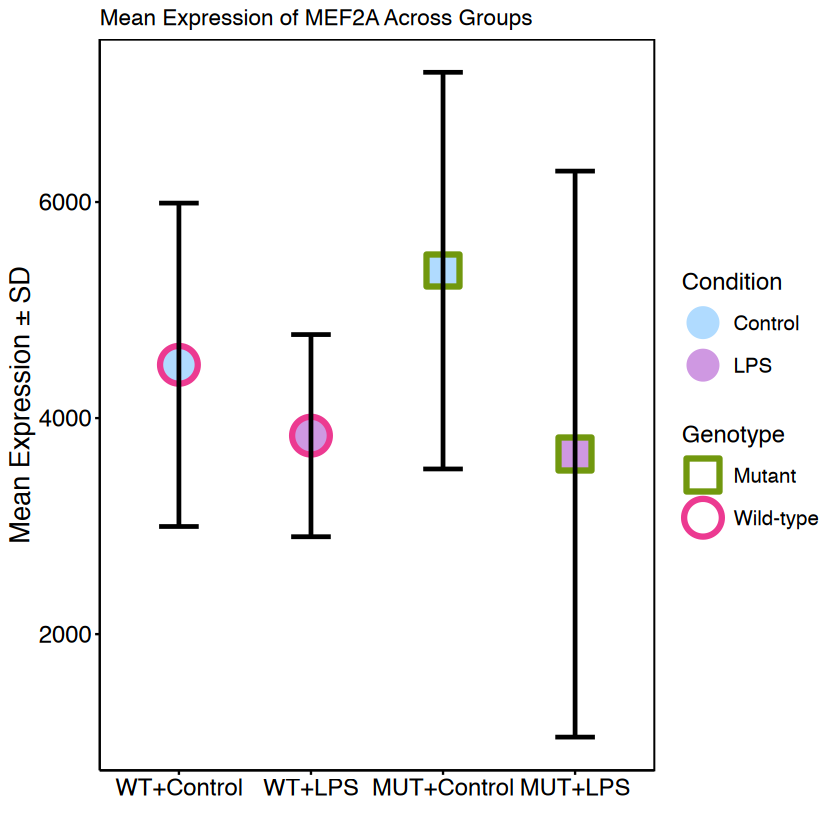

In [64]:
ggplot(summary_data, aes(x = Group_Combined, y = mean_expression)) +
  geom_point(
    aes(fill = Condition, color = Genotype, shape = Genotype),
    size = 9, stroke = 2
  ) +
  geom_errorbar(
    aes(ymin = mean_expression - sd_expression, ymax = mean_expression + sd_expression),
    width = 0.3, linewidth = 1
  ) +
  scale_fill_manual(
    name = "Condition",
    values = condition_colors,
    guide = guide_legend(override.aes = list(shape = 21, size = 9, stroke = 0))
  ) +
  scale_color_manual(
    name = "Genotype",
    values = genotype_colors,
    labels = c("WT" = "Wild-type", "MUT" = "Mutant")
  ) +
  scale_shape_manual(
    name = "Genotype",
    values = c("WT" = 21, "MUT" = 22),
    labels = c("WT" = "Wild-type", "MUT" = "Mutant")
  ) +
  scale_x_discrete(
    limits = c("WT+Control", "WT+LPS", "MUT+Control", "MUT+LPS")
  ) +
  labs(
    title = paste("Mean Expression of", gene_name, "Across Groups"),
    x = "",
    y = "Mean Expression ± SD"
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(size = 14, color = "black"),
    axis.text.y = element_text(size = 14, color = "black"),
    axis.title.x = element_text(size = 16),
    axis.title.y = element_text(size = 16),
    axis.ticks = element_line(color = "black"),
    axis.line = element_line(color = "black"),
    panel.background = element_blank(),
    panel.border = element_rect(color = "black", fill = NA),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    legend.position = "right",
    legend.text = element_text(size = 12),
    legend.title = element_text(size = 14),
    legend.key = element_blank()
  )


In [65]:
# Load required libraries
library(ggplot2)

# Ensure gene names are in uppercase
countData2 <- countData1
rownames(countData2) <- toupper(rownames(countData2))

# Define gene lists
gene_list <- c(
  "CCL4"
)

# Define colors
genotype_colors <- c("WT" = "#EC3A91", "MUT" = "#71980E")
condition_colors <- c("Control" = "#B0DBFF", "LPS" = "#CF98E2")

# Create output directory
output_dir <- "Gene_Expression_Plots"
if (!dir.exists(output_dir)) dir.create(output_dir)

# Loop through each gene and generate the plots
for (gene in gene_list) {
  if (gene %in% rownames(countData2)) {
    gene_expression <- countData2[gene,]  # Extract expression levels
    
    plot_data <- data.frame(
      Sample = colnames(countData2),
      Expression = as.numeric(gene_expression),
      Group = groups
    )

    # Assign Genotype and Condition
    plot_data$Genotype <- ifelse(grepl("wt", plot_data$Group, ignore.case = TRUE), "WT", "MUT")
    plot_data$Condition <- ifelse(grepl("Control", plot_data$Group, ignore.case = TRUE), "Control", "LPS")
    plot_data$Group_Combined <- with(plot_data, paste(Genotype, Condition, sep = "+"))

    # Generate plot
    p <- ggplot(plot_data, aes(x = Group_Combined, y = Expression)) +
      geom_point(aes(fill = Condition, color = Genotype, shape = Genotype), size = 9, stroke = 2) +
      scale_fill_manual(name = "Condition", values = condition_colors, guide = guide_legend(override.aes = list(shape = 21, size = 9, stroke = 0))) +
      scale_color_manual(name = "Genotype", values = genotype_colors, labels = c("WT" = "Wild-type", "MUT" = "Mutant")) +
      scale_shape_manual(name = "Genotype", values = c("WT" = 21, "MUT" = 22), labels = c("WT" = "Wild-type", "MUT" = "Mutant")) +
      scale_x_discrete(limits = c("WT+Control", "WT+LPS", "MUT+Control", "MUT+LPS")) +
      labs(
        title = paste("Expression of", gene, "Across Groups"),
        x = "",
        y = "Expression Level"
      ) +
      theme_minimal() +
      theme(
        axis.text.x = element_text(size = 14, color = "black"),
        axis.text.y = element_text(size = 14, color = "black"),
        axis.title.x = element_text(size = 16),
        axis.title.y = element_text(size = 16),
        axis.ticks = element_line(color = "black"),
        axis.line = element_line(color = "black"),
        panel.background = element_blank(),
        panel.border = element_rect(color = "black", fill = NA),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        legend.position = "right",
        legend.text = element_text(size = 12),
        legend.title = element_text(size = 14),
        legend.key = element_blank()
      )

    # Save plot
    plot_filename <- file.path(output_dir, paste0(gene, "_mef_expression_plot.png"))
    ggsave(plot_filename, plot = p, width = 8, height = 6, dpi = 300)
    
    message("Saved plot for: ", gene)
  } else {
    message("Gene not found in data: ", gene)
  }
}

message("All plots saved in the directory: ", output_dir)


Saved plot for: CCL4

All plots saved in the directory: Gene_Expression_Plots



In [66]:
# Load required libraries
library(ggplot2)

# Ensure gene names are in uppercase
countData2 <- countData1
rownames(countData2) <- toupper(rownames(countData2))

# Define gene list
gene_list <- c(
  "INCENP", "ZWILCH", "SPDL1", "CDCA8", "CDT1", "STIL", "GEN1", "SPC24", "TRIP13", "AURKA",
  "BUB1B", "AURKB", "BIRC5", "TTK", "NDC80", "CENPE", "CDC20", "NUF2", "PLK1", "BUB1",
  "KNTC1", "CCNB1",
  "PITX1", "TBX4", "HOXA11", "HOXA10", "BMP4", "SALL1", "HOXC11", "HOXC10", "LMX1B",
  "ALX3", "MSX1", "ALDH1A2", "GDF5", "GJA1", "LEF1", "NOG", "TBX2", "CRABP2", "HAND2",
  "CYP26B1", "TBX5", "RARB", "SHOX2", "FGF9", "HOXA9", "MSX2"
)

# Define colors
genotype_colors <- c("WT" = "#EC3A91", "MUT" = "#71980E")
condition_colors <- c("Control" = "#B0DBFF")  # Only Control remains

# Create output directory
output_dir <- "Gene_Expression_Plots"
if (!dir.exists(output_dir)) dir.create(output_dir)

# Loop through each gene and generate the plots
for (gene in gene_list) {
  if (gene %in% rownames(countData2)) {
    gene_expression <- countData2[gene,]  # Extract expression levels
    
    plot_data <- data.frame(
      Sample = colnames(countData2),
      Expression = as.numeric(gene_expression),
      Group = groups
    )

    # Assign Genotype and Condition
    plot_data$Genotype <- ifelse(grepl("wt", plot_data$Group, ignore.case = TRUE), "WT", "MUT")
    plot_data$Condition <- ifelse(grepl("Control", plot_data$Group, ignore.case = TRUE), "Control", "LPS")
    
    # Filter out LPS groups
    plot_data <- subset(plot_data, Condition == "Control")
    
    # Create a new column for the combined labels
    plot_data$Group_Combined <- with(plot_data, paste(Genotype, Condition, sep = "+"))

    # Generate plot
    p <- ggplot(plot_data, aes(x = Group_Combined, y = Expression)) +
      geom_point(aes(fill = Condition, color = Genotype, shape = Genotype), size = 9, stroke = 2) +
      scale_fill_manual(name = "Condition", values = condition_colors, guide = guide_legend(override.aes = list(shape = 21, size = 9, stroke = 0))) +
      scale_color_manual(name = "Genotype", values = genotype_colors, labels = c("WT" = "Wild-type", "MUT" = "Mutant")) +
      scale_shape_manual(name = "Genotype", values = c("WT" = 21, "MUT" = 22), labels = c("WT" = "Wild-type", "MUT" = "Mutant")) +
      scale_x_discrete(limits = c("WT+Control", "MUT+Control")) +  # Only control groups
      labs(
        title = paste("Expression of", gene, "Across Groups"),
        x = "",
        y = "Expression Level"
      ) +
      theme_minimal() +
      theme(
        axis.text.x = element_text(size = 14, color = "black"),
        axis.text.y = element_text(size = 14, color = "black"),
        axis.title.x = element_text(size = 16),
        axis.title.y = element_text(size = 16),
        axis.ticks = element_line(color = "black"),
        axis.line = element_line(color = "black"),
        panel.background = element_blank(),
        panel.border = element_rect(color = "black", fill = NA),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        legend.position = "right",
        legend.text = element_text(size = 12),
        legend.title = element_text(size = 14),
        legend.key = element_blank()
      )

    # Save plot
    plot_filename <- file.path(output_dir, paste0(gene, "_mef_expression_plot_withoutLPS.png"))
    ggsave(plot_filename, plot = p, width = 8, height = 6, dpi = 300)
    
    message("Saved plot for: ", gene)
  } else {
    message("Gene not found in data: ", gene)
  }
}

message("All plots saved in the directory: ", output_dir)


Saved plot for: INCENP

Saved plot for: ZWILCH

Saved plot for: SPDL1

Saved plot for: CDCA8

Saved plot for: CDT1

Saved plot for: STIL

Saved plot for: GEN1

Saved plot for: SPC24

Saved plot for: TRIP13

Saved plot for: AURKA

Saved plot for: BUB1B

Saved plot for: AURKB

Saved plot for: BIRC5

Saved plot for: TTK

Saved plot for: NDC80

Saved plot for: CENPE

Saved plot for: CDC20

Saved plot for: NUF2

Saved plot for: PLK1

Saved plot for: BUB1

Saved plot for: KNTC1

Saved plot for: CCNB1

Saved plot for: PITX1

Saved plot for: TBX4

Saved plot for: HOXA11

Saved plot for: HOXA10

Saved plot for: BMP4

Saved plot for: SALL1

Saved plot for: HOXC11

Saved plot for: HOXC10

Saved plot for: LMX1B

Saved plot for: ALX3

Saved plot for: MSX1

Saved plot for: ALDH1A2

Saved plot for: GDF5

Saved plot for: GJA1

Saved plot for: LEF1

Saved plot for: NOG

Saved plot for: TBX2

Saved plot for: CRABP2

Saved plot for: HAND2

Saved plot for: CYP26B1

Saved plot for: TBX5

Saved plot for: RA

Warning message in brewer.pal(num_groups, "Set1"):
"minimal value for n is 3, returning requested palette with 3 different levels
"


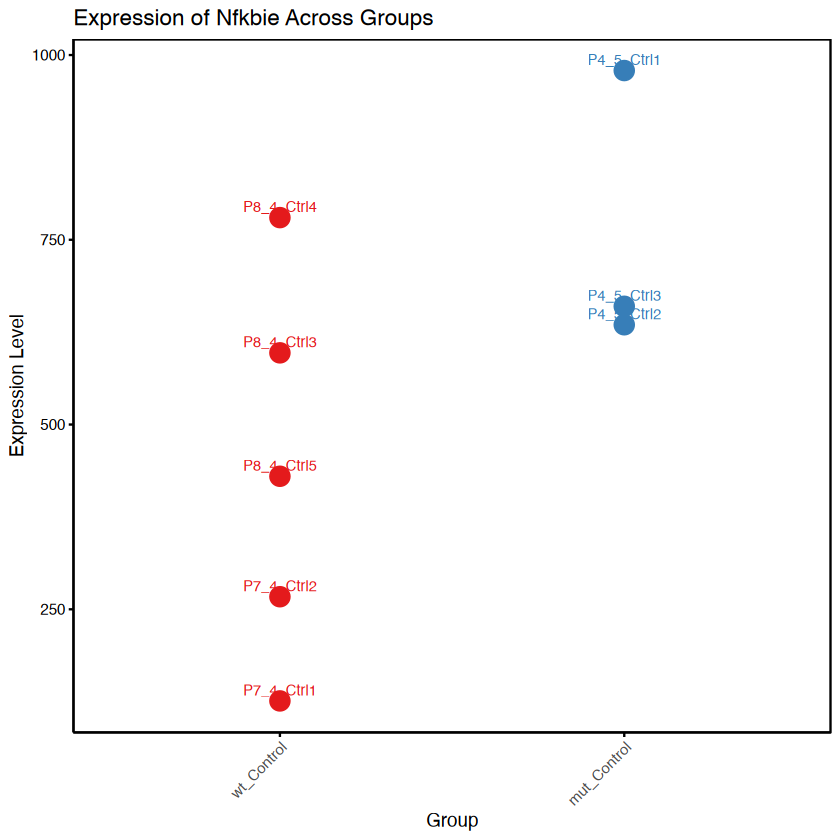

In [67]:
library(ggplot2)
library(RColorBrewer)

# Assuming 'plot_data' is already prepared with 'Sample', 'Expression', 'Group', and 'GeneName'
gene_name <- "Nfkbie"

# Prepare colors
num_groups <- length(unique(plot_data$Group))
palette <- brewer.pal(num_groups, "Set1")
if (num_groups > 9) { # Set1 has a maximum of 9 colors
  palette <- colorRampPalette(brewer.pal(9, "Set1"))(num_groups)
}

# Order the 'Group' factor based on unique values
plot_data$Group <- factor(plot_data$Group, levels = unique(plot_data$Group))

# Plot with sample names
ggplot(plot_data, aes(x = Group, y = Expression, color = Group)) +
  geom_point(size = 5) +  # Increase the size of the points
  geom_text(aes(label = Sample), vjust = -0.5, size = 3) +  # Add text labels for each sample
  scale_color_manual(values = palette) +  # Use the generated palette for colors
  labs(
    title = paste("Expression of", gene_name, "Across Groups"),
    x = "Group",
    y = "Expression Level"
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    axis.text.y = element_text(color = "black"),
    axis.ticks = element_line(color = "black"),
    axis.line = element_line(color = "black"),
    panel.background = element_blank(),
    panel.border = element_rect(color = "black", fill = NA),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    legend.position = "none"
  )


In [68]:
res <- results(dds, name="genotypemut.conditionLPS",alpha = 0.05)
topGenes <- head(order(res$padj), 50)
topGeneCounts <- countData[topGenes,]


In [69]:
topGenes <- head(order(res$log2FoldChange, na.last=NA), 60)  # na.last=NA removes NAs
countData <- counts(dds, normalized=TRUE)
topGeneCounts <- countData[topGenes, ]
rownames(manual_annotation) <- colnames(topGeneCounts)

In [70]:
# Remove rows where row name starts with 'NA'
filtered_topGeneCounts <- topGeneCounts[!grepl("^NA", rownames(topGeneCounts)), ]


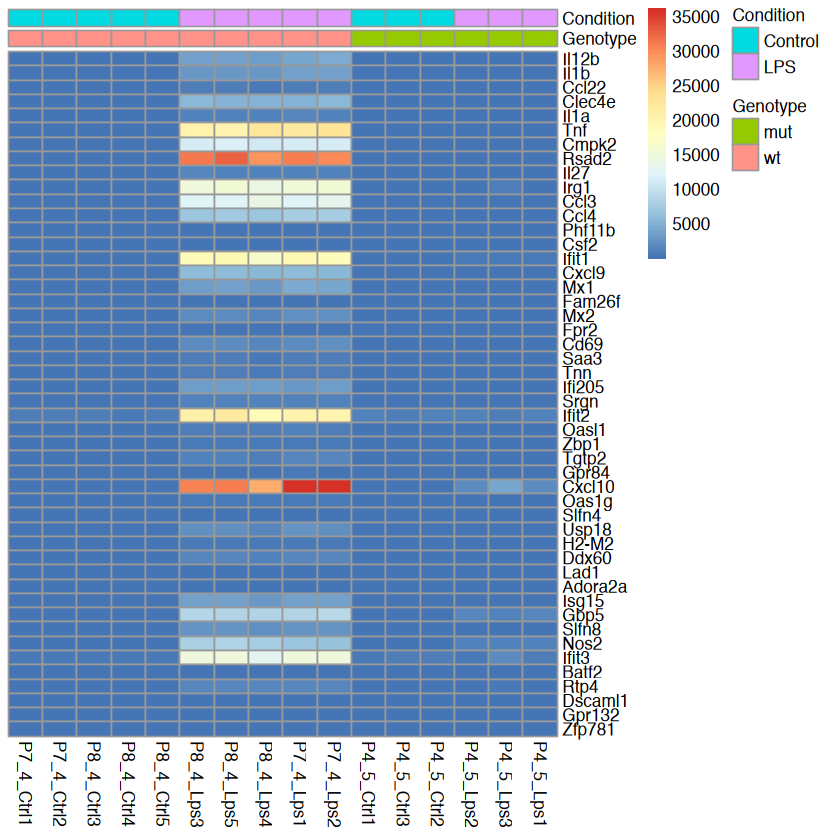

In [71]:
# Filter the rows of filtered_topGeneCounts based on your criteria
filtered_rows <- rownames(filtered_topGeneCounts)[!grepl("^Gm|^Mir|^ENSMUS|^Rpl|Rik$", rownames(filtered_topGeneCounts))]

# Subset the dataframe to include only the filtered rows
filtered_topGeneCounts_filtered <- filtered_topGeneCounts[filtered_rows, ]

# Create the heatmap with the filtered dataframe
pheatmap(filtered_topGeneCounts_filtered, 
         cluster_rows = FALSE, 
         cluster_cols = FALSE, 
         annotation_col = as.data.frame(manual_annotation), 
         show_rownames = TRUE)

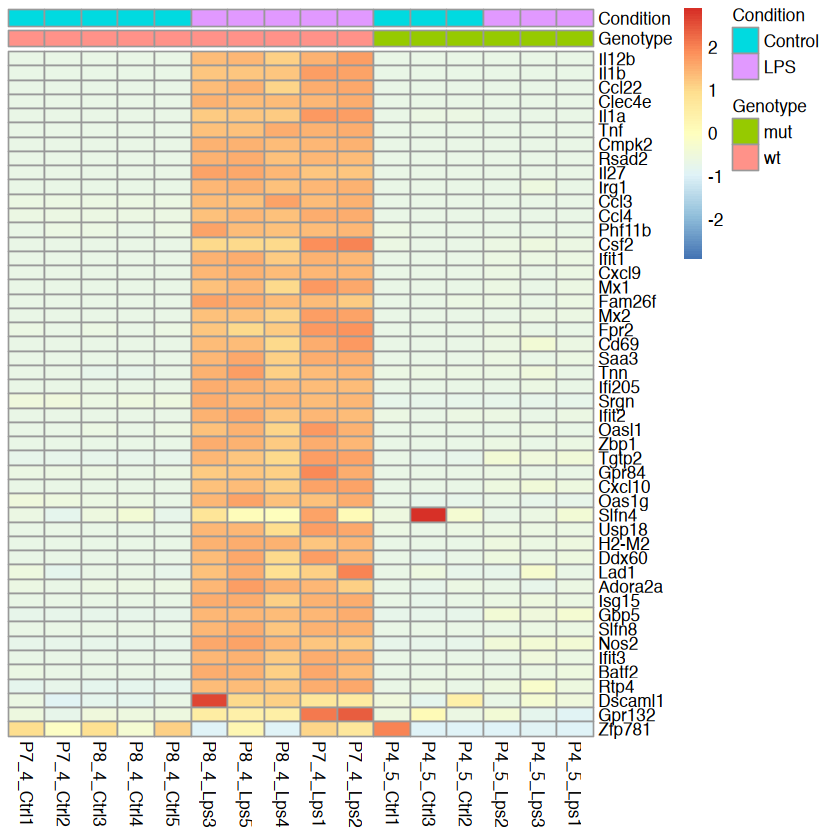

In [72]:
# Create the heatmap with the filtered dataframe
pheatmap(filtered_topGeneCounts_filtered, 
         cluster_rows = FALSE, 
         cluster_cols = FALSE, 
         scale = "row",
         annotation_col = as.data.frame(manual_annotation), 
         show_rownames = TRUE)

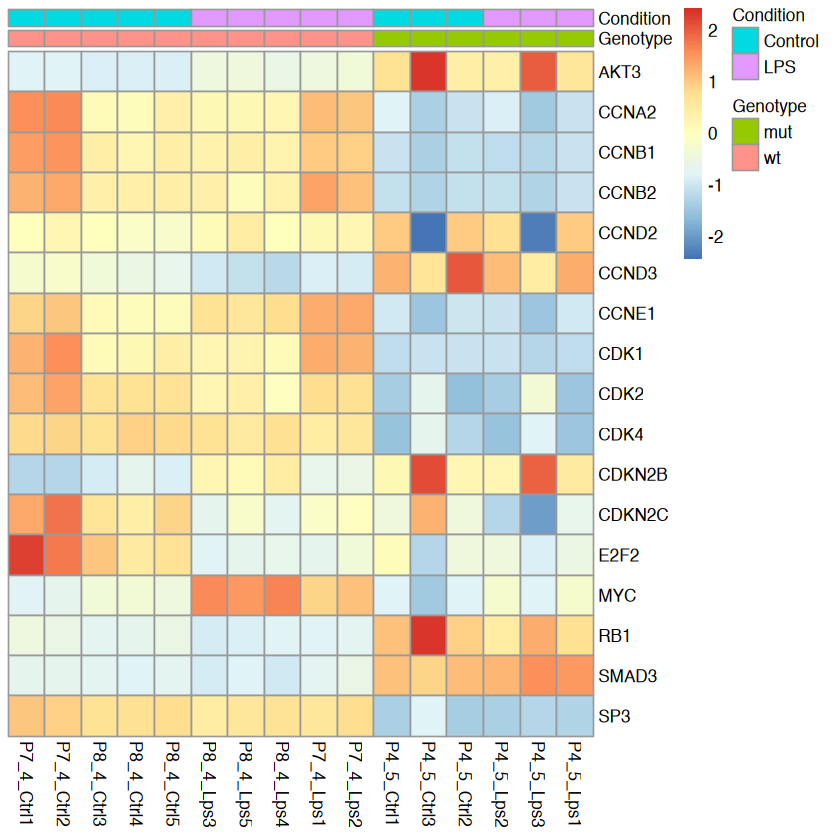

In [73]:
cell_cycle_mef <- read.table('mef_cellcyclegenes.txt')
cell_cycle_lmc <- read.table('lmc_cellcyclegenes.txt')
colnames(cell_cycle_mef)[1] <- "Gene_name"
colnames(cell_cycle_lmc)[1] <- "Gene_name"
cell_cycle_mef_combo <- rbind(cell_cycle_lmc,cell_cycle_mef)

cell_cycle_mef_combo$Gene_name <- toupper(cell_cycle_mef_combo$Gene_name)







# Filter the countData to include only genes in the nf_kb list
rownames(countData) <- toupper(rownames(countData))
cell_cycle_res <- intersect(rownames(countData), cell_cycle_mef_combo$Gene_name)
filteredCountData_cellcycle <- countData[cell_cycle_res, ]



# Plot the heatmap for the top 100 genes
pheatmap(filteredCountData_cellcycle, 
         cluster_rows = FALSE, 
         cluster_cols = FALSE, 
         annotation_col = as.data.frame(manual_annotation), 
         show_rownames = TRUE,scale = 'row')

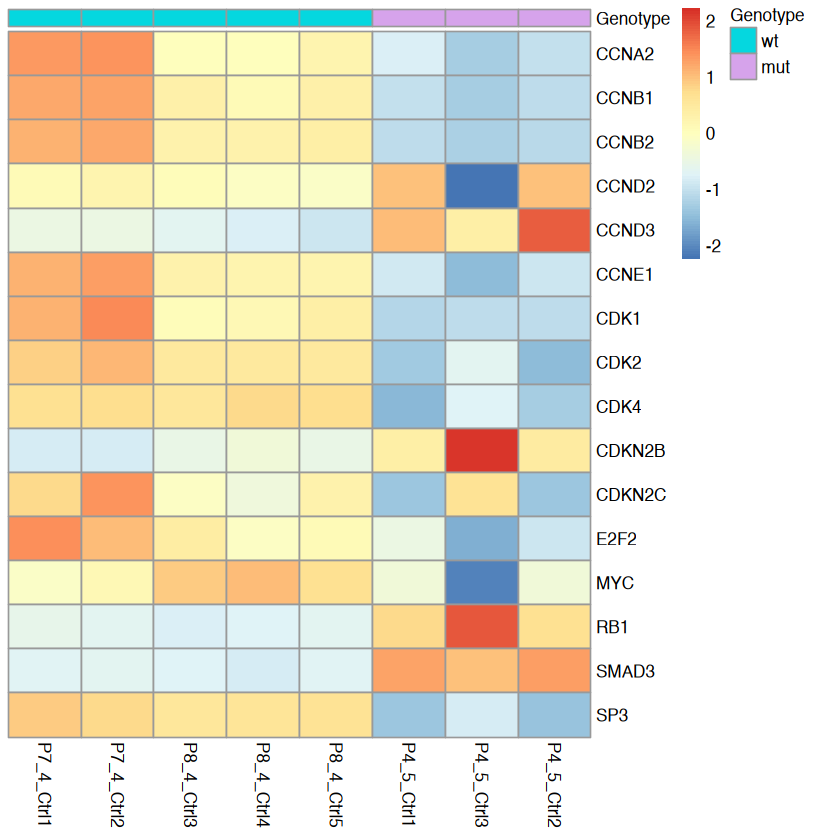

In [74]:
# Create the manual_annotation data frame with only Genotype
manual_annotation <- data.frame(
  Genotype = factor(c("wt", "wt", "wt", "wt", "wt", "wt", "wt", "wt", "wt", "wt", "mut", "mut", "mut", "mut", "mut", "mut")),
  Condition = factor(c("Control", "Control", "Control", "Control", "Control", "LPS", "LPS", "LPS", "LPS", "LPS", "Control", "Control", "Control", "LPS", "LPS", "LPS"))
)

# Define annotation colors for Genotype only
ann_colors <- list(
  Genotype = c("wt" = "#05d7df", "mut" = "#d6a3eb")
)

# Read the cell cycle gene data
cell_cycle_mef <- read.table('mef_cellcyclegenes.txt', header = TRUE)
cell_cycle_lmc <- read.table('lmc_cellcyclegenes.txt', header = TRUE)
colnames(cell_cycle_mef)[1] <- "Gene_name"
colnames(cell_cycle_lmc)[1] <- "Gene_name"

# Combine the gene data and convert gene names to uppercase
cell_cycle_mef_combo <- rbind(cell_cycle_lmc, cell_cycle_mef)
cell_cycle_mef_combo$Gene_name <- toupper(cell_cycle_mef_combo$Gene_name)

# Ensure rownames of countData are uppercase
rownames(countData) <- toupper(rownames(countData))

# Filter the countData to include only genes in the cell cycle list
cell_cycle_res <- intersect(rownames(countData), cell_cycle_mef_combo$Gene_name)
filteredCountData_cellcycle <- countData[cell_cycle_res, ]

# Subset the manual_annotation and filteredCountData_cellcycle to exclude LPS samples
samples_to_keep <- manual_annotation$Condition != "LPS"
filteredCountData_cellcycle <- filteredCountData_cellcycle[, samples_to_keep]
manual_annotation_filtered <- manual_annotation[samples_to_keep, "Genotype", drop = FALSE]

# Set the row names of manual_annotation_filtered to match the column names of filteredCountData_cellcycle
rownames(manual_annotation_filtered) <- colnames(filteredCountData_cellcycle)

# Check for any NA or infinite values and remove them
filteredCountData_cellcycle <- filteredCountData_cellcycle[complete.cases(filteredCountData_cellcycle), ]

# Ensure the data is not empty after filtering
if (nrow(filteredCountData_cellcycle) == 0 || ncol(filteredCountData_cellcycle) == 0) {
  stop("Filtered data contains no rows or columns. Please check your data and filtering criteria.")
}

# Plot the heatmap for the filtered data using only Genotype annotations
pheatmap(filteredCountData_cellcycle, 
         cluster_rows = FALSE, 
         cluster_cols = FALSE, 
         annotation_col = manual_annotation_filtered, 
         show_rownames = TRUE, 
         scale = 'row',
         annotation_colors = ann_colors)



In [75]:
#troubleshoot if needed

nf_kb <- read.table('nf_kb_sites.txt')
colnames(nf_kb)[1] <- "Gene_name"
# Filter the countData to include only genes in the nf_kb list
rownames(countData) <- toupper(rownames(countData))
nf_kb_genes <- intersect(rownames(countData), nf_kb$Gene_name)
filteredCountData <- countData[nf_kb_genes, ]

# Rank genes based on their mean expression levels and select the top 100
meanExpressionLevels <- rowMeans(filteredCountData)
top100Genes <- names(sort(meanExpressionLevels, decreasing = TRUE))[1:50]
filteredCountDataTop100 <- filteredCountData[top100Genes, ]

# Apply further filtering if necessary (you might want to skip this if focusing on top 100 already)
# Example pattern shown in your request - adjust if using this additional filter step
filtered_rows <- grep("^(?!GM|MIR|ENSMUS|RPL|RIK).*$", rownames(filteredCountDataTop100), perl = TRUE)
filteredCountDataTop100Filtered <- filteredCountDataTop100[filtered_rows, ]




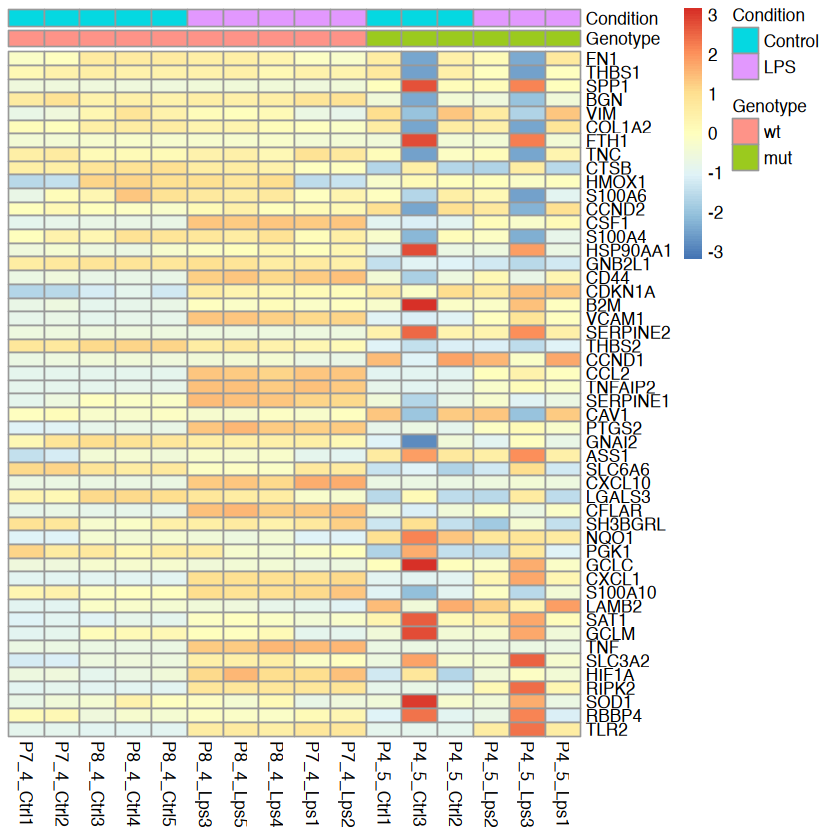

In [76]:
library(pheatmap)

# Create the manual annotation dataframe
manual_annotation <- data.frame(
  Genotype = factor(c("wt", "wt", "wt", "wt", "wt", "wt", "wt", "wt", "wt", "wt", "mut", "mut", "mut", "mut", "mut", "mut")),
  Condition = factor(c("Control", "Control", "Control", "Control", "Control", "LPS", "LPS", "LPS", "LPS", "LPS", "Control", "Control", "Control", "LPS", "LPS", "LPS"))
)

# Define annotation colors
ann_colors <- list(
  Genotype = c("wt" = "#fe9388", "mut" = "#9bca1e"),
  Condition = c("Control" = "#05d8e1", "LPS" = "#e298fe")
)

rownames(manual_annotation) <- colnames(filteredCountDataTop100Filtered)
#plot the heatmap
pheatmap(filteredCountDataTop100Filtered,
         cluster_rows = FALSE,
         cluster_cols = FALSE,
         annotation_col = manual_annotation,
         annotation_colors = ann_colors,
         show_rownames = TRUE,
         scale = "row")

In [77]:
res <- results(dds, name="genotypemut.conditionLPS")

In [78]:
# Correctly filtering genes, accounting for NAs in 'padj'
filtered_genes <- res[!is.na(res$log2FoldChange) & !is.na(res$padj) & res$padj < 0.05, ]


In [79]:
#The next part of code will help obtain the following answer.

I.The effect of treatment in wild-type.[This is for WT, treated compared with untreated.]

1.Genes upregulated with LPS in wild-type samples

2.Genes downregulated with LPS in wild-type samples

In [80]:
res = results(dds, contrast=c("condition", "LPS", "Control"))
ix = which.min(res$padj) # most significant
res <- res[order(res$padj),] # sort
kable(res[1:5,-(3:4)])



|        | baseMean| log2FoldChange| pvalue| padj|
|:-------|--------:|--------------:|------:|----:|
|Bcl2a1b | 1169.982|       3.064283|      0|    0|
|Ccl3    | 4035.521|       5.946324|      0|    0|
|Ccl4    | 2385.701|       5.620336|      0|    0|
|Ccl5    | 2193.676|       8.158562|      0|    0|
|Clec4e  | 1711.188|       7.747770|      0|    0|

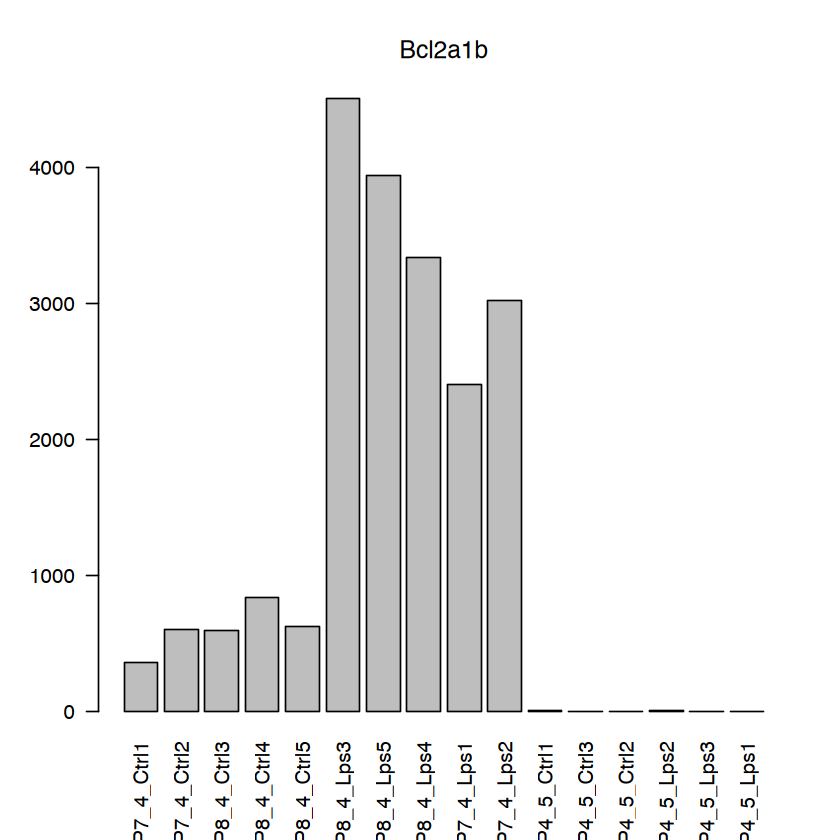

In [81]:
p <- barplot(assay(dds)[ix,],las=2, main=rownames(dds)[ ix  ]  )
#the plot below shows which gene is most prominent and how much it is expressed in each sample.

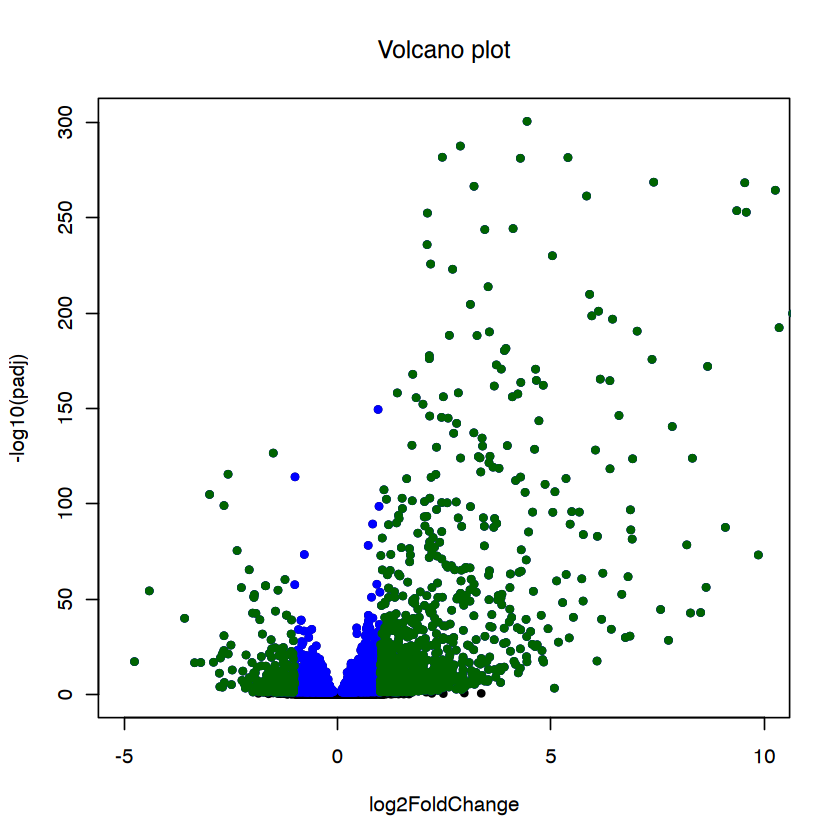

In [82]:
res2 <- res
#reset par
par(mfrow=c(1,1))
# Make a basic volcano plot
with(res2, plot(log2FoldChange, -log10(padj), pch=20, main="Volcano plot", xlim=c(-5,10)))

# Add colored points: blue if padj<0.05, red if log2FC>1 and padj<0.05)
with(subset(res2, padj<.05 ), points(log2FoldChange, -log10(padj), pch=20, col="blue"))
with(subset(res2, padj<.05 & abs(log2FoldChange)>1), points(log2FoldChange, -log10(padj), pch=20, col="dark green"))

In [83]:
#omit null values and only consider entries where adjusted p-value < 0.05.
res2 <- na.omit(res2)
mef_I <- res2
res2_I <- res2[res2$padj < 0.05, ]
res2_I_all <- res2

Warning message:
"One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value..."


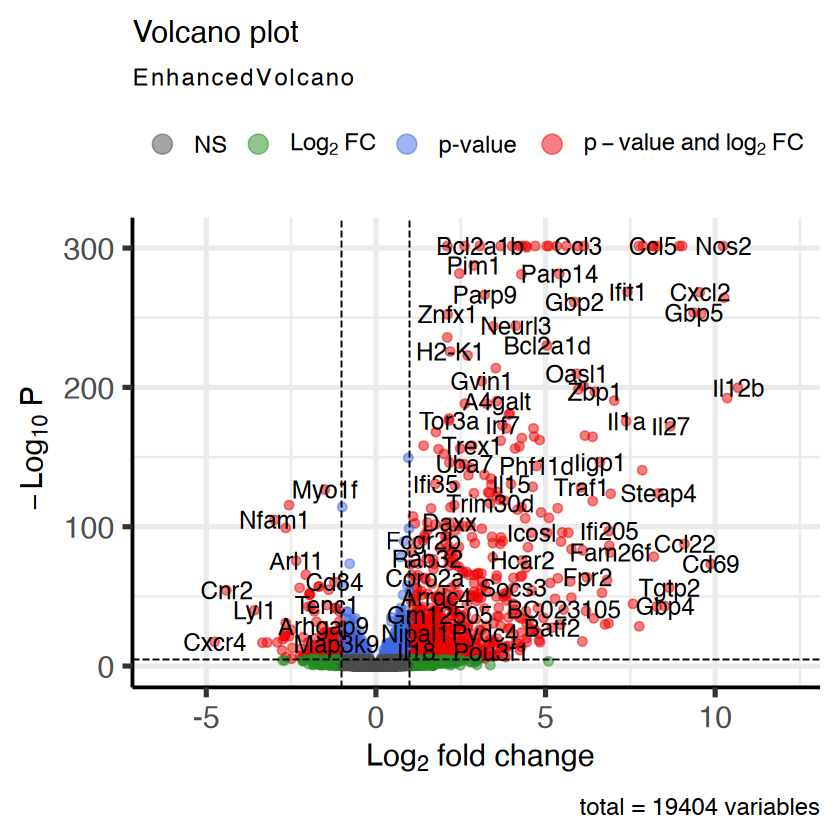

In [84]:
# Number of genes to label
N <- 5  

# Sorting the data frame based on the criteria (e.g., padj)
sorted_indices <- order(res2$padj)

# Initializing labels to NA
res2$labels <- NA

# Select top N genes based on sorted indices
top_N_indices <- sorted_indices[1:N]
filtered_indices <- top_N_indices[grepl("^Gm|-ik$|Mir|^Rps", res2$SYMBOL[top_N_indices])]
num_more <- length(filtered_indices)
next_valid_indices <- sorted_indices[(N + 1):(N + num_more)]
next_valid_indices <- next_valid_indices[!grepl("^Gm|-ik$|Mir|^Rps", res2$SYMBOL[next_valid_indices])]

# Combining the valid top indices and the next valid indices to get top N labels
final_top_N_indices <- c(setdiff(top_N_indices, filtered_indices), next_valid_indices[1:num_more])

# Filtering out NA indices
final_top_N_indices <- final_top_N_indices[!is.na(final_top_N_indices)]
final_top_N_indices <- final_top_N_indices[!is.na(res2$SYMBOL[final_top_N_indices])]

# Checking if any of the final_top_N_indices are NA or if corresponding SYMBOLs are NA
if (any(is.na(final_top_N_indices)) || any(is.na(res2$SYMBOL[final_top_N_indices]))) {
    stop("NA indices detected. Please resolve before proceeding.")
}

# Setting the labels for these final top N indices
res2$labels[final_top_N_indices] <- res2$SYMBOL[final_top_N_indices]

# Creating the EnhancedVolcano plot
EnhancedVolcano(res2,
                lab = rownames(res2),
                x = 'log2FoldChange',
                y = 'padj')


Here above plot suggests upregulated genes(positive Foldchange values) and downregulated genes(negative Foldchange values) in wildtype samples when subjected to LPS treatment.

In [85]:
#Finding DE genes with adjusted p-value < 0.05 and LFC threshold = 0.20 and saving as csv files.

In [86]:
res3 <- res2[complete.cases(res2),]
res3$abs_LFC <- abs(res3$log2FoldChange)
res4 <- res3[res3$abs_LFC > 1, ]
res5 <- res4[res4$padj < 0.05, ]  

res2_I_up <- res2[res2$log2FoldChange > 1 & res2$padj < 0.05, ]
res2_I_down <- res2[res2$log2FoldChange < -1 & res2$padj < 0.05, ]

In [87]:
res2_I$abs_LFC <- abs(res2_I$log2FoldChange)
res2_I_sig <- res2_I[res2_I$abs_LFC > 1, ]
res2_I_sig

log2 fold change (MLE): condition LPS vs Control 
Wald test p-value: condition LPS vs Control 
DataFrame with 1223 rows and 7 columns
               baseMean log2FoldChange     lfcSE      stat     pvalue      padj
              <numeric>      <numeric> <numeric> <numeric>  <numeric> <numeric>
Bcl2a1b         1169.98        3.06428 0.0815532   37.5740          0         0
Ccl3            4035.52        5.94632 0.0897479   66.2558          0         0
Ccl4            2385.70        5.62034 0.0852013   65.9654          0         0
Ccl5            2193.68        8.15856 0.1956929   41.6906          0         0
Clec4e          1711.19        7.74777 0.1459524   53.0842          0         0
...                 ...            ...       ...       ...        ...       ...
Pak7            4.17286       -1.43537  0.555976  -2.58172 0.00983098 0.0491018
Selenbp1       80.23607       -1.26987  0.492018  -2.58094 0.00985306 0.0491867
Doc2b          37.67114       -1.20351  0.466517  -2.57977 0.00988

In [88]:
write.csv(res2_I,'results_DEgenes_MEF_I_2020counts_v1.csv')
write.csv(rownames(res2_I_up),'upregulated_genes_MEF_I.csv')
write.csv(rownames(res2_I_down),'downregulated_genes_MEF_I.csv')

write.csv(res2_I_up,'upregulated_genes_MEF_I_rf.csv')
write.csv(res2_I_down,'downregulated_genes_MEF_I_rf.csv')

Warning message:
"One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value..."


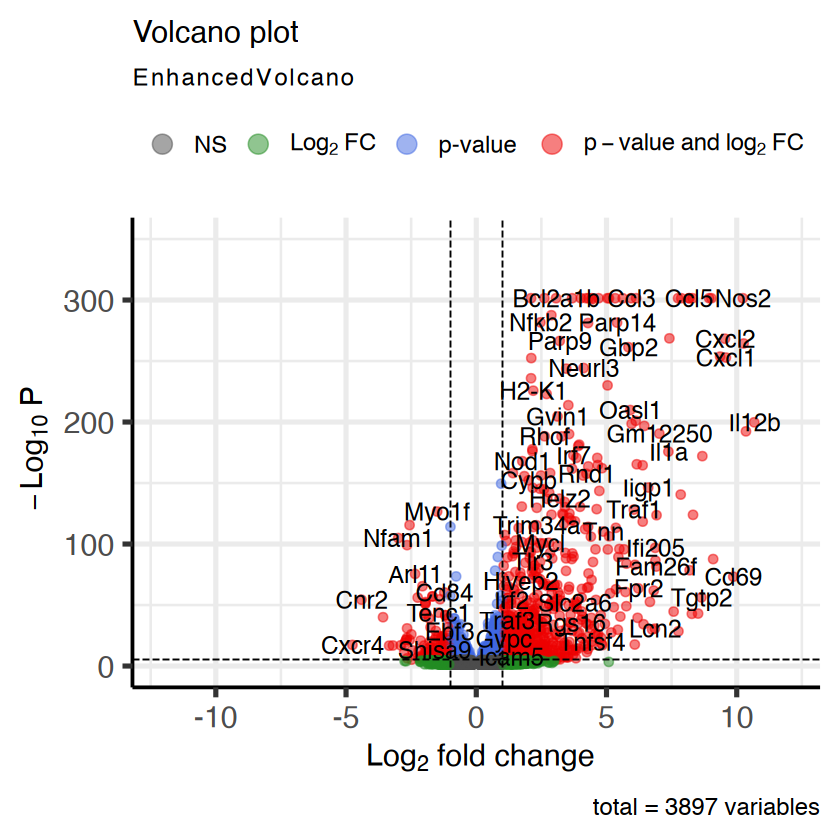

In [89]:
# Number of genes to label
N <- 5  

# Sorting the data frame based on the criteria (e.g., padj)
sorted_indices <- order(res2_I$padj)

# Initializing labels to NA if the 'labels' column doesn't exist
if (!"labels" %in% colnames(res2_I)) {
  res2_I$labels <- NA  # Fixed typo here; changed res5 to res2_I
}

# Selecting top N genes based on sorted indices
top_N_indices <- sorted_indices[1:N]

# Identifying those among the top N that need to be filtered out
filtered_indices <- top_N_indices[grepl("^Gm|-ik$|Mir|^Rpl", res2_I$SYMBOL[top_N_indices])]
num_more <- length(filtered_indices)
next_valid_indices <- sorted_indices[(N + 1):(N + num_more)]
next_valid_indices <- next_valid_indices[!grepl("^Gm|-ik$|Mir|^Rpl", res2_I$SYMBOL[next_valid_indices])]
final_top_N_indices <- c(setdiff(top_N_indices, filtered_indices), next_valid_indices[1:num_more])

# Checking if 'labels' column exists in res2_I before assigning labels
if ("labels" %in% colnames(res2_I)) {
  # Set the labels for these final top N indices, avoiding NA indices
  non_na_indices <- final_top_N_indices[!is.na(res2_I$SYMBOL[final_top_N_indices])]
  res2_I$labels[non_na_indices] <- res2_I$SYMBOL[non_na_indices]
} else {
  cat("The 'labels' column does not exist in res2_I.\n")
}

# Creating the EnhancedVolcano plot using res2_I and its labels
EnhancedVolcano(res2_I,
                lab = rownames(res2_I),
                x = 'log2FoldChange',
                y = 'padj',xlim = c(-12,12),ylim = c(0,350))


II.The effect of treatment in mutant samples [This is for Sp3 knockout,treated compared with untreated ]   


3.Genes upregulated with LPS in Sp3 knockout samples

4.Genes downregulated with LPS in Sp3 knockout samples


In [90]:
res <- results(dds,list(c("condition_LPS_vs_Control","genotypemut.conditionLPS") ))
ix = which.min(res$padj) # most significant
res <- res[order(res$padj),] # sort
kable(res[1:5,-(3:4)])



|       | baseMean| log2FoldChange| pvalue| padj|
|:------|--------:|--------------:|------:|----:|
|Neurl3 | 1396.644|       5.227313|      0|    0|
|Cxcl1  | 7935.192|       8.330495|      0|    0|
|Nos2   | 2629.325|       6.200872|      0|    0|
|Gbp2   | 6562.313|       4.816823|      0|    0|
|Nfkbia | 4246.507|       3.396784|      0|    0|

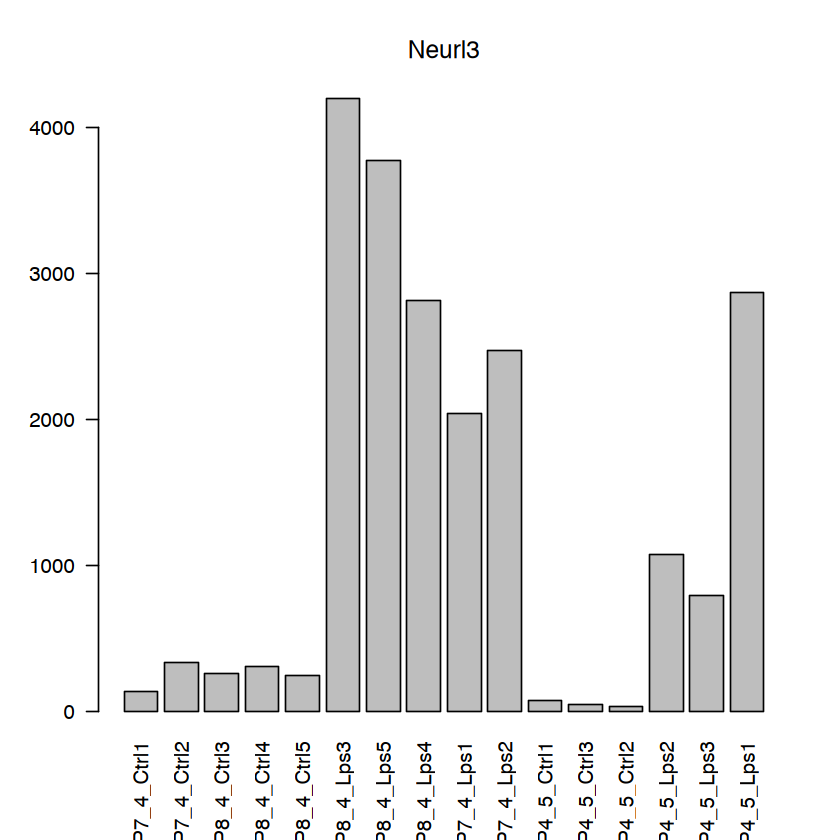

In [91]:
barplot(assay(dds)[ix,],las=2, main=rownames(dds)[ ix  ]  )

In [92]:
res2 <- res
res2 <- na.omit(res2)
mef_II <- res2

In [93]:
#filtering entries where adjusted p-value < 0.05 

res2_II <- res2[res2$padj < 0.05, ]
res2_II_all <- res2

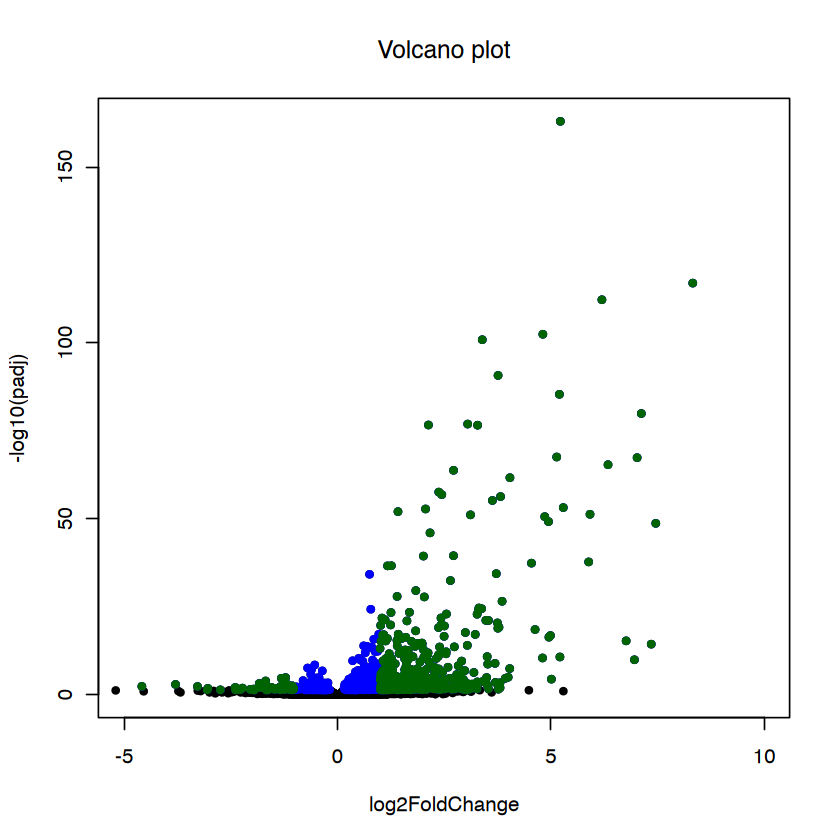

In [94]:
#reset par
par(mfrow=c(1,1))
with(res2, plot(log2FoldChange, -log10(padj), pch=20, main="Volcano plot", xlim=c(-5,10)))
# Add colored points: blue if padj<0.05, red if log2FC>1 and padj<0.05)
with(subset(res2, padj<.05 ), points(log2FoldChange, -log10(padj), pch=20, col="blue"))
with(subset(res2, padj<.05 & abs(log2FoldChange)>1), points(log2FoldChange, -log10(padj), pch=20, col="dark green"))

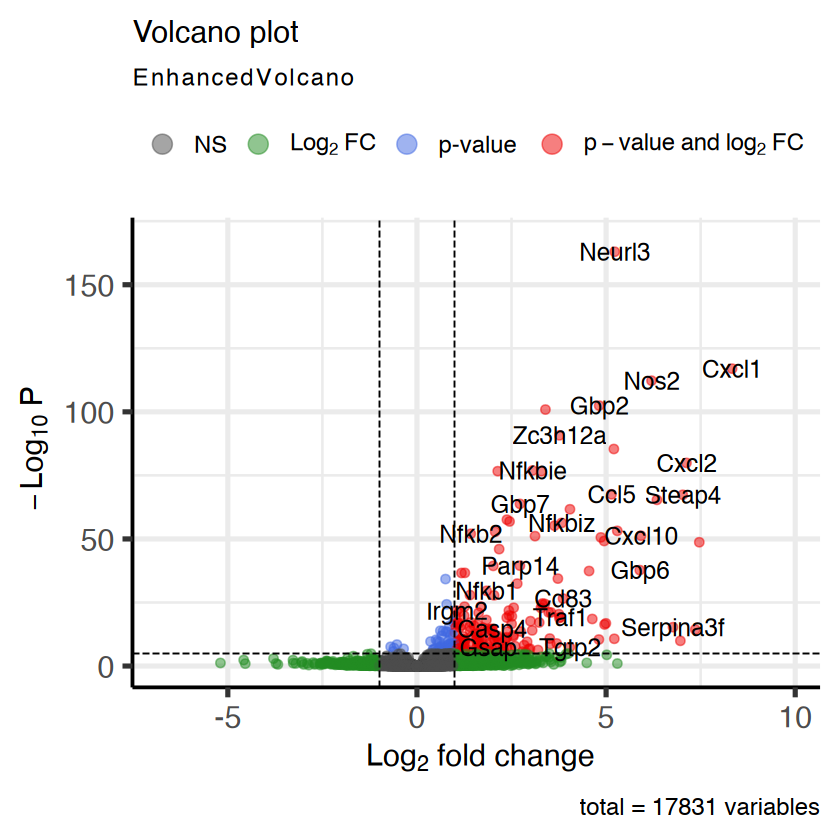

In [95]:
# Number of genes to label
N <- 10  

# Sorting the data frame based on the criteria (e.g., padj)
sorted_indices <- order(res2$padj)

# Initializing labels to NA
res2$labels <- NA

# Selecting top N genes based on sorted indices
top_N_indices <- sorted_indices[1:N]

# Identifying those among the top N that need to be filtered out
filtered_indices <- top_N_indices[grepl("^Gm|-ik$|Mir", res2$SYMBOL[top_N_indices])]
num_more <- length(filtered_indices)
next_valid_indices <- sorted_indices[(N + 1):(N + num_more)]
next_valid_indices <- next_valid_indices[!grepl("^Gm|-ik$|Mir", res2$SYMBOL[next_valid_indices])]
final_top_N_indices <- c(setdiff(top_N_indices, filtered_indices), next_valid_indices[1:num_more])
final_top_N_indices <- final_top_N_indices[!is.na(final_top_N_indices)]
final_top_N_indices <- final_top_N_indices[!is.na(res2$SYMBOL[final_top_N_indices])]

# Checking if any of the final_top_N_indices are NA or if corresponding SYMBOLs are NA
if (any(is.na(final_top_N_indices)) || any(is.na(res2$SYMBOL[final_top_N_indices]))) {
    stop("NA indices detected. Please resolve before proceeding.")
}

# Setting the labels for these final top N indices
res2$labels[final_top_N_indices] <- res2$SYMBOL[final_top_N_indices]

# Creating the EnhancedVolcano plot
EnhancedVolcano(res2,
                lab = rownames(res2),
                x = 'log2FoldChange',
                y = 'padj')


Here above plot suggests upregulated genes(positive Foldchange) and downregulated genes(negative Foldchange) in mutant samples when subjected to LPS treatment

In [96]:
res3 <- res2[complete.cases(res2),]
res2_I_full <- res3
res3$abs_LFC <- abs(res3$log2FoldChange)
res4 <- res3[res3$abs_LFC > 0.20, ]
res5 <- res4[res4$padj < 1, ]  

res2_II_up <- res2[res2$log2FoldChange > 1 & res2$padj < 0.05, ]
res2_II_down <- res2[res2$log2FoldChange < -1 & res2$padj < 0.05, ]

write.csv(res2_II,'results_DEgenes_MEF_II_2020counts_v1.csv')
write.csv(rownames(res2_II_up),'upregulated_genes_MEF_II.csv')
write.csv(rownames(res2_II_down),'downregulated_genes_MEF_II.csv')


write.csv(res2_II_up,'upregulated_genes_MEF_II_rf.csv')
write.csv(res2_II_down,'downregulated_genes_MEF_II_rf.csv')


In [97]:
res2_II$abs_LFC <- abs(res2_II$log2FoldChange)
res2_II_sig <- res2_II[res2_II$abs_LFC > 1, ]
res2_II_sig

log2 fold change (MLE): condition_LPS_vs_Control+genotypemut.conditionLPS effect 
Wald test p-value: condition_LPS_vs_Control+genotypemut.conditionLPS effect 
DataFrame with 418 rows and 7 columns
          baseMean log2FoldChange     lfcSE      stat       pvalue         padj
         <numeric>      <numeric> <numeric> <numeric>    <numeric>    <numeric>
Neurl3     1396.64        5.22731  0.189235   27.6234 5.82091e-168 1.03793e-163
Cxcl1      7935.19        8.33050  0.355147   23.4565 1.13573e-121 1.01256e-117
Nos2       2629.33        6.20087  0.269945   22.9709 9.11894e-117 5.42000e-113
Gbp2       6562.31        4.81682  0.219402   21.9543 7.88046e-107 3.51291e-103
Nfkbia     4246.51        3.39678  0.155952   21.7810 3.51635e-105 1.25400e-101
...            ...            ...       ...       ...          ...          ...
Cldn15     34.3178        1.41302  0.465483   3.03560   0.00240058    0.0477198
Mcc      1193.4357        1.09311  0.360153   3.03513   0.00240429    0.0477405
Irs

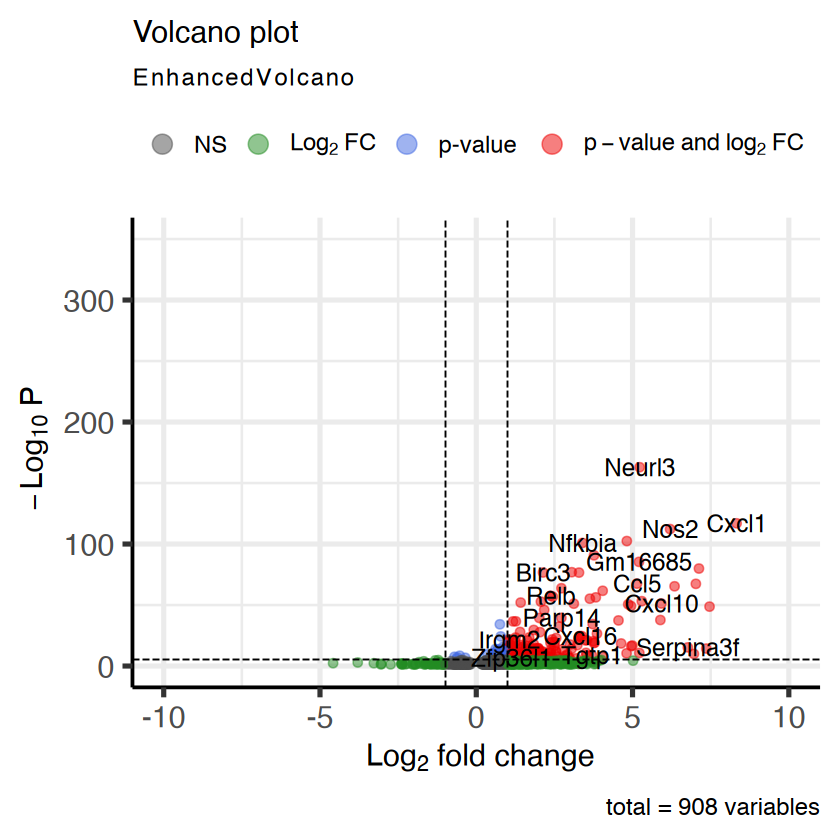

In [98]:
# Number of genes to label
N <- 10  

# Sorting the data frame based on the criteria (e.g., padj)
sorted_indices <- order(res2_II$padj)

# Initializing labels to NA if the 'labels' column doesn't exist
if (!"labels" %in% colnames(res2_II)) {
  res2_II$labels <- NA  # Changed res2_I to res2_II
}

# Selecting top N genes based on sorted indices
top_N_indices <- sorted_indices[1:N]

# Identifying those among the top N that need to be filtered out
filtered_indices <- top_N_indices[grepl("^Gm|Rik$|Mir", res2_II$SYMBOL[top_N_indices])]  # Changed res2_I to res2_II

num_more <- length(filtered_indices)
next_valid_indices <- sorted_indices[(N + 1):(N + num_more)]
next_valid_indices <- next_valid_indices[!grepl("^Gm|Rik$|Mir", res2_II$SYMBOL[next_valid_indices])]  # Changed res2_I to res2_II
final_top_N_indices <- c(setdiff(top_N_indices, filtered_indices), next_valid_indices[1:num_more])

# Checking if 'labels' column exists in res2_II before assigning labels
if ("labels" %in% colnames(res2_II)) {  # Changed res2_I to res2_II
  # Set the labels for these final top N indices, avoiding NA indices
  non_na_indices <- final_top_N_indices[!is.na(res2_II$SYMBOL[final_top_N_indices])]  # Changed res2_I to res2_II
  res2_II$labels[non_na_indices] <- res2_II$SYMBOL[non_na_indices]  # Changed res2_I to res2_II
} else {
  cat("The 'labels' column does not exist in res2_II.\n")  # Changed res2_I to res2_II
}

# Creating the EnhancedVolcano plot using res2_II and its labels
EnhancedVolcano(res2_II,  # Changed res2_I to res2_II
                lab = rownames(res2_II),  # Changed res2_I to res2_II
                x = 'log2FoldChange',
                y = 'padj',ylim = c(0,350),xlim = c(-10,10))


In [99]:
lmc_data <- read.csv('merged_LMC_I_II_III_deseq2results.csv')

In [100]:
lmc_data$X <- NULL

In [101]:
res = results(dds, contrast=c("genotype","mut","wt"))
ix = which.min(res$padj) # most significant
res <- res[order(res$padj),] # sort
kable(res[1:5,-(3:4)])



|       |  baseMean| log2FoldChange| pvalue| padj|
|:------|---------:|--------------:|------:|----:|
|Mpeg1  | 5590.2821|      -8.921650|      0|    0|
|Xist   | 9450.0934|       9.862630|      0|    0|
|Laptm5 | 2621.6106|      -7.952874|      0|    0|
|Cd84   |  760.7402|      -5.430426|      0|    0|
|Tbx4   |  463.9069|       7.077411|      0|    0|

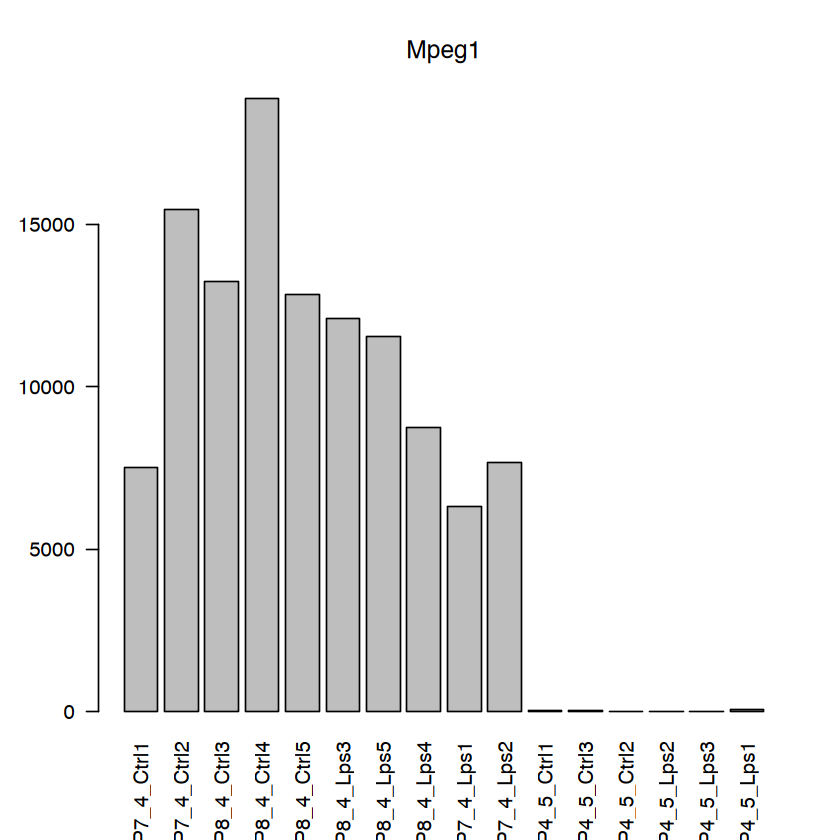

In [102]:
barplot(assay(dds)[ix,],las=2, main=rownames(dds)[ ix  ]  )

In [103]:
res2 <- res
res2 <- na.omit(res2)
mef_III <- res2

In [104]:
res2_III <- res2[res2$padj < 0.05, ]
res2_III_all <- res2

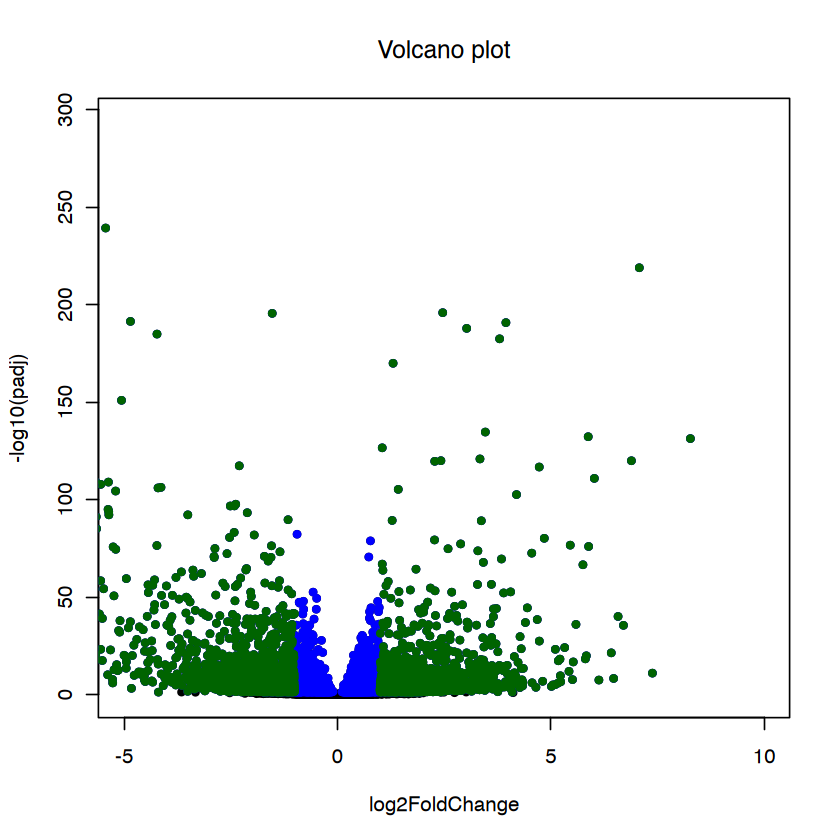

In [105]:
#reset par
par(mfrow=c(1,1))
with(res2, plot(log2FoldChange, -log10(padj), pch=20, main="Volcano plot", xlim=c(-5,10)))

# Add colored points: blue if padj<0.05, red if log2FC>1 and padj<0.05)
with(subset(res2, padj<.05 ), points(log2FoldChange, -log10(padj), pch=20, col="blue"))
with(subset(res2, padj<.05 & abs(log2FoldChange)>1), points(log2FoldChange, -log10(padj), pch=20, col="dark green"))

Warning message:
"One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value..."


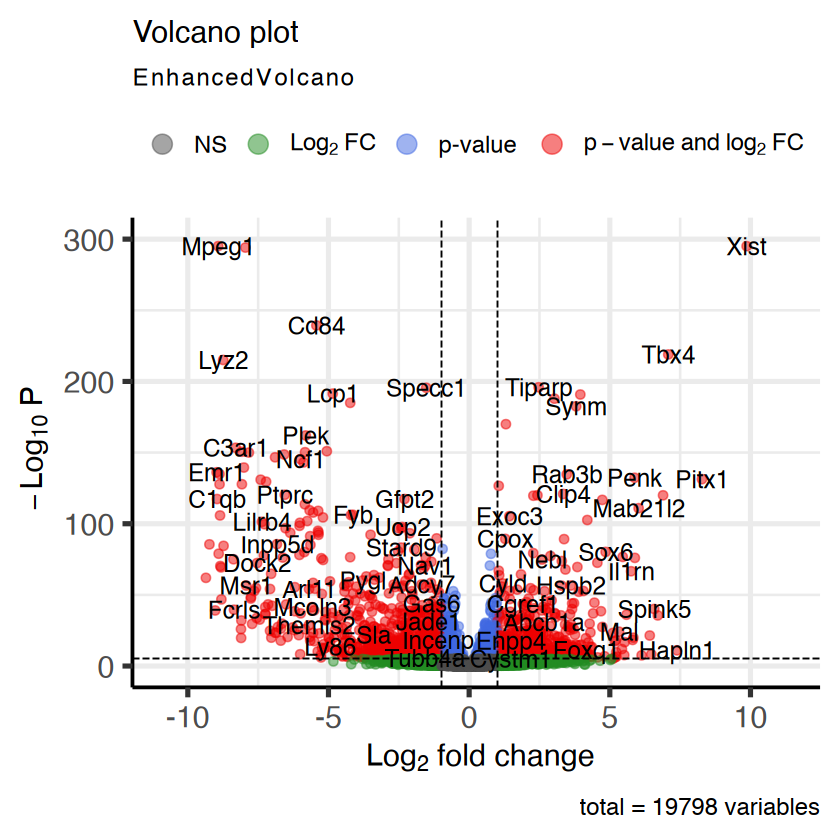

In [106]:
# Number of genes to label
N <- 10  

# Sorting the data frame based on the criteria (e.g., padj)
sorted_indices <- order(res2$padj)

# Initializing labels to NA
res2$labels <- NA

# Selecting top N genes based on sorted indices
top_N_indices <- sorted_indices[1:N]

# Identifying those among the top N that need to be filtered out
filtered_indices <- top_N_indices[grepl("^Gm|Rik$|Mir|^Rpl", res2$SYMBOL[top_N_indices])]

# Identifying how many more genes we need to pick
num_more <- length(filtered_indices)

# Picking the next top-most genes that are valid
next_valid_indices <- sorted_indices[(N + 1):(N + num_more)]
next_valid_indices <- next_valid_indices[!grepl("^Gm|Rik$|Mir|^Rpl", res2$SYMBOL[next_valid_indices])]

# Combining the valid top indices and the next valid indices to get top N labels
final_top_N_indices <- c(setdiff(top_N_indices, filtered_indices), next_valid_indices[1:num_more])

# Filtering out NA indices
final_top_N_indices <- final_top_N_indices[!is.na(final_top_N_indices)]
final_top_N_indices <- final_top_N_indices[!is.na(res2$SYMBOL[final_top_N_indices])]

# Checking if any of the final_top_N_indices are NA or if corresponding SYMBOLs are NA
if (any(is.na(final_top_N_indices)) || any(is.na(res2$SYMBOL[final_top_N_indices]))) {
    stop("NA indices detected. Please resolve before proceeding.")
}

# Setting the labels for these final top N indices
res2$labels[final_top_N_indices] <- res2$SYMBOL[final_top_N_indices]

# Creating the EnhancedVolcano plot
EnhancedVolcano(res2,
                lab = rownames(res2),
                x = 'log2FoldChange',
                y = 'padj')


Here above results suggest upregulated genes(positive Foldchange) and downregulated genes(negative Foldchange)in
Wildtype samples compared to mutant without considering control/LPS treatment.


In [107]:
res3 <- res2[complete.cases(res2),]
res2_II_full <- res3
res3$abs_LFC <- abs(res3$log2FoldChange)
res4 <- res3[res3$abs_LFC > 0.20, ]
res5 <- res4[res4$padj < 0.05, ]  


res3_up <- res2[res2$log2FoldChange > 1 & res2$padj < 0.05, ]
res3_down <- res2[res2$log2FoldChange < -1 & res2$padj < 0.05, ]

write.csv(res2_III,'MEF_III_DEgenes.csv')
write.csv(rownames(res3_up),'upregulated_genes_MEF_III.csv')
write.csv(rownames(res3_down),'downregulated_genes_MEF_III.csv')


write.csv(res3_up,'upregulated_genes_MEF_III_rf.csv')
write.csv(res3_down,'downregulated_genes_MEF_III_rf.csv')

res3_up_v <- res2[res2$log2FoldChange > 0 & res2$padj < 0.05, ]
res3_down_v <- res2[res2$log2FoldChange < 0 & res2$padj < 0.05, ]

write.csv(rownames(res3_up_v),'upregulated_genes_MEF_III_venndiagram.csv')
write.csv(rownames(res3_down_v),'downregulated_genes_MEF_III_venndiagram.csv')

In [108]:
# Load required packages
library(plotly)
library(htmltools)

DE_results <- res2_III
# Ensure gene names are uppercase
rownames(countData2) <- toupper(rownames(countData2))
rownames(DE_results) <- toupper(rownames(DE_results))

# Filter to only genes present in countData1
gene_list <- rownames(DE_results)
gene_list <- gene_list[gene_list %in% rownames(countData2)]

# Subset countData1 accordingly
countData3 <- countData2[gene_list, , drop = FALSE]

# Extract sample metadata
sample_ids <- colnames(countData3)
Group <- groups
Genotype <- ifelse(grepl("wt", Group, ignore.case = TRUE), "WT", "MUT")
Condition <- ifelse(grepl("Control", Group, ignore.case = TRUE), "Control", "LPS")

In [109]:
countData3

P7_4_Ctrl1 P7_4_Ctrl2 P8_4_Ctrl3 P8_4_Ctrl4 P8_4_Ctrl5 P8_4_Lps3
MPEG1           7515      15457      13254      18878      12842      12102    
XIST              31         54         52         46         37         56    
LAPTM5          3809       7915       7474      10277       6708       5005    
CD84            1367       2789       2586       3580       2486        998    
TBX4              17         18         10         15          8         10    
LYZ2           37214      75060      66158      92654      64966      50418    
TIPARP           687       1312       1504       2056       1419       1573    
SPECC1          1944       3999       3923       5085       3422       3094    
LCP1            3767       7710       6003       8546       6003      14610    
AHR              119        283        232        314        206        329    
SLITRK5          150        287        353        410        311        148    
SEMA4D           734       1624       1481       2004       1340       1840    
SYNM              71        174        183        261        172        141    
SLC33A1          852       1796       1725       2508       1612       1586    
PLEK            2510       4845       4193       6048       4115      13601    
C3AR1           2306       4656       4129       5663       3870       3551    
MMP12           2461       4839       6406       8886       6385       5102    
CD36            2067       4284       3713       5090       3409       2148    
CSF1R           3323       6623       5548       7631       5163       4006    
CYBB            1935       3971       3250       4475       3144      11799    
PIRB            1061       2014       2145       2899       2000       1950    
UTY             1092       2295       2272       3115       2221       1625    
NCF1             888       1807       1584       2327       1504       3869    
TREM2           1338       2682       2995       4417       2699       1496    
NCKAP1L         1777       3572       3290       4462       3092       2992    
EMR1            2623       5550       4961       6690       4742       6503    
DDX3Y           2425       4847       4786       6376       4443       4279    
RAB3B             43         99        128        145         86         77    
PENK              75        201        111        149         74        190    
PITX1              2          5          4          7          4          1    
⋮              ⋮          ⋮          ⋮          ⋮          ⋮          ⋮        
4833420G17RIK    837       1740        1700       2405       1517      1087    
GM13091           13         24          31         40         32        15    
KLHL20          1133       2194        2205       2976       1862      1619    
PSAP           47417      99285      121891     167527     104980     89671    
BACH2OS           10         17          19         43         16         7    
ZFP386           547       1110        1048       1420       1020       765    
ENPP1            327        678         505        775        544       408    
TTC39D             6         14          10          9          7         4    
CASP12           479        911         735        962        699       810    
SCPEP1OS          70        141         138        222        110        64    
CASQ1             10         25          27         35         30        24    
SUGT1           1447       3098        2890       4126       2802      2808    
CAAA01205117.1     1         29          60          1         69         1    
TMEM154          308        558         578        935        532       364    
PHLDB1          3707       7988        9177      13224       7687     12256    
FAM73B           629       1217        1387       1801       1102      1056    
MAST1             44         83         142        174         94        61    
PIP5K1B           13         19          36         41         26        26    
ZFP790         

In [110]:
res2_III_hmap <- res2_III
res2_III_hmap$abs_LFC <- abs(res2_III$log2FoldChange)
res2_III_hmap <- res2_III_hmap[res2_III_hmap$abs_LFC > 2, ]
#res2_III_hmap <- res2_III_hmap[res2_III_hmap$abs_LFC > 3, ]

In [111]:
nrow(res2_III_hmap)

[1] 1222

In [112]:
columns_without_LPS <- !grepl("Lps", names(countData1))

# Select only those columns
countData1_onlycontrol <- countData1[, columns_without_LPS]

In [113]:
MEF_DEgenes_III <- intersect(rownames(countData1_onlycontrol), rownames(res2_III_hmap))

In [114]:
length(MEF_DEgenes_III)

[1] 1222

[1] 1222

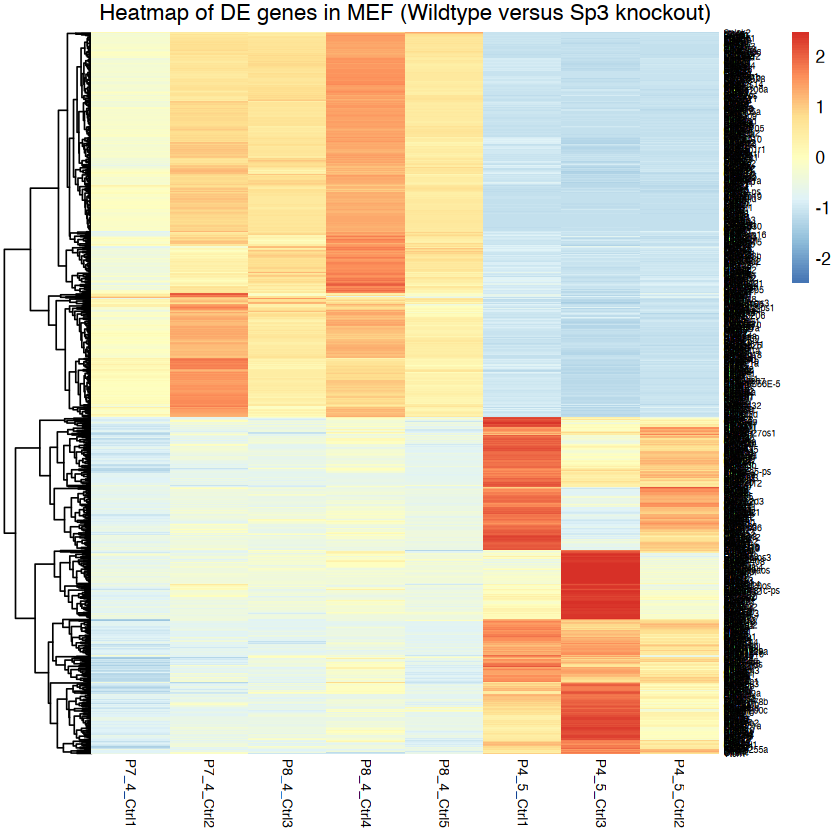

In [115]:
filtered_countdata <- countData1_onlycontrol[MEF_DEgenes_III, ]
nrow(filtered_countdata)
filtered_countdata_matrix <- as.matrix(filtered_countdata)

# Define the pattern to remove unwanted genes
pattern <- "^(Gm|MIR|ENSMUS|Rpl)|Rik$|^[A-Z]+$|\\."
rows_to_keep <- grep(pattern, rownames(filtered_countdata_matrix), invert = TRUE, ignore.case = TRUE)

# Further filter to keep only the first 500 after removing unwanted genes
filtered_matrix <- filtered_countdata_matrix[rows_to_keep, ]

# Save the filtered matrix to CSV
write.csv(filtered_matrix, "filter_MEF.csv")

# Generate heatmap and extract clustering information, reducing font size
heatmap_result <- pheatmap(filtered_matrix, 
                           scale = "row",
                           cluster_cols = FALSE, # Do not cluster columns
                           show_rownames = TRUE,
                           show_colnames = TRUE,
                           main = "Heatmap of DE genes in MEF (Wildtype versus Sp3 knockout)",
                           fontsize_row = 5,   # Adjust row label font size
                           fontsize_col = 8,   # Adjust column label font size
                           width = 20,         # Width of the plot in inches
                           height = 40)        # Height of the plot in inches

# Extract clustering order of rows
clustered_order <- heatmap_result$tree_row$order

# Reorder matrix according to clustering order
filtered_matrix_ordered <- filtered_matrix[clustered_order, ]

# Save reordered matrix to CSV
write.csv(filtered_matrix_ordered, "filter_MEF_ordered.csv")




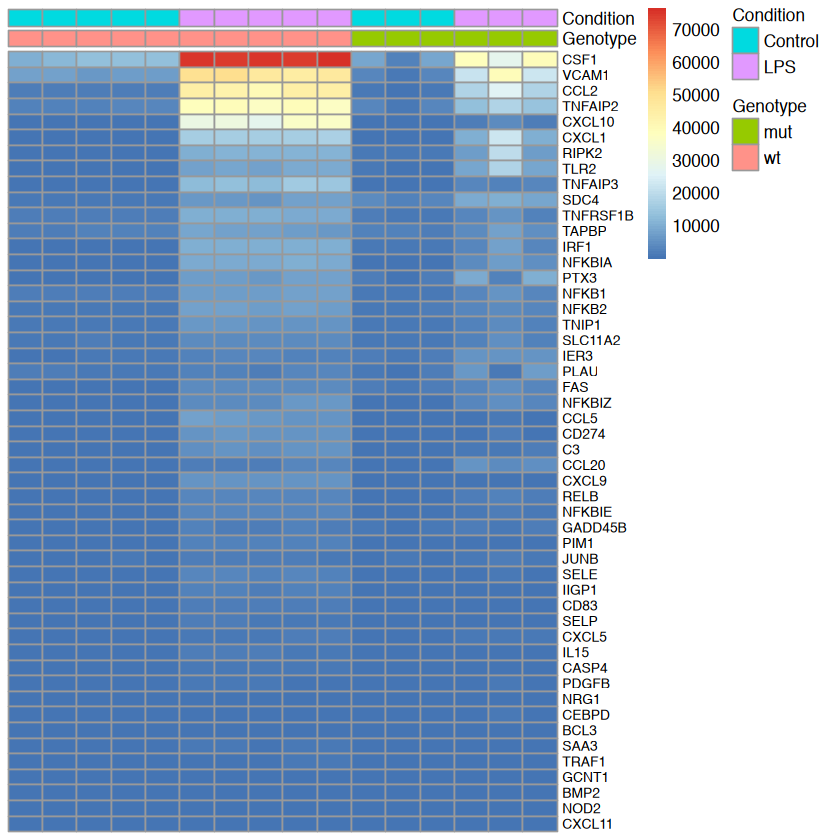

In [116]:

# Convert row names to uppercase to match case insensitivity
rownames(countData) <- toupper(rownames(countData))
rownames(res2_II_sig) <- toupper(rownames(res2_II_sig))
nf_kb$Gene_name <- toupper(nf_kb$Gene_name)  # Ensuring case consistency

common_genes_sig_II <- intersect(rownames(countData), rownames(res2_II_sig))


# Also intersect with nf_kb gene names
common_genes_nf_kb <- intersect(rownames(countData), nf_kb$Gene_name)

# Get the intersection of the two lists to find genes common in both
common_genes_final <- intersect(common_genes_sig_II, common_genes_nf_kb)

# Filter countData to include only rows that have genes present in both res2_I_sig and nf_kb
filteredCountData <- countData[common_genes_final, ]

# Further filter rows to exclude certain gene name prefixes
filtered_rows <- grep("^(?!GM|MIR|ENSMUS|RPL|RIK).*$", rownames(filteredCountData), perl = TRUE)
filteredCountDataFiltered <- filteredCountData[filtered_rows, ]

meanExpressionLevels <- rowMeans(filteredCountDataFiltered)

# Sort genes by mean expression levels in decreasing order and select the top 50
top50Genes <- names(sort(meanExpressionLevels, decreasing = TRUE))[1:50]

# Filter the data to include only these top 50 genes
top50FilteredData <- filteredCountDataFiltered[top50Genes, ]

# Plot the heatmap of the top 50 filtered countData
pheatmap(top50FilteredData,
         cluster_rows = FALSE,
         cluster_cols = FALSE,
         annotation_col = as.data.frame(manual_annotation),  # Ensure this is defined or modify as needed
         show_rownames = TRUE,
         show_colnames = FALSE,  # Hiding column names
       #  scale = "row",
         fontsize_row = 8)

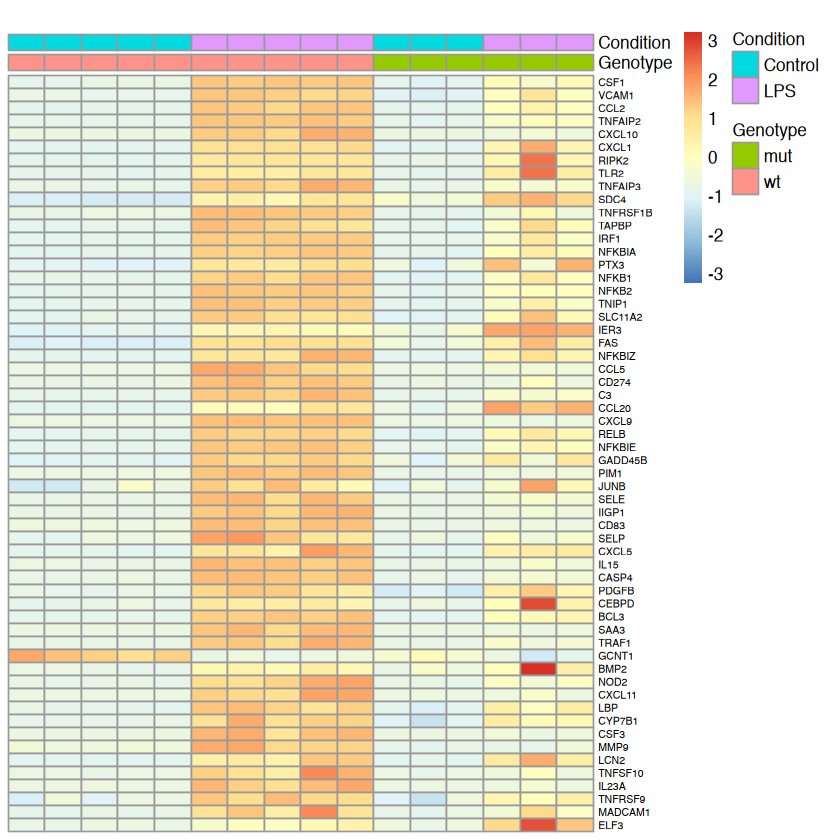

In [117]:

# Convert row names to uppercase to match case insensitivity
rownames(countData) <- toupper(rownames(countData))
rownames(res2_I_sig) <- toupper(rownames(res2_I_sig))
rownames(res2_II_sig) <- toupper(rownames(res2_II_sig))
nf_kb$Gene_name <- toupper(nf_kb$Gene_name)  # Ensuring case consistency

# Intersect gene names across different datasets
common_genes_I_sig <- intersect(rownames(countData), rownames(res2_I_sig))
common_genes_II_sig <- intersect(rownames(countData), rownames(res2_II_sig))
common_genes_nf_kb <- intersect(rownames(countData), nf_kb$Gene_name)

# Combine intersections to find genes common across all conditions
common_genes_final <- Reduce(intersect, list(common_genes_I_sig, common_genes_II_sig, common_genes_nf_kb))

# Filter countData to include only rows that have genes present in all intersections
filteredCountData <- countData[common_genes_final, ]

# Further filter rows to exclude certain gene name prefixes
filtered_rows <- grep("^(?!GM|MIR|ENSMUS|RPL|RIK).*$", rownames(filteredCountData), perl = TRUE)
filteredCountDataFiltered <- filteredCountData[filtered_rows, ]

# Calculate mean expression levels
meanExpressionLevels <- rowMeans(filteredCountDataFiltered)

# Sort genes by mean expression levels in decreasing order and select the top 50
top50Genes <- names(sort(meanExpressionLevels, decreasing = TRUE))#[1:50]

# Filter the data to include only these top 50 genes
top50FilteredData <- filteredCountDataFiltered[top50Genes, ]

# Optional: Define or calculate any specific annotation for columns if needed
# manual_annotation <- data.frame(Condition = c("Control", "Treatment"), row.names = colnames(top50FilteredData))



# Plot the heatmap of the top 50 filtered countData
pheatmap(top50FilteredData,
         cluster_rows = FALSE,
         cluster_cols = FALSE,
         annotation_col = as.data.frame(manual_annotation),  # Ensure this is defined or modify as needed
         show_rownames = TRUE,
         show_colnames = FALSE,  # Hiding column names
         scale = "row",
         fontsize_row = 6,
         main = "")

In [118]:
csv1 <- read.csv('gene_list_MEF_LMC_comparison_heatmap.csv',header = FALSE)

In [119]:
colnames(csv1)[1] <- "Gene_name"

In [120]:
csv1

Gene_name
1  S1pr3    
2  Ska1     
3  Ccna2    
4  Esco2    
5  Ect2     
6  Grik1    
7  Clspn    
8  Top2a    
9  Aoc3     
10 Iqgap3   
11 Pbk      
12 E2f8     
13 Depdc1a  
14 Casc5    
15 Depdc1b  
16 Efcab11  
17 Anln     
18 Neil3    
19 Pole     
20 Birc5    
21 Kif14    
22 Prc1     
23 Uhrf1    
24 Bub1b    
25 Aurka    
26 Mcm10    
27 Kif20b   
28 Kif20a   
29 Ncapd2   
30 BC030867 
⋮  ⋮        
40 Cep55    
41 Ndc80    
42 Lmnb1    
43 Prr11    
44 Shcbp1   
45 Dtl      
46 Troap    
47 Knstrn   
48 Asf1b    
49 Melk     
50 Nusap1   
51 Kif4     
52 Nuf2     
53 Kif2c    
54 Cenpe    
55 Kif11    
56 Cenpf    
57 Hmmr     
58 Kif15    
59 Mki67    
60 Ckap2l   
61 Kif23    
62 Bub1     
63 Sgol1    
64 Tmem51   
65 Aspm     
66 Espl1    
67 Ccnb1    
68 Kntc1    
69 Cdkn3

Total columns before filtering: 16 
Columns removed: 6, 7, 8, 9, 10, 13, 14, 15, 16 
Columns kept: 1, 2, 3, 4, 5, 11, 12 
Total columns after filtering: 7 


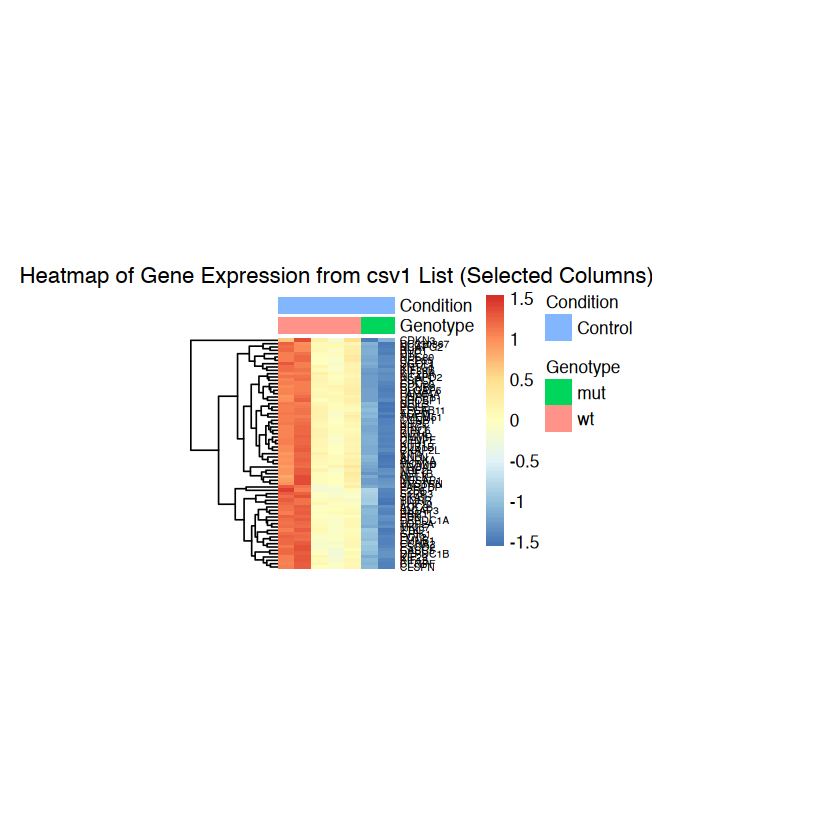

In [121]:
# Ensure csv1 is loaded into the environment
# If not, you may need to load it first:
# csv1 <- read.csv("path/to/your/csv1.csv")

# Convert row names to uppercase to match case insensitivity
rownames(countData) <- toupper(rownames(countData))
csv1$Gene_name <- toupper(csv1$Gene_name)  # Assuming the column is named Gene_name

# Filter countData to include only genes present in csv1
filteredCountData <- countData[rownames(countData) %in% csv1$Gene_name, ]

# Further filter rows to exclude certain gene name prefixes
filtered_rows <- grep("^(?!GM|MIR|ENSMUS|RPL|RIK).*$", rownames(filteredCountData), perl = TRUE)
filteredCountDataFiltered <- filteredCountData[filtered_rows, ]

# Calculate mean expression levels
meanExpressionLevels <- rowMeans(filteredCountDataFiltered)

# Sort genes by mean expression levels in decreasing order
sortedGenes <- names(sort(meanExpressionLevels, decreasing = TRUE))

# Intersect sorted genes with csv1 gene list to maintain order
finalGeneList <- intersect(sortedGenes, csv1$Gene_name)

# Filter the data to include only these genes
finalFilteredData <- filteredCountDataFiltered[finalGeneList, ]

# Flexibly remove columns based on the actual number of columns
total_cols <- ncol(finalFilteredData)
columns_to_remove <- c(6:10, 13:16)
columns_to_remove <- columns_to_remove[columns_to_remove <= total_cols]
columns_to_keep <- setdiff(1:total_cols, columns_to_remove)

# Apply the column filter
finalFilteredData <- finalFilteredData[, columns_to_keep]

# Print information about the filtering process
cat("Total columns before filtering:", total_cols, "\n")
cat("Columns removed:", paste(columns_to_remove, collapse=", "), "\n")
cat("Columns kept:", paste(columns_to_keep, collapse=", "), "\n")
cat("Total columns after filtering:", ncol(finalFilteredData), "\n")

# Recalculate manual_annotation if it's based on column names
# manual_annotation <- data.frame(Condition = c(...), row.names = colnames(finalFilteredData))

# Plot the heatmap with thinner boxes and removed columns
pheatmap(finalFilteredData,
         cluster_rows = TRUE,
         cluster_cols = FALSE,
         annotation_col = as.data.frame(manual_annotation),  # Ensure this is defined or modify as needed
         show_rownames = TRUE,
         show_colnames = FALSE,  # Hiding column names
         scale = "row",
         fontsize_row = 6,
         cellwidth = 10,  # Adjust this value to make boxes thinner horizontally
         cellheight = 2,  # Adjust this value to make boxes thinner vertically
         main = "Heatmap of Gene Expression from csv1 List (Selected Columns)")

In [122]:
length(common_genes_final)

[1] 58

In [123]:
# Convert row names to uppercase to match case insensitivity
rownames(countData) <- toupper(rownames(countData))
rownames(res2_I_sig) <- toupper(rownames(res2_I_sig))
rownames(res2_II_sig) <- toupper(rownames(res2_II_sig))
nf_kb$Gene_name <- toupper(nf_kb$Gene_name)

In [124]:
# Intersect gene names across different datasets
common_genes_I_sig <- intersect(rownames(countData), rownames(res2_I_sig))
common_genes_II_sig <- intersect(rownames(countData), rownames(res2_II_sig))
common_genes_nf_kb <- intersect(rownames(countData), nf_kb$Gene_name)

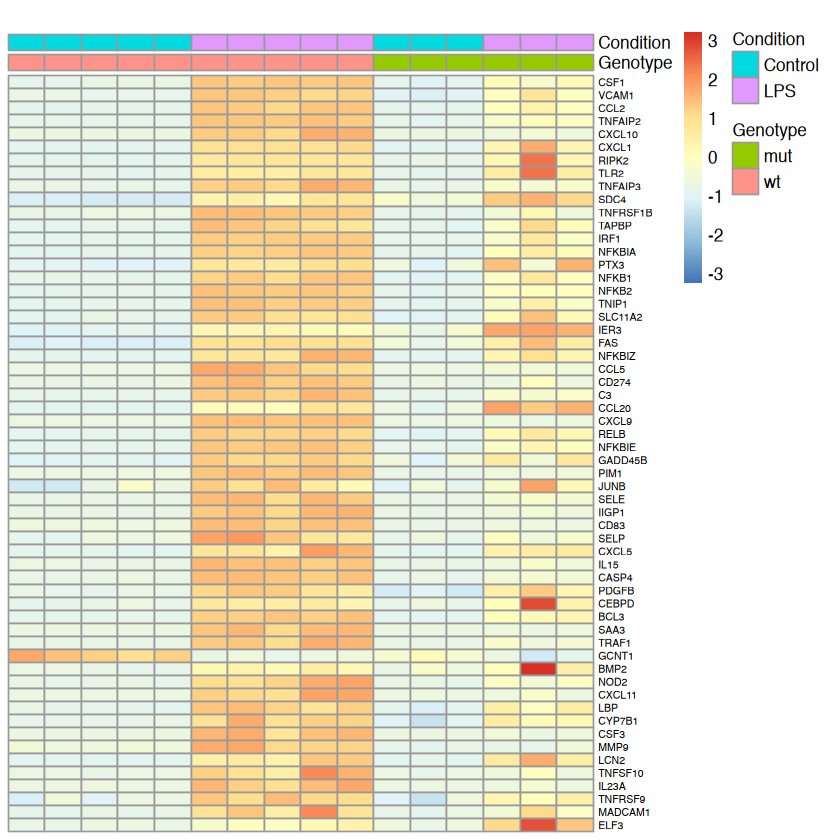

In [125]:
# Combine intersections to find genes common across all conditions
common_genes_final <- Reduce(intersect, list(common_genes_I_sig, common_genes_II_sig, common_genes_nf_kb))

# Filter countData to include only rows that have genes present in all intersections
filteredCountData <- countData[common_genes_final, ]

# Further filter rows to exclude certain gene name prefixes
filtered_rows <- grep("^(?!GM|MIR|ENSMUS|RPL|RIK).*$", rownames(filteredCountData), perl = TRUE)
filteredCountDataFiltered <- filteredCountData[filtered_rows, ]

# Calculate mean expression levels
meanExpressionLevels <- rowMeans(filteredCountDataFiltered)

# Sort genes by mean expression levels in decreasing order and select the top 50
top50Genes <- names(sort(meanExpressionLevels, decreasing = TRUE))#[1:50]

# Filter the data to include only these top 50 genes
top50FilteredData <- filteredCountDataFiltered[top50Genes, ]

# Optional: Define or calculate any specific annotation for columns if needed
# manual_annotation <- data.frame(Condition = c("Control", "Treatment"), row.names = colnames(top50FilteredData))

# Plot the heatmap of the top 50 filtered countData
pheatmap(top50FilteredData,
         cluster_rows = FALSE,
         cluster_cols = FALSE,
         annotation_col = as.data.frame(manual_annotation),  # Ensure this is defined or modify as needed
         show_rownames = TRUE,
         show_colnames = FALSE,  # Hiding column names
         scale = "row",
         fontsize_row = 6,
         main = "")

In [126]:
homeobox <- read.csv('homebox_gene_list.csv',header = FALSE)
colnames(homeobox) <- "Gene_name"


irf <- read.csv('irf_gene_names.txt',header = FALSE)
colnames(irf) <- "Gene_name"

ap1 <- read.csv('ap1_gene_names.txt',header = FALSE)
colnames(ap1) <- "Gene_name"

In [127]:
homeobox_tf_family <- read.csv('output_directory_ucsc/genes_homeo_mef_tf_family_counts.csv')

In [128]:
data <- homeobox_tf_family

In [129]:
library(UpSetR)


In [130]:
# Dataset
input <- c(
  M.acuminata = 759,
  P.dactylifera = 769,
  A.thaliana = 1187,
  O.sativa = 1246,
  S.bicolor = 827,
  B.distachyon = 387,
  "P.dactylifera&M.acuminata" = 467,
  "O.sativa&M.acuminata" = 29,
  "A.thaliana&O.sativa" = 6,
  "S.bicolor&A.thaliana" = 9,
  "O.sativa&P.dactylifera" = 32,
  "S.bicolor&P.dactylifera" = 49,
  "S.bicolor&M.acuminata" = 49,
  "B.distachyon&O.sativa" = 547,
  "S.bicolor&O.sativa" = 1151,
  "B.distachyon&A.thaliana" = 10,
  "B.distachyon&M.acuminata" = 9,
  "B.distachyon&S.bicolor" = 402,
  "M.acuminata&A.thaliana" = 155,
  "A.thaliana&P.dactylifera" = 105,
  "B.distachyon&P.dactylifera" = 25,
  "S.bicolor&O.sativa&P.dactylifera" = 42,
  "B.distachyon&O.sativa&P.dactylifera" = 12,
  "S.bicolor&O.sativa&B.distachyon" = 2809,
  "B.distachyon&O.sativa&A.thaliana" = 18,
  "S.bicolor&O.sativa&A.thaliana" = 40,
  "S.bicolor&B.distachyon&A.thaliana" = 14,
  "O.sativa&B.distachyon&M.acuminata" = 28,
  "S.bicolor&B.distachyon&M.acuminata" = 13,
  "O.sativa&M.acuminata&P.dactylifera" = 35,
  "M.acuminata&S.bicolor&A.thaliana" = 21,
  "B.distachyon&M.acuminata&A.thaliana" = 7,
  "O.sativa&M.acuminata&A.thaliana" = 13,
  "M.acuminata&P.dactylifera&A.thaliana" = 206,
  "P.dactylifera&A.thaliana&S.bicolor" = 4,
  "O.sativa&A.thaliana&P.dactylifera" = 6,
  "S.bicolor&O.sativa&M.acuminata" = 64,
  "S.bicolor&M.acuminata&P.dactylifera" = 19,
  "B.distachyon&A.thaliana&P.dactylifera" = 3,
  "B.distachyon&M.acuminata&P.dactylifera" = 12,
  "B.distachyon&S.bicolor&P.dactylifera" = 23,
  "M.acuminata&B.distachyon&S.bicolor&A.thaliana" = 54,
  "P.dactylifera&S.bicolor&O.sativa&M.acuminata" = 62,
  "B.distachyon&O.sativa&M.acuminata&P.dactylifera" = 18,
  "S.bicolor&B.distachyon&O.sativa&A.thaliana" = 206,
  "B.distachyon&M.acuminata&O.sativa&A.thaliana" = 29,
  "O.sativa&M.acuminata&A.thaliana&S.bicolor" = 71,
  "M.acuminata&O.sativa&P.dactylifera&A.thaliana" = 28,
  "B.distachyon&M.acuminata&O.sativa&A.thaliana" = 7,
  "B.distachyon&S.bicolor&P.dactylifera&A.thaliana" = 11,
  "B.distachyon&O.sativa&P.dactylifera&A.thaliana" = 5,
  "A.thaliana&P.dactylifera&S.bicolor&O.sativa" = 21,
  "M.acuminata&S.bicolor&P.dactylifera&A.thaliana" = 23,
  "M.acuminata&B.distachyon&S.bicolor&P.dactylifera" = 24,
  "M.acuminata&O.sativa&S.bicolor&B.distachyon" = 368,
  "P.dactylifera&B.distachyon&S.bicolor&O.sativa" = 190,
  "P.dactylifera&B.distachyon&S.bicolor&O.sativa&A.thaliana" = 258,
  "P.dactylifera&M.acuminata&S.bicolor&B.distachyon&O.sativa" = 685,
  "M.acuminata&S.bicolor&B.distachyon&O.sativa&A.thaliana" = 1458,
  "S.bicolor&M.acuminata&P.dactylifera&O.sativa&A.thaliana" = 149,
  "B.distachyon&M.acuminata&P.dactylifera&O.sativa&A.thaliana" = 80,
  "M.acuminata&S.bicolor&B.distachyon&P.dactylifera&A.thaliana" = 113,
  "M.acuminata&S.bicolor&B.distachyon&P.dactylifera&O.sativa&A.thaliana" = 7674
)


In [131]:
I_genes <- data.frame(toupper(rownames(res2_I)))
II_genes <- data.frame(toupper(rownames(res2_II)))

In [132]:
colnames(I_genes)[1] <- "Gene_name"
colnames(II_genes)[1] <- "Gene_name"

In [133]:
I_II_genes <- rbind(I_genes,II_genes)

In [134]:
homeobox$Gene_name <- toupper(homeobox$Gene_name)
irf$Gene_name <- toupper(irf$Gene_name)
ap1$Gene_name <- toupper(ap1$Gene_name)


In [135]:
genes_I <- rownames(res2_I)
genes_II <- rownames(res2_II)

# Find common genes
common_genes_I_II <- toupper(intersect(genes_I, genes_II))

In [136]:
common_homeo <- intersect(common_genes_I_II,homeobox$Gene_name)
common_irf <- intersect(common_genes_I_II,irf$Gene_name)
common_ap1 <- intersect(common_genes_I_II,ap1$Gene_name)

In [137]:
countdata_lmc <- read.csv('Countdata_lmc_july1_2025.csv')

In [138]:
countdata_lmc$Gene_Name <- toupper(countdata_lmc$Gene_Name)

In [139]:
# Load libraries
library(pheatmap)
library(dplyr)

# Read gene list
homeobox <- read.table("homeo_full_gene_list.txt", header=TRUE, sep="", stringsAsFactors=FALSE)

# Remove duplicates and convert to uppercase
homeobox_unique <- unique(toupper(homeobox$Gene))

In [140]:
colnames(homeobox)[1] <- "Gene_Name"
homeobox$Gene_Name <- toupper(homeobox$Gene_Name)

In [141]:
countdata_lmc_home_full_list <- merge(homeobox,countdata_lmc,by = "Gene_Name")

In [142]:
countdata_mef <- as.data.frame(countData)

# Now you can safely add the gene names column
countdata_mef$Gene_Name <- rownames(countData)


In [143]:
countdata_mef_home_full_list <- merge(homeobox,countdata_mef,by = "Gene_Name")

In [144]:
countdata_lmc_home_full_list$X <- NULL

In [145]:
head(countdata_lmc_home_full_list)

Gene_Name X685.2_CTRL X697.3_CTRL X697.1_CTRL X468.4_CTRL X468.4_LPS
1 ADNP      2478        5487        4658        4951        462       
2 ADNP2      710        1622        1174        1571        182       
3 ALX1       180          74         265         191          7       
4 ALX3         5          23           9          24          2       
5 ALX4        11          43          20          32          2       
6 BARX1       19          15          43          63          5       
  X685.2_LPS X697.3_LPS X697.1_LPS X685.1_CTRL X697.5_CTRL X697.2_CTRL
1 3463       1673       6625       6527        1399        7554       
2 1186        625       1889       1641         445        2093       
3  175         15        321         55           1         158       
4    9          7         18          9           1           6       
5   16         21         26         17           4           9       
6   18         16         76          6           1           6       
  X468.6_CTRL X697.5_LPS X697.2_LPS X685.1_LPS X468.6_LPS
1 257         5278       1557       9821       3454      
2  95         2074        487       2918       1192      
3   1            5         26         52          6      
4   1            1          5         15          4      
5   2           10          3          8          8      
6   1            4          1          8          7

In [146]:
head(countdata_mef_home_full_list)

Gene_Name P7_4_Ctrl1 P7_4_Ctrl2 P8_4_Ctrl3  P8_4_Ctrl4 P8_4_Ctrl5 P8_4_Lps3  
1 ADNP       173.39572  241.13996  175.998660  175.53468  170.61974  218.334730
2 ADNP2     1264.39653 1279.61708 1284.297915 1248.64879 1378.29857 1387.112606
3 ALX1        60.75179   76.94667   75.691731  101.79202   75.83100   61.072652
4 ALX3        26.57891   27.87045    9.230699   11.76263   16.14919    5.343857
5 ALX4       669.53530  686.46125  827.070626  797.59703  817.28962  780.966536
6 CUX1      5611.94616 5747.37105 6383.336018 6278.98424 6349.44164 5027.042657
  P8_4_Lps5   P8_4_Lps4   P7_4_Lps1  P7_4_Lps2  P4_5_Ctrl1 P4_5_Ctrl3
1  180.017205  142.839068  463.00716  178.18924  168.18005   12.62870
2 1365.818608 1331.180763 1378.09505 1353.33603 1329.90200 1346.21979
3   61.106758   56.540465   32.77927   42.85564   36.56088   12.62870
4    9.083437    7.935504   13.65803   30.45006  239.47376    1.26287
5  789.433246  797.518132  602.31904  646.21796  337.27411   44.20046
6 5225.453539 5287.029409 5273.36469 4987.04329 3663.40014 1942.29460
  P4_5_Ctrl2 P4_5_Lps2  P4_5_Lps3   P4_5_Lps1 
1  133.81741  160.08889  189.471468  199.46724
2 1432.10360 1372.19046 1263.143120 1583.38158
3   46.32141   29.10707   37.426463   28.24315
4  244.47411  261.96363    2.339154  257.71874
5  378.29152  313.94054   56.139694  355.68717
6 3386.60976 3291.17802 1408.170663 3513.62435

In [147]:
# install.packages("pheatmap")   # if you haven’t already
library(pheatmap)

# -----------------------------------------------------------------------------
# 1. Aggregate duplicates (by mean) so that each Gene_Name is unique
# -----------------------------------------------------------------------------
agg_lmc <- aggregate(. ~ Gene_Name,
                     data = countdata_lmc_home_full_list,
                     FUN  = mean)
rownames(agg_lmc) <- agg_lmc$Gene_Name
lmc_mat <- as.matrix(agg_lmc[ , -1])

agg_mef <- aggregate(. ~ Gene_Name,
                     data = countdata_mef_home_full_list,
                     FUN  = mean)
rownames(agg_mef) <- agg_mef$Gene_Name
mef_mat <- as.matrix(agg_mef[ , -1])

# -----------------------------------------------------------------------------
# 2. Build “Control vs LPS” annotation
# -----------------------------------------------------------------------------
cond_from_name <- function(cols) {
  ifelse(grepl("ctrl", cols, ignore.case = TRUE),
         "Control", "LPS")
}

annotation_lmc <- data.frame(
  Condition = cond_from_name(colnames(lmc_mat)),
  row.names = colnames(lmc_mat)
)

annotation_mef <- data.frame(
  Condition = cond_from_name(colnames(mef_mat)),
  row.names = colnames(mef_mat)
)

# -----------------------------------------------------------------------------
# 3. Plot heatmaps
# -----------------------------------------------------------------------------



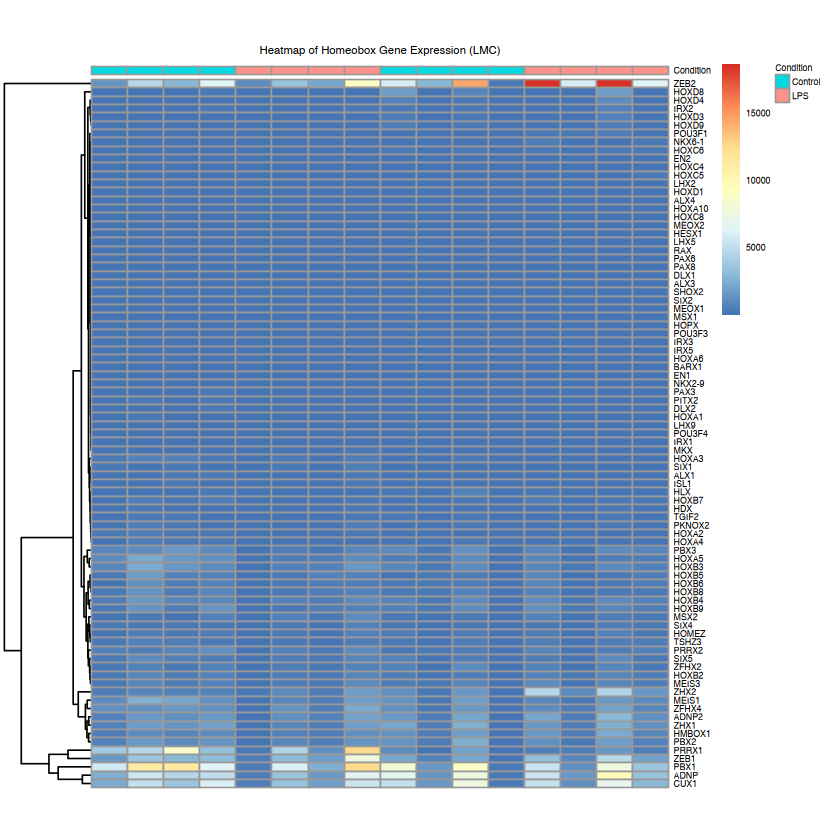

In [148]:
# LMC
pheatmap(
  mat             = lmc_mat,
  cluster_rows    = TRUE,
  cluster_cols    = FALSE,
  annotation_col  = annotation_lmc,
  show_rownames   = TRUE,
  show_colnames   = FALSE,
 # scale           = "row",
  main            = "Heatmap of Homeobox Gene Expression (LMC)",
  fontsize        = 5,
  fontsize_col    = 4,
  cellheight      = 5
)


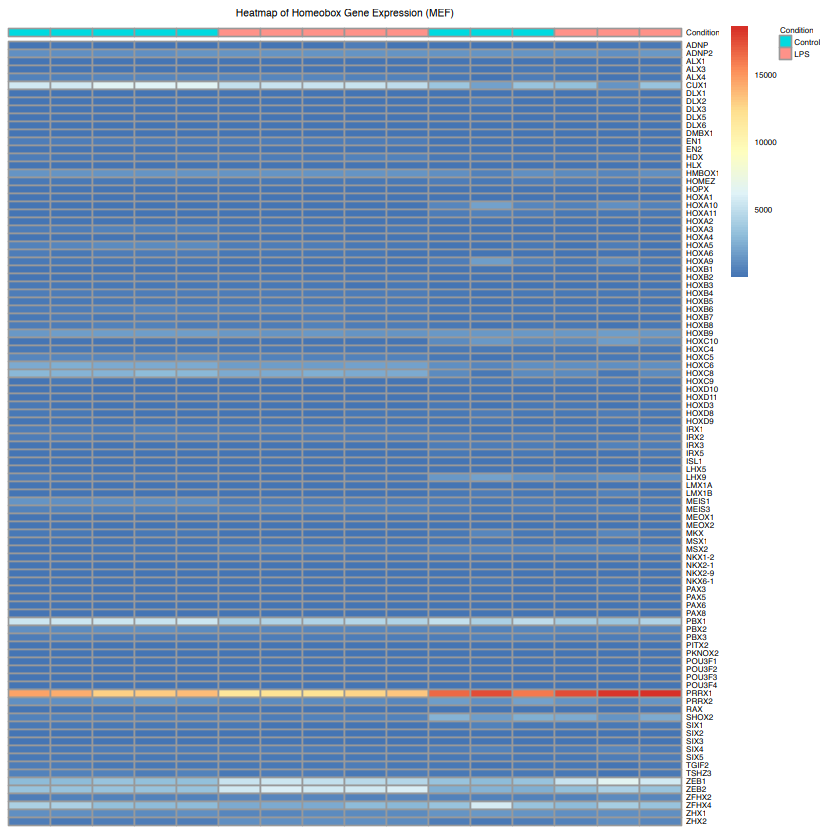

In [149]:
# MEF
pheatmap(
  mat             = mef_mat,
  cluster_rows    = FALSE,
  cluster_cols    = FALSE,
  annotation_col  = annotation_mef,
  show_rownames   = TRUE,
  show_colnames   = FALSE,
 # scale           = "row",
  main            = "Heatmap of Homeobox Gene Expression (MEF)",
  fontsize        = 4.5,
  fontsize_col    = 4,
  cellheight      = 4.8
)


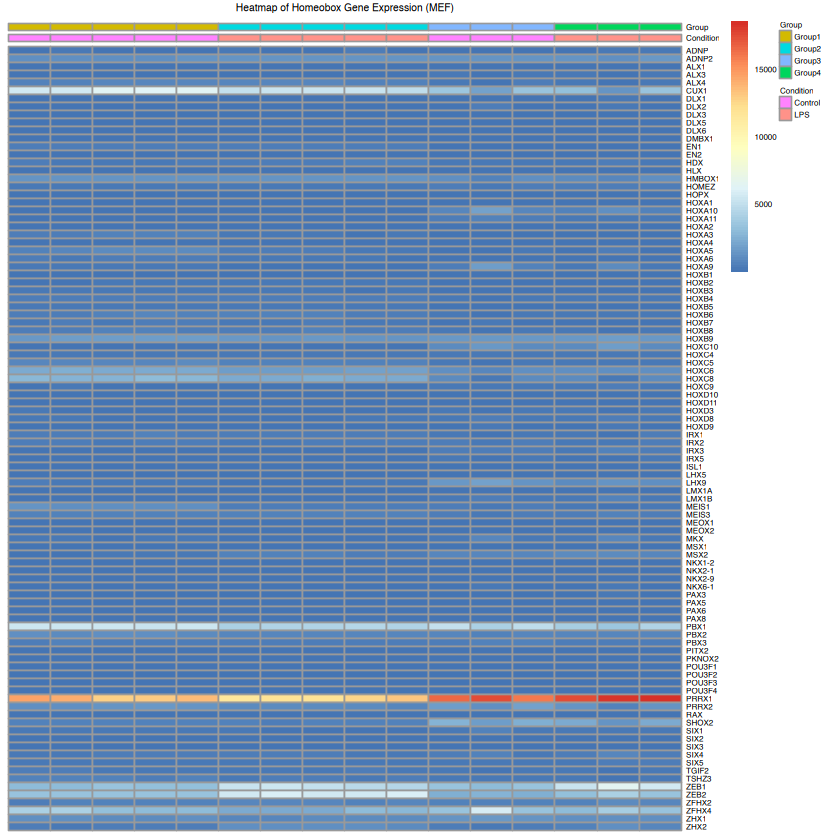

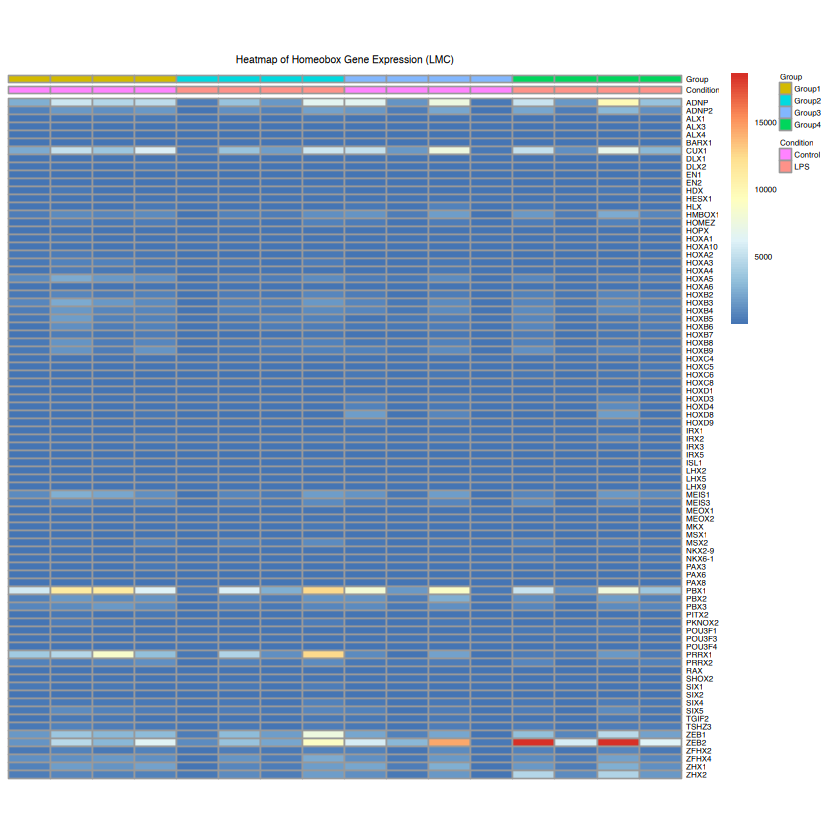

In [150]:
# install.packages("pheatmap")   # Uncomment if not installed
library(pheatmap)

# -----------------------------------------------------------------------------
# 1. Aggregate duplicates (by mean) so that each Gene_Name is unique
# -----------------------------------------------------------------------------
agg_lmc <- aggregate(. ~ Gene_Name,
                     data = countdata_lmc_home_full_list,
                     FUN  = mean)
rownames(agg_lmc) <- agg_lmc$Gene_Name
lmc_mat <- as.matrix(agg_lmc[ , -1])

agg_mef <- aggregate(. ~ Gene_Name,
                     data = countdata_mef_home_full_list,
                     FUN  = mean)
rownames(agg_mef) <- agg_mef$Gene_Name
mef_mat <- as.matrix(agg_mef[ , -1])

# -----------------------------------------------------------------------------
# 2. Build “Control vs LPS” annotations
# -----------------------------------------------------------------------------
cond_from_name <- function(cols) {
  ifelse(grepl("ctrl", cols, ignore.case = TRUE),
         "Control", "LPS")
}

# Annotation for MEF
annotation_mef <- data.frame(
  Condition = cond_from_name(colnames(mef_mat)),
  Group = factor(c(rep("Group1", 5),
                   rep("Group2", 5),
                   rep("Group3", 3),
                   rep("Group4", 3))),
  row.names = colnames(mef_mat)
)

# Annotation for LMC
annotation_lmc <- data.frame(
  Condition = cond_from_name(colnames(lmc_mat)),
  Group = factor(c(rep("Group1", 4),
                   rep("Group2", 4),
                   rep("Group3", 4),
                   rep("Group4", 4))),
  row.names = colnames(lmc_mat)
)

# -----------------------------------------------------------------------------
# 3. Plot heatmaps
# -----------------------------------------------------------------------------

# MEF Heatmap
pheatmap(
  mat             = mef_mat,
  cluster_rows    = FALSE,
  cluster_cols    = FALSE,
  annotation_col  = annotation_mef,
  show_rownames   = TRUE,
  show_colnames   = FALSE,
  main            = "Heatmap of Homeobox Gene Expression (MEF)",
  fontsize        = 4.5,
  fontsize_col    = 4,
  cellheight      = 4.8
)

# LMC Heatmap
pheatmap(
  mat             = lmc_mat,
  cluster_rows    = FALSE,
  cluster_cols    = FALSE,
  annotation_col  = annotation_lmc,
  show_rownames   = TRUE,
  show_colnames   = FALSE,
  main            = "Heatmap of Homeobox Gene Expression (LMC)",
  fontsize        = 4.5,
  fontsize_col    = 4,
  cellheight      = 4.8
)


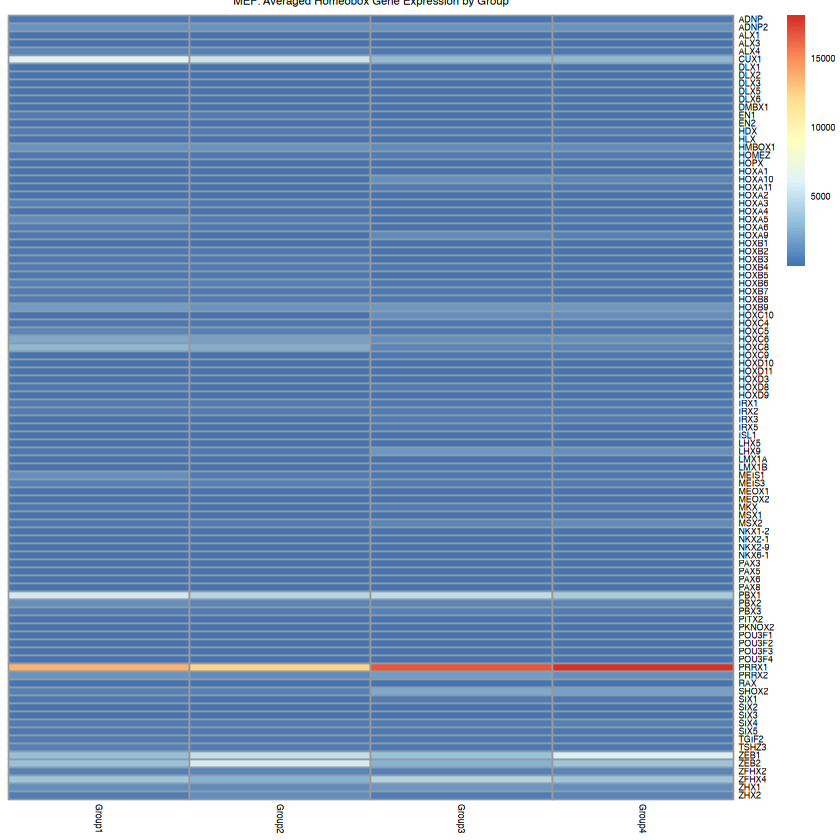

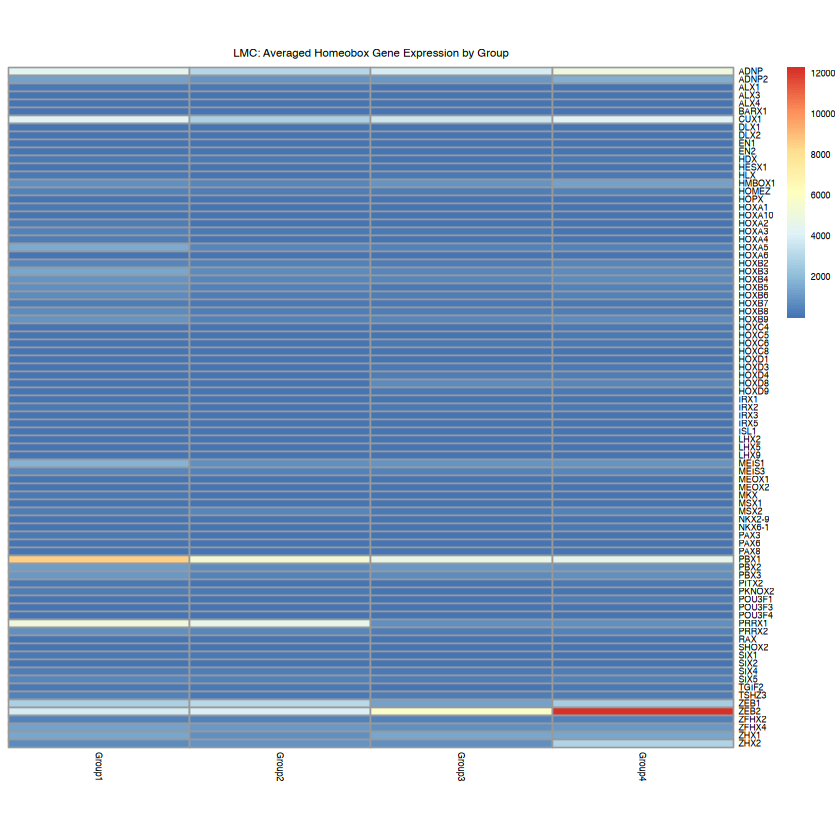

In [151]:
# install.packages("pheatmap")   # Uncomment if not installed
library(pheatmap)

# -----------------------------------------------------------------------------
# 1. Aggregate duplicates (by mean) so that each Gene_Name is unique
# -----------------------------------------------------------------------------
agg_lmc <- aggregate(. ~ Gene_Name,
                     data = countdata_lmc_home_full_list,
                     FUN  = mean)
rownames(agg_lmc) <- agg_lmc$Gene_Name
lmc_mat <- as.matrix(agg_lmc[ , -1])

agg_mef <- aggregate(. ~ Gene_Name,
                     data = countdata_mef_home_full_list,
                     FUN  = mean)
rownames(agg_mef) <- agg_mef$Gene_Name
mef_mat <- as.matrix(agg_mef[ , -1])

# -----------------------------------------------------------------------------
# 2. Define groups
# -----------------------------------------------------------------------------

# For MEF: 5+5+3+3 = 16 columns
group_mef <- c(rep("Group1", 5),
               rep("Group2", 5),
               rep("Group3", 3),
               rep("Group4", 3))

# For LMC: 4+4+4+4 = 16 columns
group_lmc <- c(rep("Group1", 4),
               rep("Group2", 4),
               rep("Group3", 4),
               rep("Group4", 4))

# -----------------------------------------------------------------------------
# 3. Function to average columns by group
# -----------------------------------------------------------------------------
average_by_group <- function(mat, group_vec) {
  groups <- unique(group_vec)
  averaged_mat <- sapply(groups, function(g) {
    cols <- which(group_vec == g)
    rowMeans(mat[, cols, drop = FALSE])
  })
  return(averaged_mat)
}

# -----------------------------------------------------------------------------
# 4. Compute averaged matrices
# -----------------------------------------------------------------------------
mef_mat_avg <- average_by_group(mef_mat, group_mef)
lmc_mat_avg <- average_by_group(lmc_mat, group_lmc)

# -----------------------------------------------------------------------------
# 5. Plot heatmaps
# -----------------------------------------------------------------------------

# MEF Heatmap (4 columns, averaged)
pheatmap(
  mat             = mef_mat_avg,
  cluster_rows    = FALSE,
  cluster_cols    = FALSE,
  show_rownames   = TRUE,
  show_colnames   = TRUE,
  main            = "MEF: Averaged Homeobox Gene Expression by Group",
  fontsize        = 5,
  fontsize_col    = 5,
  cellheight      = 4.8
)

# LMC Heatmap (4 columns, averaged)
pheatmap(
  mat             = lmc_mat_avg,
  cluster_rows    = FALSE,
  cluster_cols    = FALSE,
  show_rownames   = TRUE,
  show_colnames   = TRUE,
  main            = "LMC: Averaged Homeobox Gene Expression by Group",
  fontsize        = 5,
  fontsize_col    = 5,
  cellheight      = 4.8
)


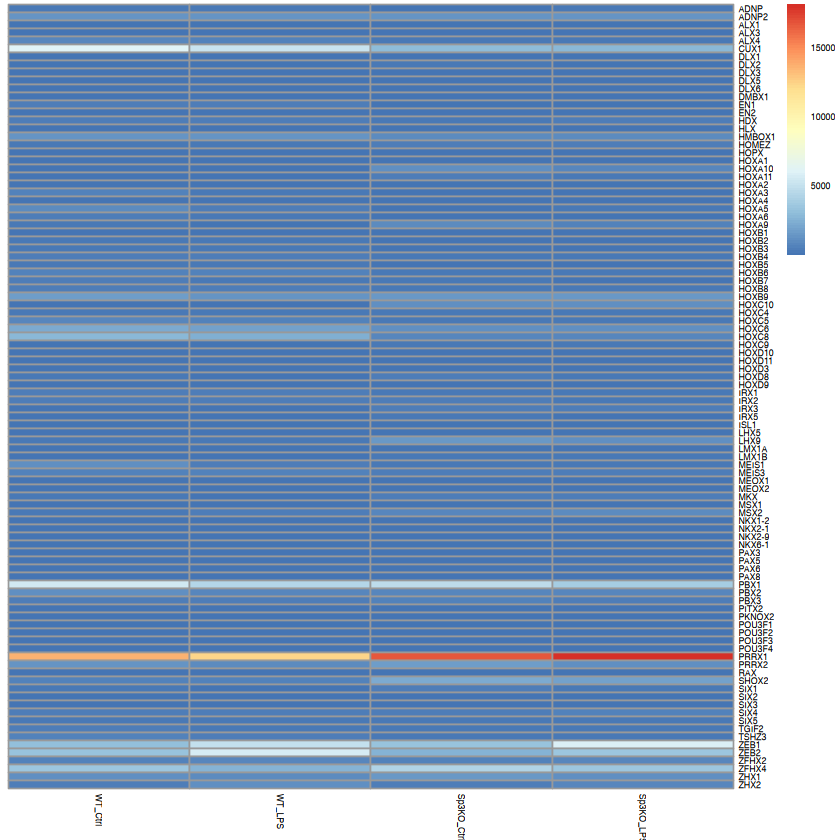

In [152]:
# install.packages("pheatmap")   # Uncomment if not already installed
library(pheatmap)

# -----------------------------------------------------------------------------
# 1. Aggregate duplicates (by mean) so that each Gene_Name is unique
# -----------------------------------------------------------------------------
agg_lmc <- aggregate(. ~ Gene_Name,
                     data = countdata_lmc_home_full_list,
                     FUN  = mean)
rownames(agg_lmc) <- agg_lmc$Gene_Name
lmc_mat <- as.matrix(agg_lmc[ , -1])

agg_mef <- aggregate(. ~ Gene_Name,
                     data = countdata_mef_home_full_list,
                     FUN  = mean)
rownames(agg_mef) <- agg_mef$Gene_Name
mef_mat <- as.matrix(agg_mef[ , -1])

# -----------------------------------------------------------------------------
# 2. Define biological groups (WT+Ctrl, WT+LPS, KO+Ctrl, KO+LPS)
# -----------------------------------------------------------------------------

# For MEF: 5+5+3+3 = 16 columns
group_mef <- c(
  rep("WT_Ctrl", 5),
  rep("WT_LPS", 5),
  rep("Sp3KO_Ctrl", 3),
  rep("Sp3KO_LPS", 3)
)

# For LMC: 4+4+4+4 = 16 columns
group_lmc <- c(
  rep("WT_Ctrl", 4),
  rep("WT_LPS", 4),
  rep("Sp3KO_Ctrl", 4),
  rep("Sp3KO_LPS", 4)
)

# -----------------------------------------------------------------------------
# 3. Function to average columns by group
# -----------------------------------------------------------------------------
average_by_group <- function(mat, group_vec) {
  groups <- unique(group_vec)
  averaged_mat <- sapply(groups, function(g) {
    cols <- which(group_vec == g)
    rowMeans(mat[, cols, drop = FALSE])
  })
  colnames(averaged_mat) <- groups
  return(averaged_mat)
}

# -----------------------------------------------------------------------------
# 4. Compute averaged matrices
# -----------------------------------------------------------------------------
mef_mat_avg <- average_by_group(mef_mat, group_mef)
lmc_mat_avg <- average_by_group(lmc_mat, group_lmc)

# -----------------------------------------------------------------------------
# 5. Plot heatmaps
# -----------------------------------------------------------------------------

# MEF Heatmap (averaged)
pheatmap(
  mat             = mef_mat_avg,
  cluster_rows    = FALSE,
  cluster_cols    = FALSE,
  show_rownames   = TRUE,
  show_colnames   = TRUE,
  main            = "MEF: Averaged Homeobox Gene Expression",
  fontsize        = 5,
  fontsize_col    = 5,
  cellheight      = 4.8
)




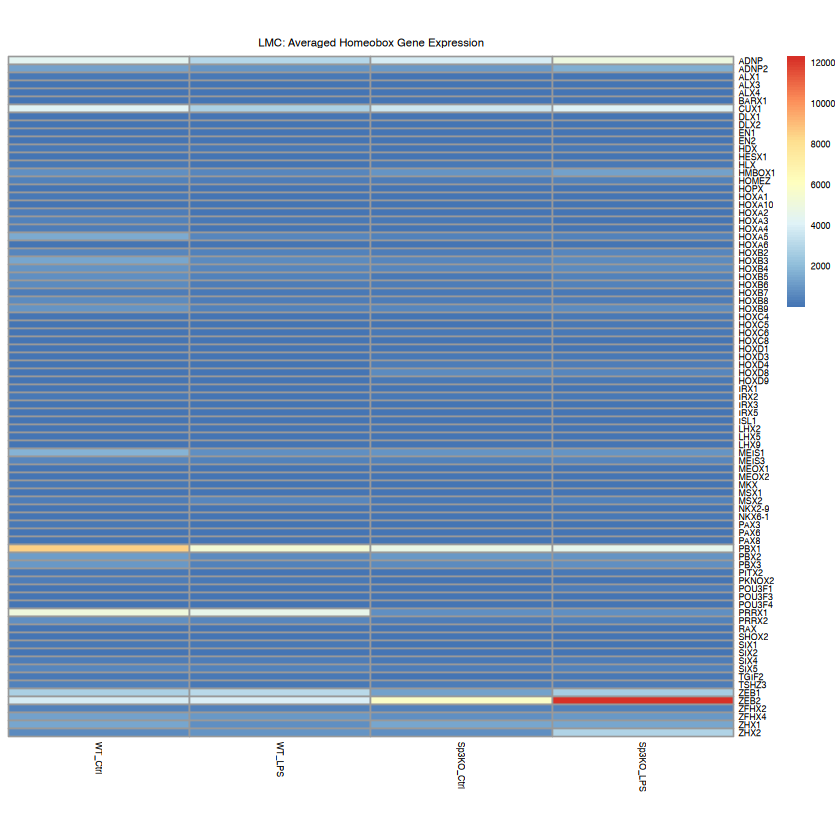

In [153]:
# LMC Heatmap (averaged)
pheatmap(
  mat             = lmc_mat_avg,
  cluster_rows    = FALSE,
  cluster_cols    = FALSE,
  show_rownames   = TRUE,
  show_colnames   = TRUE,
  main            = "LMC: Averaged Homeobox Gene Expression",
  fontsize        = 5,
  fontsize_col    = 5,
  cellheight      = 4.8
)

In [1]:
# install.packages("pheatmap")   # Uncomment if not already installed
library(pheatmap)

# -----------------------------------------------------------------------------
# 1. Aggregate duplicates (by mean) so that each Gene_Name is unique
# -----------------------------------------------------------------------------
agg_lmc <- aggregate(. ~ Gene_Name,
                     data = countdata_lmc_home_full_list,
                     FUN  = mean)
rownames(agg_lmc) <- agg_lmc$Gene_Name
lmc_mat <- as.matrix(agg_lmc[ , -1])

agg_mef <- aggregate(. ~ Gene_Name,
                     data = countdata_mef_home_full_list,
                     FUN  = mean)
rownames(agg_mef) <- agg_mef$Gene_Name
mef_mat <- as.matrix(agg_mef[ , -1])

# -----------------------------------------------------------------------------
# 2. Define biological groups
# -----------------------------------------------------------------------------

# For MEF: 5+5+3+3 = 16 columns
group_mef <- c(
  rep("WT_Ctrl", 5),
  rep("WT_LPS", 5),
  rep("Sp3KO_Ctrl", 3),
  rep("Sp3KO_LPS", 3)
)

# For LMC: 4+4+4+4 = 16 columns
group_lmc <- c(
  rep("WT_Ctrl", 4),
  rep("WT_LPS", 4),
  rep("Sp3KO_Ctrl", 4),
  rep("Sp3KO_LPS", 4)
)

# -----------------------------------------------------------------------------
# 3. Function to average columns by group
# -----------------------------------------------------------------------------
average_by_group <- function(mat, group_vec) {
  groups <- unique(group_vec)
  averaged_mat <- sapply(groups, function(g) {
    cols <- which(group_vec == g)
    rowMeans(mat[, cols, drop = FALSE])
  })
  colnames(averaged_mat) <- groups
  return(averaged_mat)
}

# -----------------------------------------------------------------------------
# 4. Compute averaged matrices (log2 transformed)
# -----------------------------------------------------------------------------
mef_mat_avg <- average_by_group(mef_mat, group_mef)
lmc_mat_avg <- average_by_group(lmc_mat, group_lmc)

# Apply log2(x + 1)
mef_mat_avg_log <- log2(mef_mat_avg + 1)
lmc_mat_avg_log <- log2(lmc_mat_avg + 1)

# -----------------------------------------------------------------------------
# 5. Plot heatmaps
# -----------------------------------------------------------------------------

# MEF Heatmap (log2-transformed)
pheatmap(
  mat             = mef_mat_avg_log,
  cluster_rows    = FALSE,
  cluster_cols    = FALSE,
  show_rownames   = TRUE,
  show_colnames   = TRUE,
  main            = "MEF: log2(Averaged Homeobox Gene Expression)",
  fontsize        = 5,
  fontsize_col    = 5,
  cellheight      = 4.8
)

# LMC Heatmap (log2-transformed)
pheatmap(
  mat             = lmc_mat_avg_log,
  cluster_rows    = FALSE,
  cluster_cols    = FALSE,
  show_rownames   = TRUE,
  show_colnames   = TRUE,
  main            = "LMC: log2(Averaged Homeobox Gene Expression)",
  fontsize        = 5,
  fontsize_col    = 5,
  cellheight      = 4.8
)


ERROR: Error in eval(m$data, parent.frame()): object 'countdata_lmc_home_full_list' not found


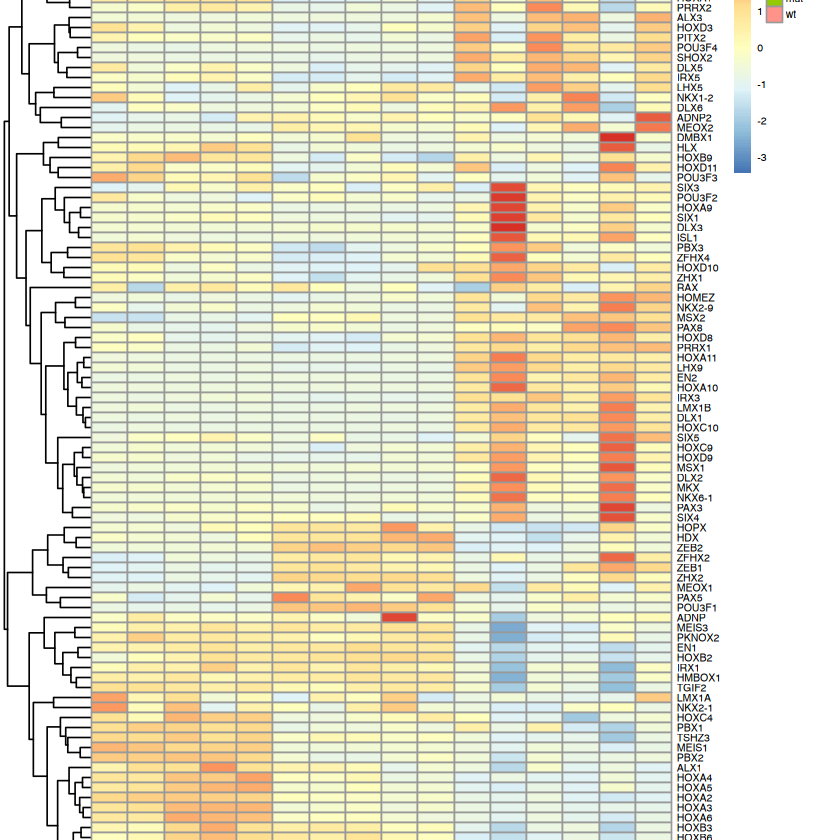

In [149]:


# Convert countData rownames to uppercase for comparison
countData_rownames_upper <- toupper(rownames(countData))

# Intersect
common_genes_homeo <- intersect(homeobox_unique, countData_rownames_upper)

# Check if any genes matched
if (length(common_genes_homeo) == 0) {
  stop("No genes from the gene list were found in countData rownames. Check gene naming and casing.")
}

# Subset countData, but keep original rownames
filteredCountData_homeo <- countData[rownames(countData)[toupper(rownames(countData)) %in% common_genes_homeo], ]

# Check again for empty data
if (nrow(filteredCountData_homeo) == 0) {
  stop("Filtered countData has 0 rows—cannot plot heatmap.")
}

# Plot
pheatmap(
  filteredCountData_homeo,
  cluster_rows = TRUE,
  cluster_cols = FALSE,
  annotation_col = as.data.frame(manual_annotation),
  show_rownames = TRUE,
  show_colnames = FALSE,
  scale = 'row',
  main = "Heatmap of Homeobox Gene Expression (MEF)",
  fontsize = 6,
  fontsize_col = 10,
  cellheight = 6
)


[1] "Number of rows: 98"


pdf 
  3

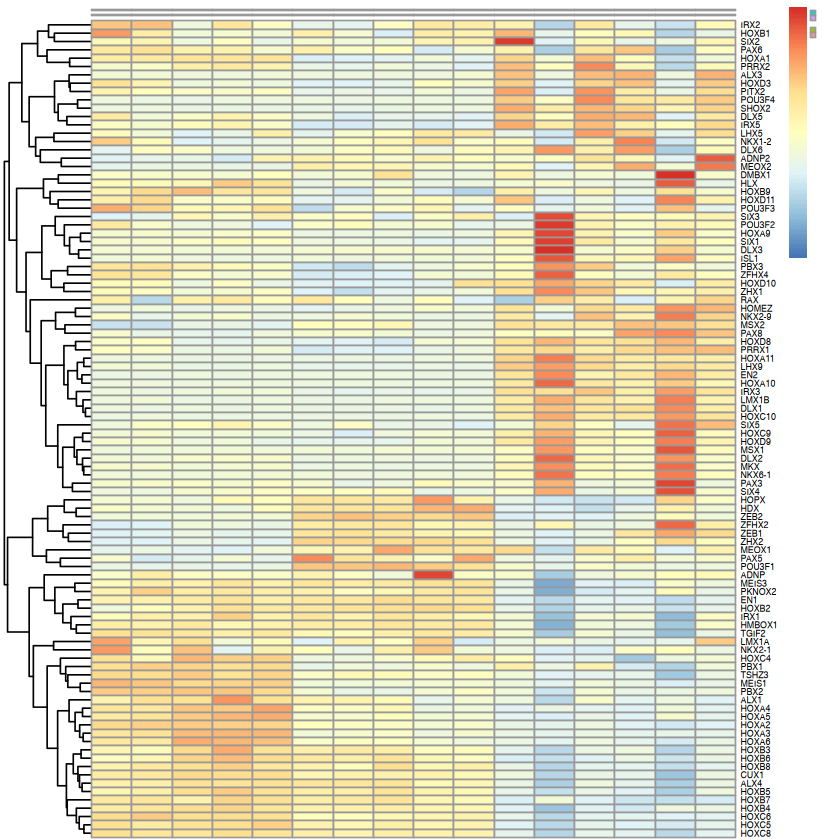

In [150]:
# Compute number of rows
num_rows <- nrow(filteredCountData_homeo)
print(paste("Number of rows:", num_rows))

# Compute cell height
desired_total_height <- 100
computed_cellheight <- desired_total_height / num_rows
computed_cellheight <- max(computed_cellheight, 5)

computed_fontsize_row <- ifelse(num_rows > 50, 5, 8)
pdf_height <- 200

# Create PDF
pdf("Heatmap_of_Homeobox_Gene_Expression_FULL_LABELS_v1.pdf", width = 16, height = pdf_height)

# Generate heatmap
pheatmap(
  filteredCountData_homeo,
  cluster_rows = TRUE,
  cluster_cols = FALSE,
  annotation_col = as.data.frame(manual_annotation),
  show_rownames = TRUE,
  show_colnames = FALSE,
  scale = 'row',
  main = "Heatmap of Homeobox Gene Expression (MEF)",
  fontsize = 1,
  fontsize_row = computed_fontsize_row,
  cellheight = computed_cellheight
)

# IMPORTANT: finalize the PDF file
dev.off()


In [151]:
filteredCountData_homeo_full_list <- countData[toupper(data$gene), ]

In [152]:
filteredCountData_homeo_full_list

P7_4_Ctrl1 P7_4_Ctrl2 P8_4_Ctrl3 P8_4_Ctrl4 P8_4_Ctrl5 P8_4_Lps3 P8_4_Lps5
     P8_4_Lps4 P7_4_Lps1 P7_4_Lps2 P4_5_Ctrl1 P4_5_Ctrl3 P4_5_Ctrl2 P4_5_Lps2
     P4_5_Lps3 P4_5_Lps1

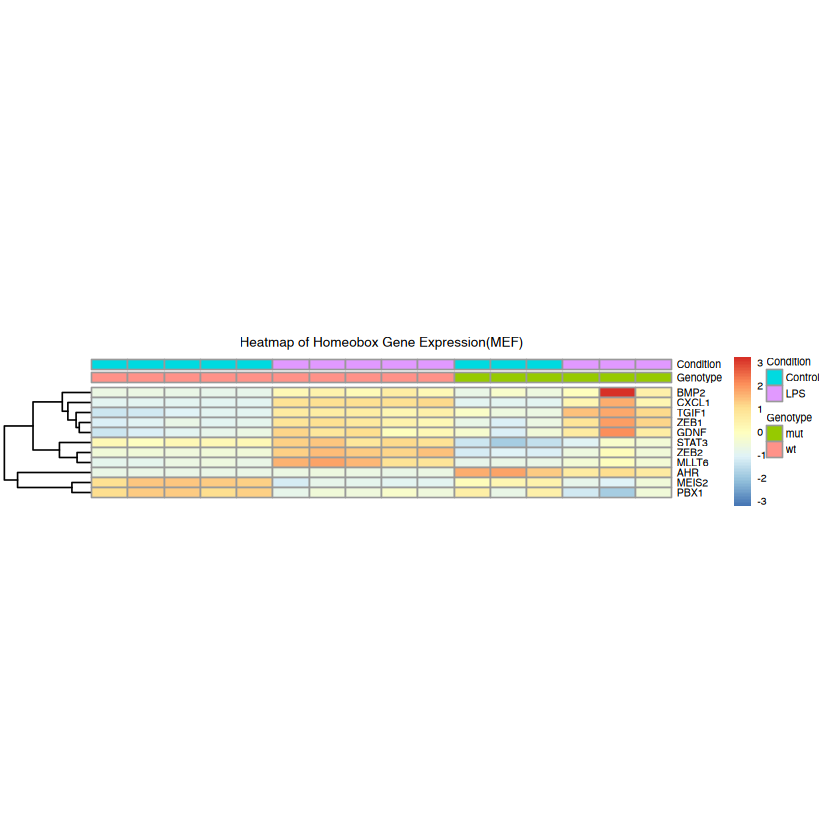

In [153]:
# Load necessary libraries
library(pheatmap)
library(dplyr)

# Ensure the gene names in homeobox are present in the row names of countData
#common_genes <- intersect(homeobox$Gene_name, rownames(countData))
#common_genes_homeo <- intersect(common_homeo, rownames(countData))
common_genes_homeo <- intersect(common_homeo, common_genes_I_II )
# Filter countData to include only rows that have genes present in common_genes
filteredCountData_homeo <- countData[common_genes_homeo, ]

# Define the width and height of the plot
# Increase the height to ensure all rows are visible
plot_width <- 20
plot_height <- 30

# Save the heatmap as a PDF
#pdf("Heatmap_of_Homeobox_Gene_Expression.pdf", width = plot_width, height = plot_height)

# Plot the heatmap of the filtered countData with clustering and improved row names visibility
pheatmap(filteredCountData_homeo,
         cluster_rows = TRUE,  # Cluster by rows
         cluster_cols = FALSE,
         annotation_col = as.data.frame(manual_annotation),  # Ensure this is defined or modify as needed
         show_rownames = TRUE,
         show_colnames = FALSE, # Hiding column names
     #    fontsize_row = 4,  # Adjust the font size for row names
         fontsize_col = 10,
         scale = 'row',# Adjust the font size for column names if shown
         main = "Heatmap of Homeobox Gene Expression(MEF)",
         fontsize = 6,  # Increase overall font size
         cellheight = 6
        )  # Set the height of each cell (row)

In [154]:
common_genes_homeo <- data.frame(common_genes_homeo)
write.csv(common_genes_homeo,'genes_homeo_mef.csv')

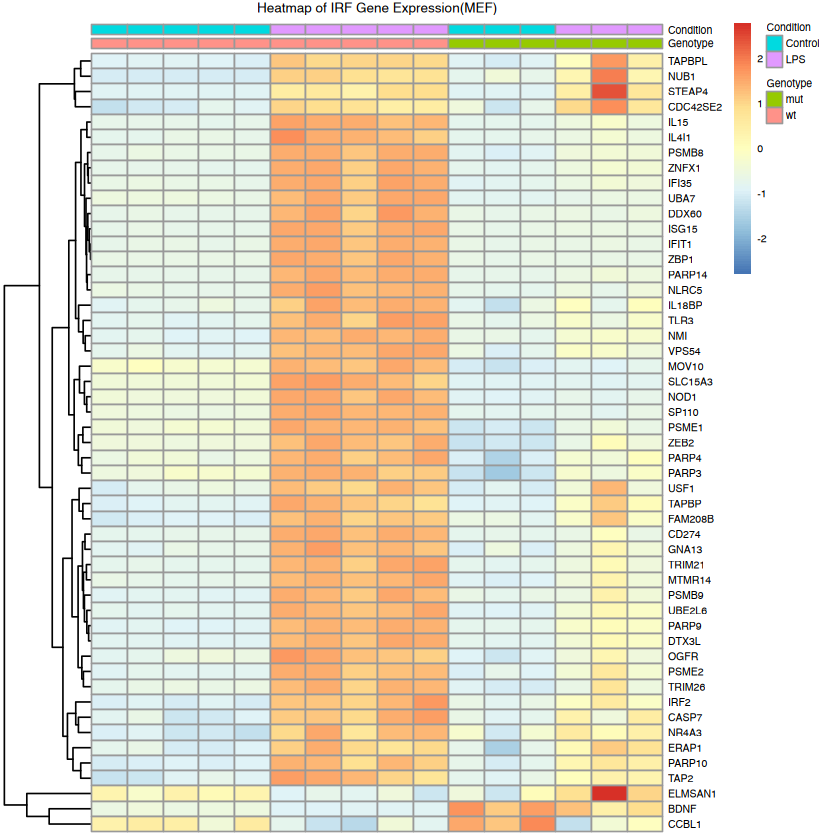

In [155]:
# Load necessary libraries
library(pheatmap)
library(dplyr)

# Ensure the gene names in homeobox are present in the row names of countData
#common_genes_irf <- intersect(irf$Gene_name, rownames(countData))

common_genes_irf <- intersect(common_irf, common_genes_I_II)

# Filter countData to include only rows that have genes present in common_genes
filteredCountData_irf <- countData[common_genes_irf, ]

# Define the width and height of the plot
# Increase the height to ensure all rows are visible
plot_width <- 20
plot_height <- 30

# Save the heatmap as a PDF
#pdf("Heatmap_of_Homeobox_Gene_Expression.pdf", width = plot_width, height = plot_height)

# Plot the heatmap of the filtered countData with clustering and improved row names visibility
pheatmap(filteredCountData_irf,
         cluster_rows = TRUE,  # Cluster by rows
         cluster_cols = FALSE,
         annotation_col = as.data.frame(manual_annotation),  # Ensure this is defined or modify as needed
         show_rownames = TRUE,
         show_colnames = FALSE,  # Hiding column names
         scale = "row",
        # fontsize_row = 4,  # Adjust the font size for row names
        # fontsize_col = 10,  # Adjust the font size for column names if shown
         main = "Heatmap of IRF Gene Expression(MEF)",
         fontsize = 6  # Increase overall font size
        # cellheight = 4)
         )# Set the height of each cell (row)

In [156]:
common_genes_irf <- data.frame(common_genes_irf)
write.csv(common_genes_irf,'genes_irf_mef.csv')

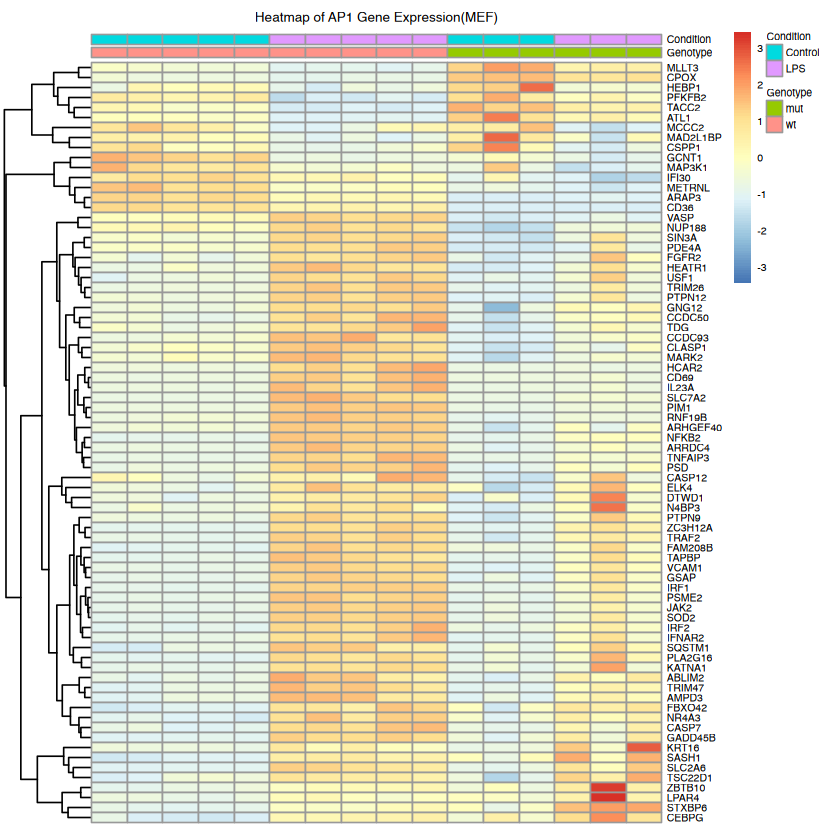

In [157]:
# Load necessary libraries
library(pheatmap)
library(dplyr)

# Ensure the gene names in homeobox are present in the row names of countData
#common_genes <- intersect(homeobox$Gene_name, rownames(countData))

common_genes_ap1 <- intersect(common_ap1, common_genes_I_II)


# Filter countData to include only rows that have genes present in common_genes
filteredCountData_ap1 <- countData[common_genes_ap1, ]

# Define the width and height of the plot
# Increase the height to ensure all rows are visible
plot_width <- 20
plot_height <- 30

# Save the heatmap as a PDF
#pdf("Heatmap_of_Homeobox_Gene_Expression.pdf", width = plot_width, height = plot_height)

# Plot the heatmap of the filtered countData with clustering and improved row names visibility
pheatmap(filteredCountData_ap1,
         cluster_rows = TRUE,  # Cluster by rows
         cluster_cols = FALSE,
         annotation_col = as.data.frame(manual_annotation),  # Ensure this is defined or modify as needed
         show_rownames = TRUE,
         show_colnames = FALSE,  # Hiding column names
         scale = "row",
        # fontsize_row = 4,  # Adjust the font size for row names
         #fontsize_col = 10,  # Adjust the font size for column names if shown
         main = "Heatmap of AP1 Gene Expression(MEF)",
         fontsize = 6,  # Increase overall font size
        cellheight = 6)  
        # )# Set the height of each cell (row)

In [158]:
common_genes_ap1 <- data.frame(common_genes_ap1)
write.csv(common_genes_ap1,'genes_ap1_mef.csv')

In [159]:
homeobox_interest <- grep("^HOX|^LIM|^POU|^PAX", homeobox$Gene_name, value = TRUE)

In [160]:
# Load necessary libraries
library(pheatmap)
library(dplyr)

# Ensure the gene names in homeobox are present in the row names of countData
#common_genes <- intersect(homeobox$Gene_name, rownames(countData))
common_genes <- intersect(homeobox_interest, rownames(countData))
# Filter countData to include only rows that have genes present in common_genes
filteredCountData_homeo <- countData[common_genes, ]

# Define the width and height of the plot
# Increase the height to ensure all rows are visible
plot_width <- 20
plot_height <- 30

# Save the heatmap as a PDF
#pdf("Heatmap_of_Homeobox_Gene_Expression.pdf", width = plot_width, height = plot_height)

# Plot the heatmap of the filtered countData with clustering and improved row names visibility
pheatmap(filteredCountData_homeo,
         cluster_rows = TRUE,  # Cluster by rows
         cluster_cols = FALSE,
         annotation_col = as.data.frame(manual_annotation),  # Ensure this is defined or modify as needed
         show_rownames = TRUE,
         show_colnames = FALSE,  # Hiding column names
         scale = "row",
        # fontsize_row = 4,  # Adjust the font size for row names
         fontsize_col = 8,  # Adjust the font size for column names if shown
         main = "Heatmap of Homeobox Gene Expression(MEF)",
       #  fontsize = 6,  # Increase overall font size
       #  cellheight = 
        )  # Set the height of each cell (row)

Warning message in min(x, na.rm = T):
"no non-missing arguments to min; returning Inf"
Warning message in max(x, na.rm = T):
"no non-missing arguments to max; returning -Inf"


ERROR: Error in seq.default(-m, m, length.out = n + 1): 'from' must be a finite number


In [161]:
pheatmap(filteredCountData_homeo,
         cluster_rows = TRUE,  # Cluster by rows
         cluster_cols = FALSE,
         annotation_col = as.data.frame(manual_annotation),  # Ensure this is defined or modify as needed
         show_rownames = TRUE,
         show_colnames = FALSE,  # Hiding column names
         scale = "row",
        # fontsize_row = 4,  # Adjust the font size for row names
         fontsize_col = 8,  # Adjust the font size for column names if shown
         main = "Heatmap of Homeobox Gene Expression(MEF)",
       #  fontsize = 6,  # Increase overall font size
       #  cellheight = 
        )  # Set the height of each cell (row)

Warning message in min(x, na.rm = T):
"no non-missing arguments to min; returning Inf"
Warning message in max(x, na.rm = T):
"no non-missing arguments to max; returning -Inf"


ERROR: Error in seq.default(-m, m, length.out = n + 1): 'from' must be a finite number


In [162]:
# Extract log2FC for the top 50 genes from res2_I_sig and res2_II_sig
# Ensuring only matching rows are selected and handling potential NA values
log2FC_I <- res2_I_sig[match(rownames(top50FilteredData), rownames(res2_I_sig)), "log2FoldChange", drop = FALSE]
log2FC_II <- res2_II_sig[match(rownames(top50FilteredData), rownames(res2_II_sig)), "log2FoldChange", drop = FALSE]




In [163]:

colnames(log2FC_I)[1] <- "log2FoldChange_I"
colnames(log2FC_II)[1] <- "log2FoldChange_II"
log2FC_I$Gene_name = rownames(log2FC_I)
log2FC_II$Gene_name = rownames(log2FC_II)

log2FC_II <- data.frame(log2FC_II)
log2FC_I <- data.frame(log2FC_I)

# Merging the data frames on the 'Gene' column
merged_data = merge(log2FC_I, log2FC_II, by = "Gene_name", all = TRUE)  # all = TRUE is like a full join



# View the merged data frame
print(merged_data)
rownames(merged_data) <- merged_data$Gene_name
#merged_data$Gene <- NULL

   Gene_name log2FoldChange_I log2FoldChange_II
1       BCL3         3.677747          3.634574
2       BMP2         2.044522          2.079131
3         C3         6.387863          4.861464
4      CASP4         3.788840          1.982756
5       CCL2         4.683613          4.994727
6      CCL20         6.086624          3.813517
7       CCL5         8.158562          5.141608
8      CD274         4.423394          2.117868
9       CD83         3.951267          3.861525
10     CEBPD         2.708314          2.833539
11      CSF1         2.616276          2.396797
12      CSF3         6.813937          2.887042
13     CXCL1         9.584723          8.330495
14    CXCL10        10.265544          5.922044
15    CXCL11         6.193868          2.341873
16     CXCL5         6.920953          7.463613
17     CXCL9         8.942109          3.231781
18    CYP7B1         2.015157          2.364758
19      ELF3         2.614944          3.499563
20       FAS         3.120626          1

In [164]:
library(ggplot2)
library(reshape2)
library(dplyr)
# Convert the data from wide to long format
merged_data_long <- melt(merged_data, id.vars = "Gene_name", variable.name = "Condition", value.name = "Log2FoldChange")
merged_data_wide <- dcast(merged_data_long, Gene_name ~ Condition, value.var = "Log2FoldChange")

# Assuming merged_data_wide is already created and contains columns: Gene, log2FoldChange_I, log2FoldChange_II

# Create subsets of the data
increased_genes <- merged_data_wide %>% 
  filter(log2FoldChange_I < log2FoldChange_II)

decreased_genes <- merged_data_wide %>% 
  filter(log2FoldChange_I > log2FoldChange_II)



Attaching package: 'reshape2'


The following object is masked from 'package:tidyr':

    smiths




Warning message:
"The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead."


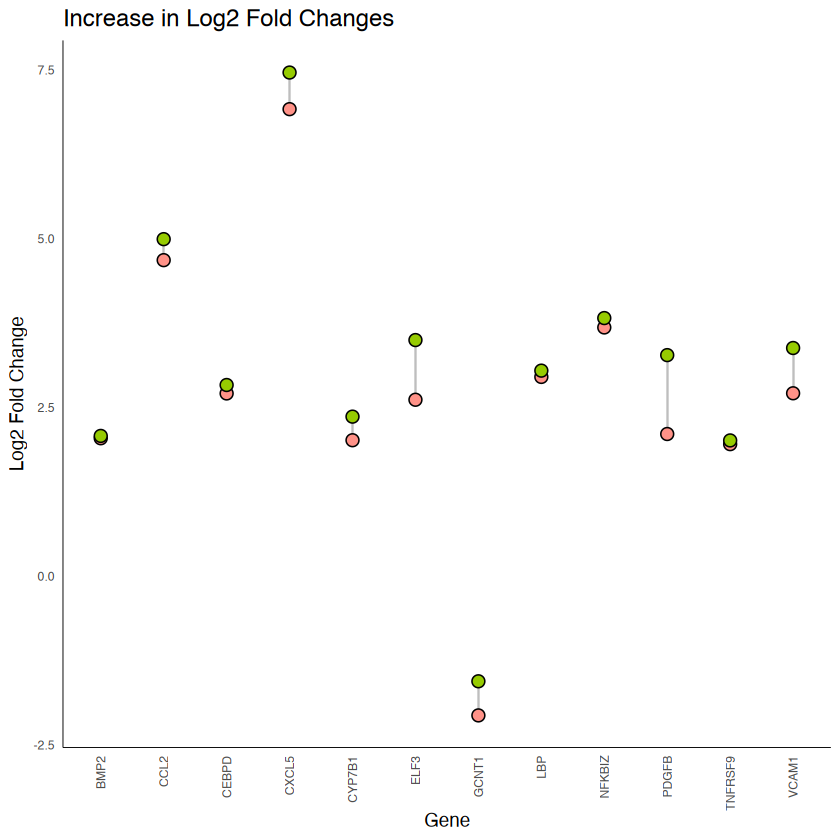

In [165]:
library(ggplot2)

# Creating the lollipop chart for increased genes with specified modifications
p_lollipop_increased <- ggplot(increased_genes, aes(x = Gene_name)) +
  geom_segment(aes(xend = Gene_name, y = log2FoldChange_I, yend = log2FoldChange_II), col = "grey") +
  geom_point(aes(y = log2FoldChange_I), color = 'black', size = 3, stroke = 0.5, shape = 21, fill = '#ff9288') +  # Specify shape and fill for a border
  geom_point(aes(y = log2FoldChange_II), color = 'black', size = 3, stroke = 0.5, shape = 21, fill = '#96cb01') + # Specify shape and fill for a border
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5, size = 7),
        axis.text.y = element_text(size = 7),
        axis.line = element_line(size = 0.2),   # Makes axis lines thicker
        panel.grid.major = element_blank(),    # Removes major grid lines
        panel.grid.minor = element_blank(),    # Removes minor grid lines
        plot.title = element_text(size = 14, face = "bold")) +
  labs(x = "Gene", y = "Log2 Fold Change", title = "Increase in Log2 Fold Changes")

# Display the plot
print(p_lollipop_increased)

# Save the plot to a file with specified dimensions
ggsave("Increased_Lollipop_Plot_mef.png", plot = p_lollipop_increased, width = 12, height = 8, dpi = 300)


In [166]:
increased_genes

Gene_name log2FoldChange_I log2FoldChange_II
1  BMP2       2.044522         2.079131        
2  CCL2       4.683613         4.994727        
3  CEBPD      2.708314         2.833539        
4  CXCL5      6.920953         7.463613        
5  CYP7B1     2.015157         2.364758        
6  ELF3       2.614944         3.499563        
7  GCNT1     -2.062359        -1.556807        
8  LBP        2.953295         3.046382        
9  NFKBIZ     3.686303         3.825288        
10 PDGFB      2.107351         3.276358        
11 TNFRSF9    1.957224         2.012112        
12 VCAM1      2.710938         3.381784

In [167]:
decreased_genes

Gene_name log2FoldChange_I log2FoldChange_II
1  BCL3       3.677747        3.634574         
2  C3         6.387863        4.861464         
3  CASP4      3.788840        1.982756         
4  CCL20      6.086624        3.813517         
5  CCL5       8.158562        5.141608         
6  CD274      4.423394        2.117868         
7  CD83       3.951267        3.861525         
8  CSF1       2.616276        2.396797         
9  CSF3       6.813937        2.887042         
10 CXCL1      9.584723        8.330495         
11 CXCL10    10.265544        5.922044         
12 CXCL11     6.193868        2.341873         
13 CXCL9      8.942109        3.231781         
14 FAS        3.120626        1.447868         
15 GADD45B    2.366651        1.100598         
16 IER3       1.971581        1.825314         
17 IIGP1      6.601131        2.742678         
18 IL15       3.983573        1.943487         
19 IL23A      5.760658        2.336684         
20 IRF1       4.294134        2.556843         
21 JUNB       1.483684        1.221135         
22 LCN2       6.858017        4.959524         
23 MADCAM1    3.911446        2.981737         
24 MMP9       2.728352        1.629967         
25 NFKB1      2.153403        1.839630         
26 NFKB2      2.460668        1.421486         
27 NFKBIA     4.290464        3.396784         
28 NFKBIE     4.446504        3.055110         
29 NOD2       3.735452        2.027449         
30 PIM1       2.883227        1.094337         
31 PTX3       4.176500        2.501969         
32 RELB       2.727338        2.378077         
33 RIPK2      4.056413        3.311244         
34 SAA3       7.849513        2.848527         
35 SDC4       2.888273        1.427798         
36 SELE       8.189349        6.344558         
37 SELP       3.091502        1.474394         
38 SLC11A2    1.577595        1.505332         
39 TAPBP      1.714986        1.263628         
40 TLR2       4.178613        4.044941         
41 TNFAIP2    3.666091        2.430206         
42 TNFAIP3    5.456525        3.541992         
43 TNFRSF1B   2.289846        1.355753         
44 TNFSF10    3.899106        1.974656         
45 TNIP1      2.447705        1.631067         
46 TRAF1      6.049811        3.788067

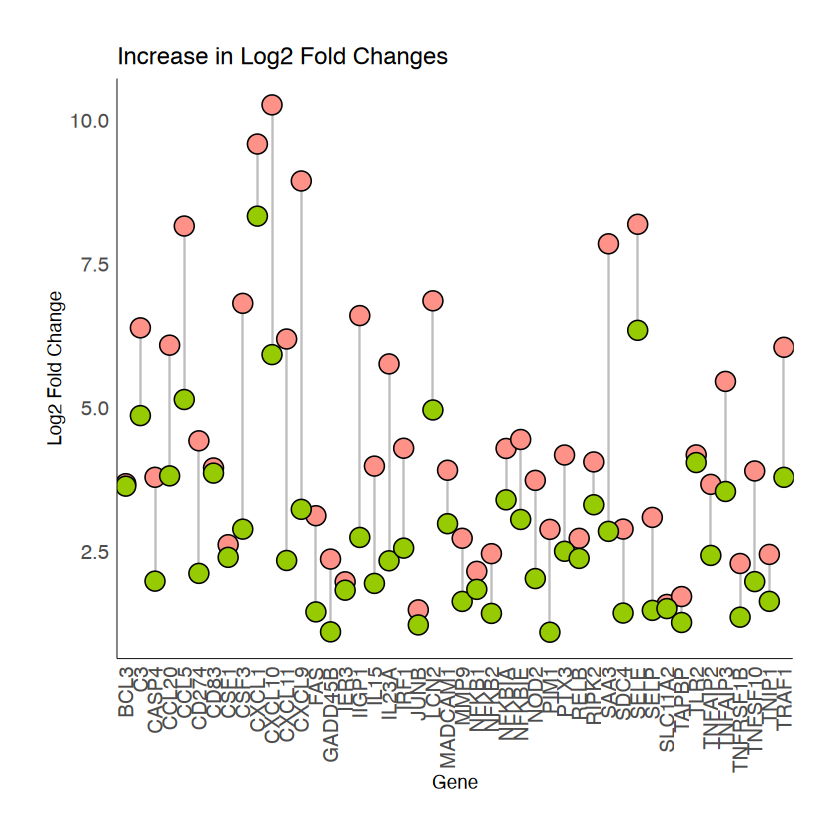

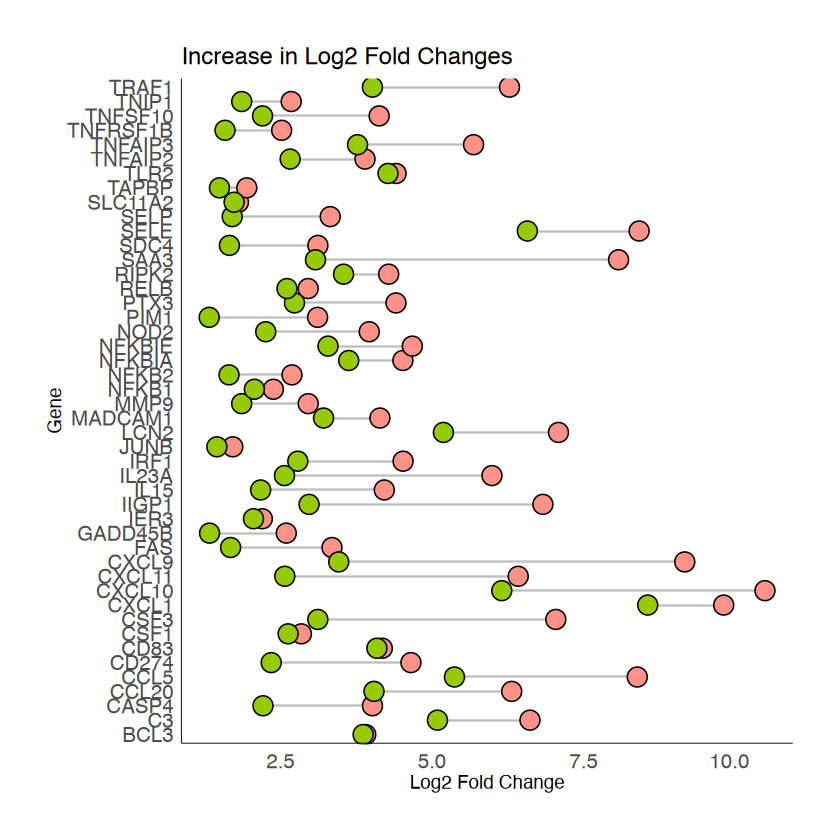

In [168]:
library(ggplot2)

# Data Preparation (Assuming 'decreased_genes' is your data frame)
# decreased_genes <- your_data_frame

# Function to create the lollipop chart
create_lollipop_plot <- function(data, orientation = "vertical") {
  p <- ggplot(data, aes(x = Gene_name)) +
    geom_segment(aes(xend = Gene_name, y = log2FoldChange_I, yend = log2FoldChange_II), col = "grey") +
    geom_point(aes(y = log2FoldChange_I), color = 'black', size = 5, stroke = 0.5, shape = 21, fill = '#ff9288') +  # Specify shape and fill for a border
    geom_point(aes(y = log2FoldChange_II), color = 'black', size = 5, stroke = 0.5, shape = 21, fill = '#96cb01') + # Specify shape and fill for a border
    theme_minimal() +
    theme(
      axis.text.x = element_text(angle = ifelse(orientation == "vertical", 90, 0), hjust = 1, vjust = 0.5, size = 12),  # Increase font size
      axis.text.y = element_text(size = 12),  # Increase font size
      axis.line = element_line(size = 0.2),   # Makes axis lines thicker
      panel.grid.major = element_blank(),    # Removes major grid lines
      panel.grid.minor = element_blank(),    # Removes minor grid lines
      plot.title = element_text(size = 14, face = "bold"),
      plot.margin = margin(1, 1, 1, 1, "cm") # Reduce white space around the plot
    ) +
    labs(x = "Gene", y = "Log2 Fold Change", title = "Increase in Log2 Fold Changes")
  
  if (orientation == "horizontal") {
    p <- p + coord_flip()  # Flip coordinates for horizontal plot
  }
  
  return(p)
}

# Creating vertical lollipop plot
p_lollipop_decreased_vertical <- create_lollipop_plot(decreased_genes, orientation = "vertical")
print(p_lollipop_decreased_vertical)

# Save the vertical plot to a file with specified dimensions
ggsave("Decreased_Lollipop_Plot_Vertical.png", plot = p_lollipop_decreased_vertical, width = 12, height = 8, dpi = 300)

# Creating horizontal lollipop plot
p_lollipop_decreased_horizontal <- create_lollipop_plot(decreased_genes, orientation = "horizontal")
print(p_lollipop_decreased_horizontal)

# Save the horizontal plot to a file with specified dimensions
ggsave("Decreased_Lollipop_Plot_Horizontal.png", plot = p_lollipop_decreased_horizontal, width = 12, height = 8, dpi = 300)


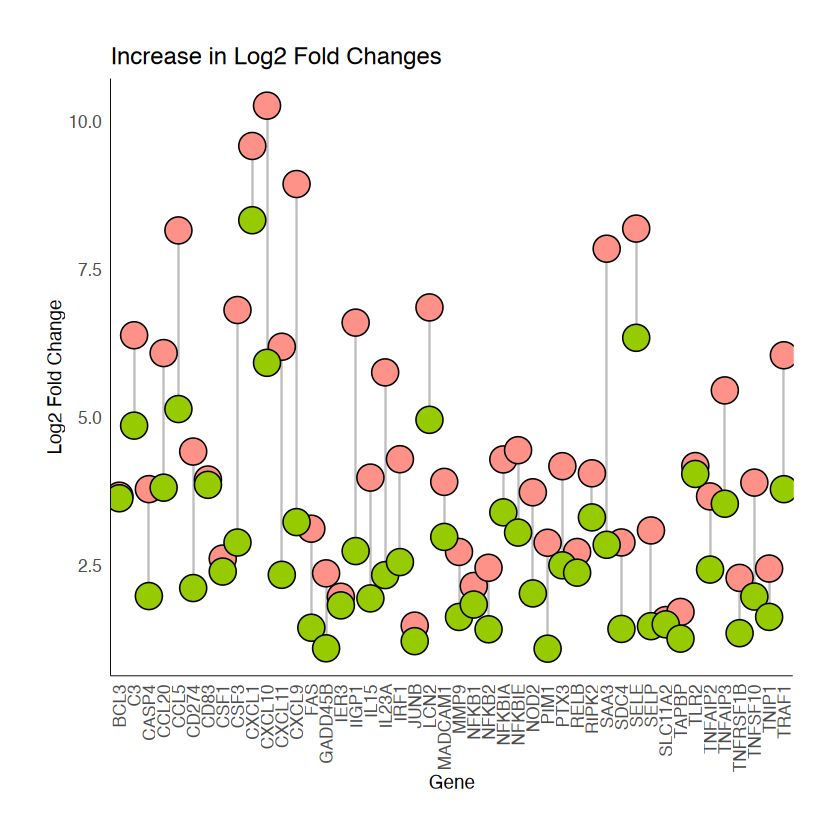

In [169]:
library(ggplot2)

# Data Preparation (Assuming 'decreased_genes' is your data frame)
# decreased_genes <- your_data_frame

# Function to create the lollipop chart
create_lollipop_plot <- function(data, orientation = "vertical") {
  p <- ggplot(data, aes(x = Gene_name)) +
    geom_segment(aes(xend = Gene_name, y = log2FoldChange_I, yend = log2FoldChange_II), col = "grey") +
    geom_point(aes(y = log2FoldChange_I), color = 'black', size = 7, stroke = 0.5, shape = 21, fill = '#ff9288') +  # Specify shape and fill for a border
    geom_point(aes(y = log2FoldChange_II), color = 'black', size = 7, stroke = 0.5, shape = 21, fill = '#96cb01') + # Specify shape and fill for a border
    theme_minimal() +
    theme(
      axis.text.x = element_text(angle = ifelse(orientation == "vertical", 90, 0), hjust = 1, vjust = 0.5, size = 10),  # Reduced font size
      axis.text.y = element_text(size = 10),  # Reduced font size
      axis.line = element_line(size = 0.2),   # Makes axis lines thicker
      panel.grid.major = element_blank(),    # Removes major grid lines
      panel.grid.minor = element_blank(),    # Removes minor grid lines
      plot.title = element_text(size = 14, face = "bold"),
      plot.margin = margin(1, 1, 1, 1, "cm") # Reduce white space around the plot
    ) +
    labs(x = "Gene", y = "Log2 Fold Change", title = "Increase in Log2 Fold Changes")
  
  if (orientation == "horizontal") {
    p <- p + coord_flip()  # Flip coordinates for horizontal plot
  }
  
  return(p)
}

# Creating vertical lollipop plot
p_lollipop_decreased_vertical <- create_lollipop_plot(decreased_genes, orientation = "vertical")
print(p_lollipop_decreased_vertical)

# Save the vertical plot to a file with specified dimensions
ggsave("Decreased_Lollipop_Plot_Vertical_v1.png", plot = p_lollipop_decreased_vertical, width = 12, height = 8, dpi = 300)


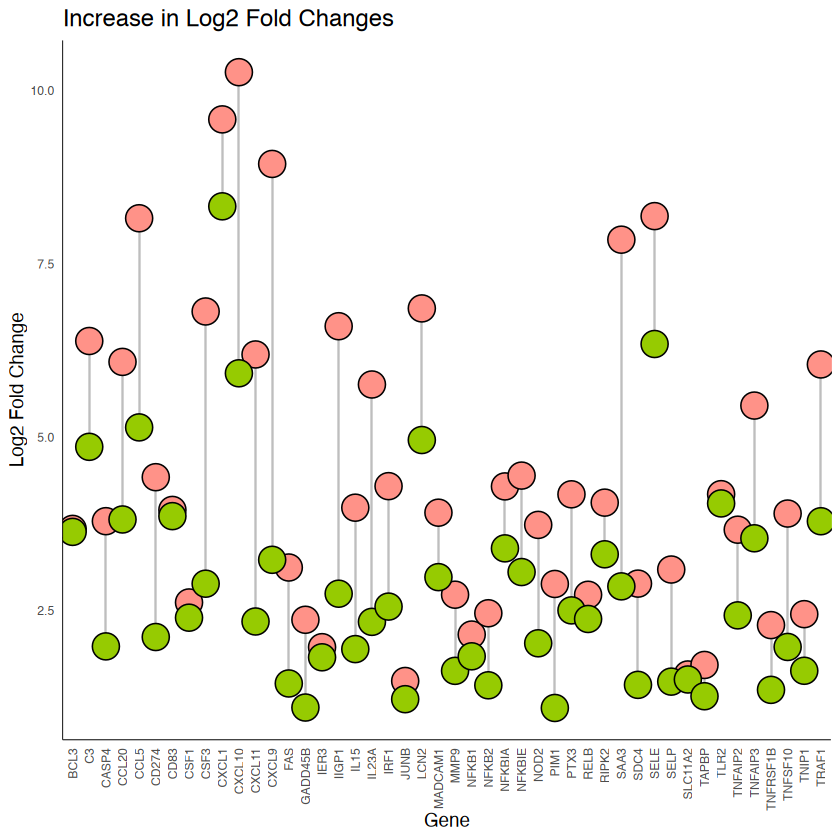

In [170]:
library(ggplot2)

# Creating the lollipop chart for increased genes with specified modifications
p_lollipop_decreased <- ggplot(decreased_genes, aes(x = Gene_name)) +
  geom_segment(aes(xend = Gene_name, y = log2FoldChange_I, yend = log2FoldChange_II), col = "grey") +
  geom_point(aes(y = log2FoldChange_I), color = 'black', size = 7, stroke = 0.5, shape = 21, fill = '#ff9288') +  # Specify shape and fill for a border
  geom_point(aes(y = log2FoldChange_II), color = 'black', size = 7, stroke = 0.5, shape = 21, fill = '#96cb01') + # Specify shape and fill for a border
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5, size = 7),
        axis.text.y = element_text(size = 7),
        axis.line = element_line(size = 0.2),   # Makes axis lines thicker
        panel.grid.major = element_blank(),    # Removes major grid lines
        panel.grid.minor = element_blank(),    # Removes minor grid lines
        plot.title = element_text(size = 14, face = "bold")) +
  labs(x = "Gene", y = "Log2 Fold Change", title = "Increase in Log2 Fold Changes")

# Display the plot
print(p_lollipop_decreased)

# Save the plot to a file with specified dimensions
ggsave("Decreased_Lollipop_Plot_mef.png", plot = p_lollipop_decreased, width = 12, height = 8, dpi = 300)

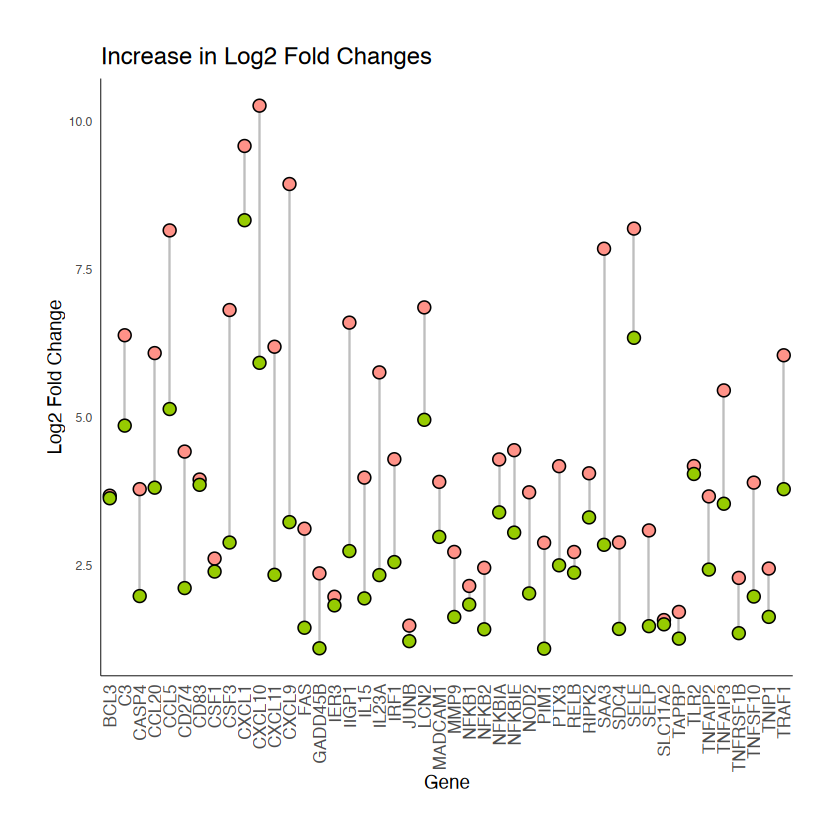

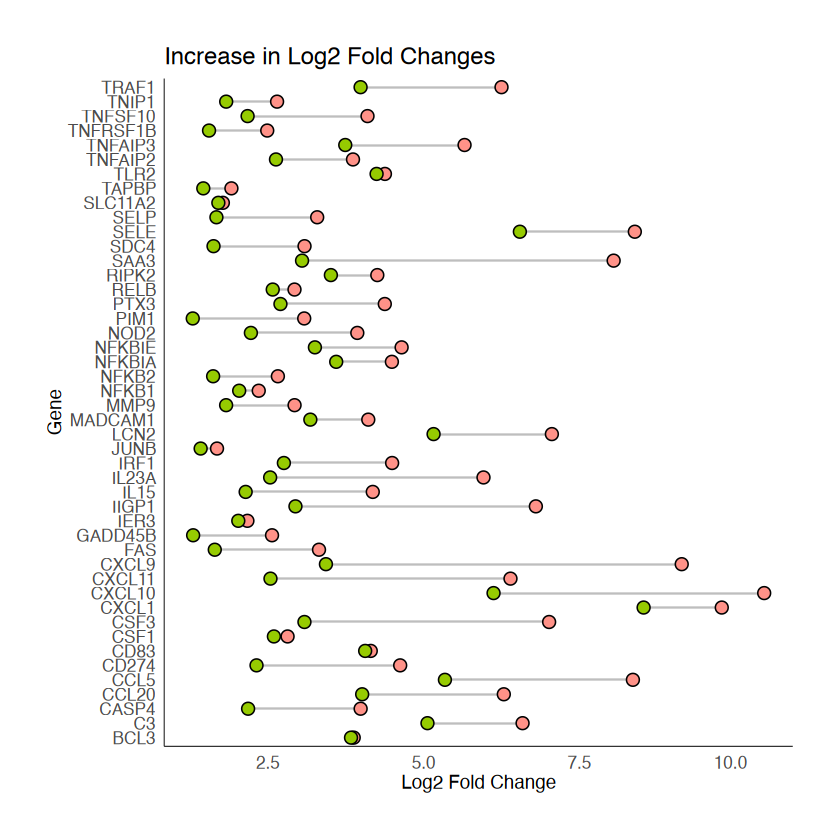

In [171]:
library(ggplot2)

# Data Preparation (Assuming 'decreased_genes' is your data frame)
# decreased_genes <- your_data_frame

# Function to create the lollipop chart
create_lollipop_plot <- function(data, orientation = "vertical") {
  p <- ggplot(data, aes(x = Gene_name)) +
    geom_segment(aes(xend = Gene_name, y = log2FoldChange_I, yend = log2FoldChange_II), col = "grey") +
    geom_point(aes(y = log2FoldChange_I), color = 'black', size = 3, stroke = 0.5, shape = 21, fill = '#ff9288') +  # Specify shape and fill for a border
    geom_point(aes(y = log2FoldChange_II), color = 'black', size = 3, stroke = 0.5, shape = 21, fill = '#96cb01') + # Specify shape and fill for a border
    theme_minimal() +
    theme(
      axis.text.x = element_text(angle = ifelse(orientation == "vertical", 90, 0), hjust = 1, vjust = 0.5, size = 10),  # Adjust font size
      axis.text.y = element_text(size = ifelse(orientation == "vertical", 7, 10)),  # Reduced font size
      axis.line = element_line(size = 0.2),   # Makes axis lines thicker
      panel.grid.major = element_blank(),    # Removes major grid lines
      panel.grid.minor = element_blank(),    # Removes minor grid lines
      plot.title = element_text(size = 14, face = "bold"),
      plot.margin = margin(1, 1, 1, 1, "cm") # Reduce white space around the plot
    ) +
    labs(x = "Gene", y = "Log2 Fold Change", title = "Increase in Log2 Fold Changes")
  
  if (orientation == "horizontal") {
    p <- p + coord_flip()  # Flip coordinates for horizontal plot
  }
  
  return(p)
}

# Creating vertical lollipop plot
p_lollipop_decreased_vertical <- create_lollipop_plot(decreased_genes, orientation = "vertical")
print(p_lollipop_decreased_vertical)

# Save the vertical plot to a file with specified dimensions
ggsave("Decreased_Lollipop_Plot_Vertical.png", plot = p_lollipop_decreased_vertical, width = 12, height = 8, dpi = 300)

# Creating horizontal lollipop plot
p_lollipop_decreased_horizontal <- create_lollipop_plot(decreased_genes, orientation = "horizontal")
print(p_lollipop_decreased_horizontal)

# Save the horizontal plot to a file with specified dimensions
ggsave("Decreased_Lollipop_Plot_Horizontal.png", plot = p_lollipop_decreased_horizontal, width = 12, height = 8, dpi = 300)


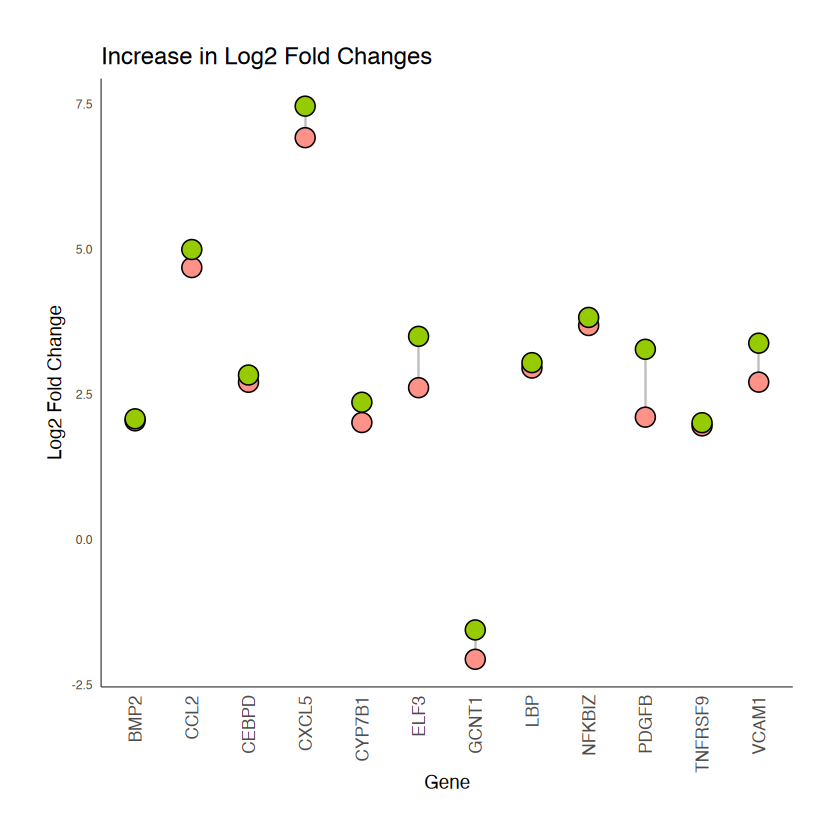

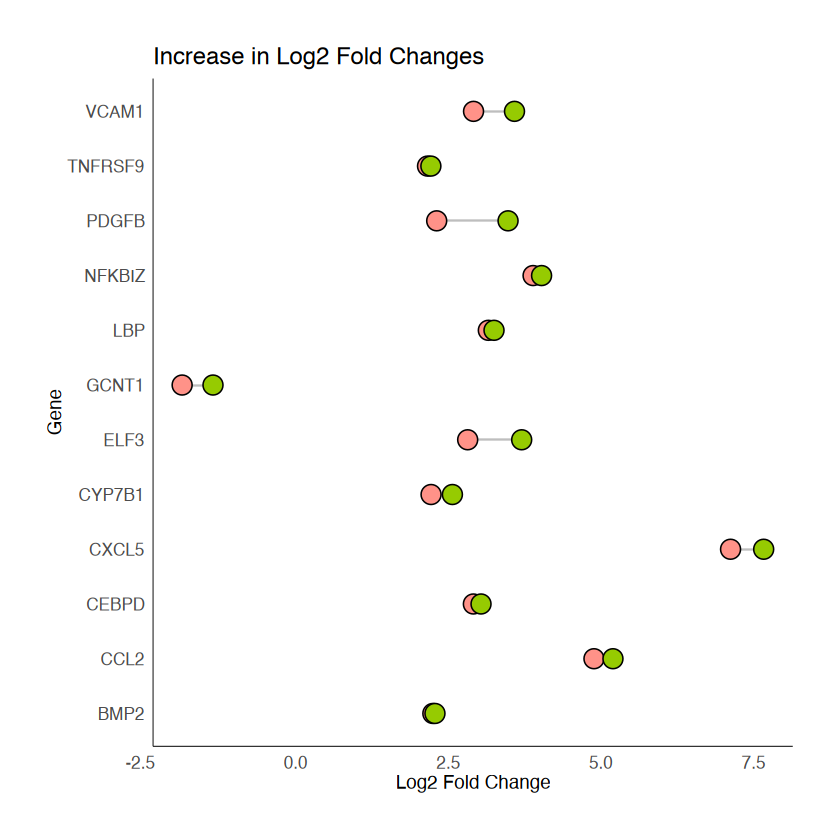

In [172]:
library(ggplot2)

# Data Preparation (Assuming 'increased_genes' is your data frame)
# increased_genes <- your_data_frame

# Function to create the lollipop chart
create_lollipop_plot <- function(data, orientation = "vertical") {
  p <- ggplot(data, aes(x = Gene_name)) +
    geom_segment(aes(xend = Gene_name, y = log2FoldChange_I, yend = log2FoldChange_II), col = "grey") +
    geom_point(aes(y = log2FoldChange_I), color = 'black', size = 5, stroke = 0.5, shape = 21, fill = '#ff9288') +  # Specify shape and fill for a border
    geom_point(aes(y = log2FoldChange_II), color = 'black', size = 5, stroke = 0.5, shape = 21, fill = '#96cb01') + # Specify shape and fill for a border
    theme_minimal() +
    theme(
      axis.text.x = element_text(angle = ifelse(orientation == "vertical", 90, 0), hjust = 1, vjust = 0.5, size = 10),  # Adjust font size
      axis.text.y = element_text(size = ifelse(orientation == "vertical", 7, 10)),  # Reduced font size for vertical
      axis.line = element_line(size = 0.2),   # Makes axis lines thicker
      panel.grid.major = element_blank(),    # Removes major grid lines
      panel.grid.minor = element_blank(),    # Removes minor grid lines
      plot.title = element_text(size = 14, face = "bold"),
      plot.margin = margin(1, 1, 1, 1, "cm") # Reduce white space around the plot
    ) +
    labs(x = "Gene", y = "Log2 Fold Change", title = "Increase in Log2 Fold Changes")
  
  if (orientation == "horizontal") {
    p <- p + coord_flip()  # Flip coordinates for horizontal plot
  }
  
  return(p)
}

# Creating vertical lollipop plot
p_lollipop_increased_vertical <- create_lollipop_plot(increased_genes, orientation = "vertical")
print(p_lollipop_increased_vertical)

# Save the vertical plot to a file with specified dimensions
ggsave("Increased_Lollipop_Plot_Vertical.png", plot = p_lollipop_increased_vertical, width = 12, height = 8, dpi = 300)

# Creating horizontal lollipop plot
p_lollipop_increased_horizontal <- create_lollipop_plot(increased_genes, orientation = "horizontal")
print(p_lollipop_increased_horizontal)

# Save the horizontal plot to a file with specified dimensions
ggsave("Increased_Lollipop_Plot_Horizontal.png", plot = p_lollipop_increased_horizontal, width = 12, height = 8, dpi = 300)


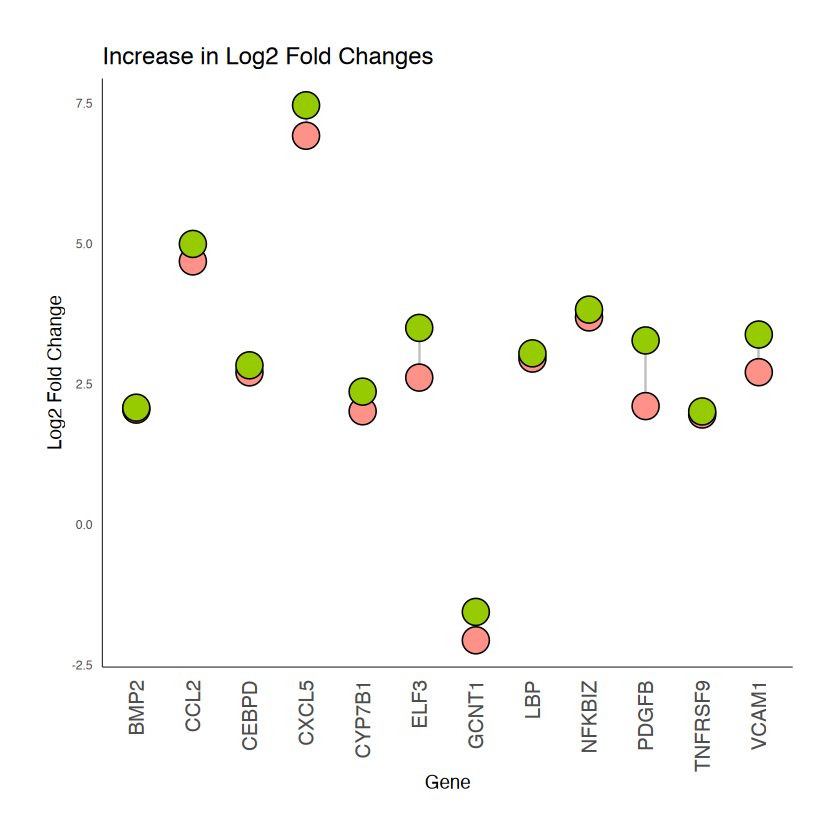

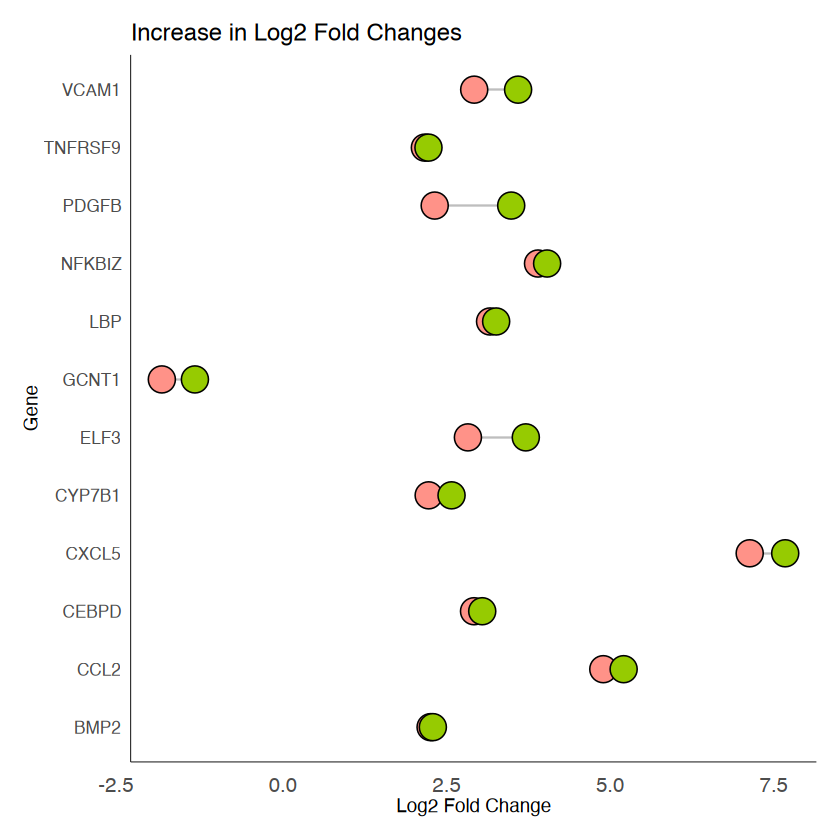

In [173]:
library(ggplot2)

# Data Preparation (Assuming 'increased_genes' is your data frame)
# increased_genes <- your_data_frame

# Function to create the lollipop chart
create_lollipop_plot <- function(data, orientation = "vertical") {
  p <- ggplot(data, aes(x = Gene_name)) +
    geom_segment(aes(xend = Gene_name, y = log2FoldChange_I, yend = log2FoldChange_II), col = "grey") +
    geom_point(aes(y = log2FoldChange_I), color = 'black', size = 7, stroke = 0.5, shape = 21, fill = '#ff9288') +  # Specify shape and fill for a border
    geom_point(aes(y = log2FoldChange_II), color = 'black', size = 7, stroke = 0.5, shape = 21, fill = '#96cb01') + # Specify shape and fill for a border
    theme_minimal() +
    theme(
      axis.text.x = element_text(angle = ifelse(orientation == "vertical", 90, 0), hjust = 1, vjust = 0.5, size = 12),  # Adjust font size
      axis.text.y = element_text(size = ifelse(orientation == "vertical", 7, 10), margin = margin(t = -10, r = 0, b = -10, l = 0)),  # Further reduce font size and remove more margin
      axis.ticks.length = unit(0.2, "cm"), # Adjust the length of ticks to reduce space
      axis.line = element_line(size = 0.2),   # Makes axis lines thicker
      panel.grid.major = element_blank(),    # Removes major grid lines
      panel.grid.minor = element_blank(),    # Removes minor grid lines
      plot.title = element_text(size = 14, face = "bold"),
      plot.margin = if (orientation == "horizontal") margin(0.5, 0.5, 0.5, 0.5, "cm") else margin(1, 1, 1, 1, "cm") # Reduce white space around the horizontal plot
    ) +
    labs(x = "Gene", y = "Log2 Fold Change", title = "Increase in Log2 Fold Changes")
  
  if (orientation == "horizontal") {
    p <- p + coord_flip()  # Flip coordinates for horizontal plot
  }
  
  return(p)
}

# Creating vertical lollipop plot
p_lollipop_increased_vertical <- create_lollipop_plot(increased_genes, orientation = "vertical")
print(p_lollipop_increased_vertical)

# Save the vertical plot to a file with specified dimensions
ggsave("Increased_Lollipop_Plot_Vertical.png", plot = p_lollipop_increased_vertical, width = 12, height = 8, dpi = 300)

# Creating horizontal lollipop plot
p_lollipop_increased_horizontal <- create_lollipop_plot(increased_genes, orientation = "horizontal")
print(p_lollipop_increased_horizontal)

# Save the horizontal plot to a file with specified dimensions
ggsave("Increased_Lollipop_Plot_Horizontal.png", plot = p_lollipop_increased_horizontal, width = 12, height = 8, dpi = 300)



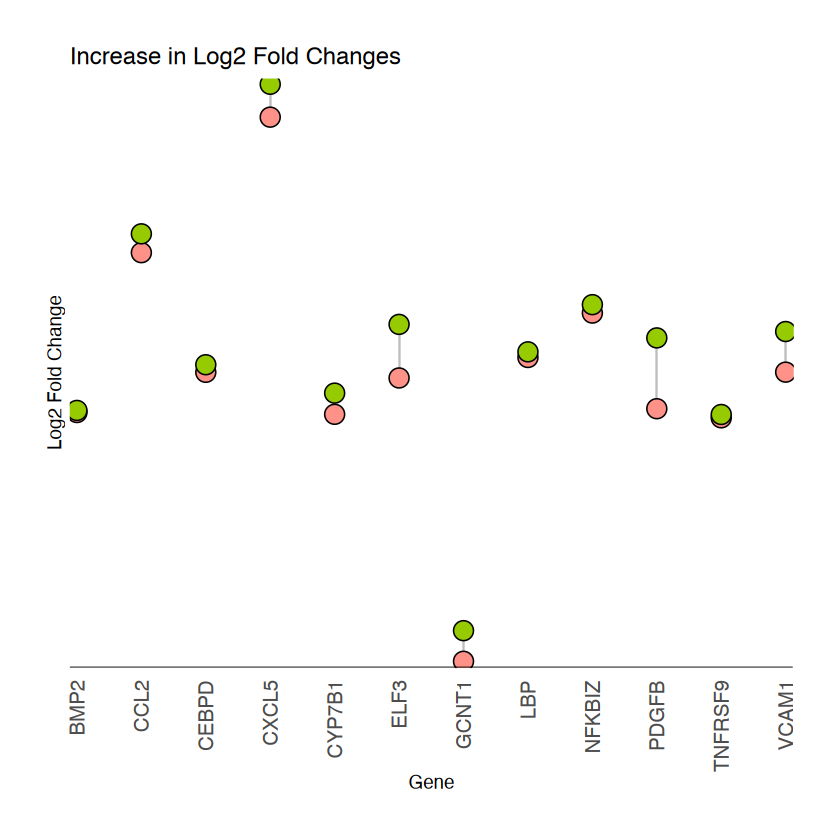

In [174]:
library(ggplot2)

# Data Preparation (Assuming 'increased_genes' is your data frame)
# increased_genes <- your_data_frame

# Function to create the lollipop chart
create_lollipop_plot <- function(data, orientation = "vertical") {
  p <- ggplot(data, aes(x = Gene_name)) +
    geom_segment(aes(xend = Gene_name, y = log2FoldChange_I, yend = log2FoldChange_II), col = "grey") +
    geom_point(aes(y = log2FoldChange_I), color = 'black', size = 5, stroke = 0.5, shape = 21, fill = '#ff9288') +  # Specify shape and fill for a border
    geom_point(aes(y = log2FoldChange_II), color = 'black', size = 5, stroke = 0.5, shape = 21, fill = '#96cb01') + # Specify shape and fill for a border
    theme_minimal() +
    theme(
      axis.text.x = element_text(angle = ifelse(orientation == "vertical", 90, 0), hjust = 1, vjust = 0.5, size = 12),  # Adjust font size and angle for x-axis
      axis.text.y = element_text(size = ifelse(orientation == "vertical", 7, 10)),  # Adjust font size for y-axis
      axis.ticks.length = unit(0.2, "cm"), # Adjust the length of ticks to reduce space
      axis.line = element_line(size = 0.2),   # Makes axis lines thicker
      panel.grid.major = element_blank(),    # Removes major grid lines
      panel.grid.minor = element_blank(),    # Removes minor grid lines
      plot.title = element_text(size = 14, face = "bold"),
      plot.margin = margin(1, 1, 1, 1, "cm")  # Increase white space around the plot to avoid cutting off labels
    ) +
    labs(x = "Gene", y = "Log2 Fold Change", title = "Increase in Log2 Fold Changes") +
    scale_x_discrete(expand = expansion(mult = c(0.01, 0.01))) +  # Reduce gaps between x-axis labels
    scale_y_discrete(expand = expansion(mult = c(0.01, 0.01)))  # Reduce gaps between y-axis labels
  
  if (orientation == "horizontal") {
    p <- p + coord_flip()  # Flip coordinates for horizontal plot
  }
  
  return(p)
}

# Creating vertical lollipop plot
p_lollipop_increased_vertical <- create_lollipop_plot(increased_genes, orientation = "vertical")
print(p_lollipop_increased_vertical)

# Save the vertical plot to a file with specified dimensions
ggsave("Increased_Lollipop_Plot_Vertical.png", plot = p_lollipop_increased_vertical, width = 8, height = 12, dpi = 300)  # Increased height to avoid cutting labels



In [175]:
library(ggplot2)

# Data Preparation (Assuming 'increased_genes' is your data frame)
# increased_genes <- your_data_frame

# Function to create the lollipop chart
create_lollipop_plot <- function(data, orientation = "vertical") {
  p <- ggplot(data, aes(x = Gene_name)) +
    geom_segment(aes(xend = Gene_name, y = log2FoldChange_I, yend = log2FoldChange_II), col = "grey") +
    geom_point(aes(y = log2FoldChange_I), color = 'black', size = 5, stroke = 0.5, shape = 21, fill = '#ff9288') +  # Specify shape and fill for a border
    geom_point(aes(y = log2FoldChange_II), color = 'black', size = 5, stroke = 0.5, shape = 21, fill = '#96cb01') + # Specify shape and fill for a border
    theme_minimal() +
    theme(
      axis.text.x = element_text(angle = ifelse(orientation == "vertical", 90, 0), hjust = 1, vjust = 0.5, size = 10),  # Adjust font size and angle for x-axis
      axis.text.y = element_text(size = ifelse(orientation == "vertical", 7, 10), margin = margin(t = 0, r = 0, b = 0, l = 0)),  # Adjust font size for y-axis
      axis.ticks.length = unit(0.05, "cm"), # Adjust the length of ticks to reduce space
      axis.line = element_line(size = 0.2),   # Makes axis lines thicker
      panel.grid.major = element_blank(),    # Removes major grid lines
      panel.grid.minor = element_blank(),    # Removes minor grid lines
      plot.title = element_text(size = 14, face = "bold"),
      plot.margin = if (orientation == "horizontal") margin(0.1, 0.1, 0.1, 0.1, "cm") else margin(1, 1, 1, 1, "cm") # Reduce white space around the plot
    ) +
    labs(x = "Gene", y = "Log2 Fold Change", title = "Increase in Log2 Fold Changes") +
    scale_x_discrete(expand = expansion(mult = c(0.01, 0.01)))  # Reduce gaps between x-axis labels
  
  if (orientation == "horizontal") {
    p <- p + coord_flip()  # Flip coordinates for horizontal plot
  }
  
  return(p)
}

# Creating vertical lollipop plot
p_lollipop_increased_vertical <- create_lollipop_plot(increased_genes, orientation = "vertical")
print(p_lollipop_increased_vertical)

# Save the vertical plot to a file with specified dimensions
ggsave("Increased_Lollipop_Plot_Vertical.png", plot = p_lollipop_increased_vertical, width = 12, height = 8, dpi = 300)

# Creating horizontal lollipop plot
p_lollipop_increased_horizontal <- create_lollipop_plot(increased_genes, orientation = "horizontal")
print(p_lollipop_increased_horizontal)

/# Save the horizontal plot to a file with specified dimensions
ggsave("Increased_Lollipop_Plot_Horizontal.png", plot = p_lollipop_increased_horizontal, width = 12, height = 8, dpi = 300)


ERROR: Error in parse(text = input): <text>:44:1: unexpected '/'
43: 
44: /
    ^


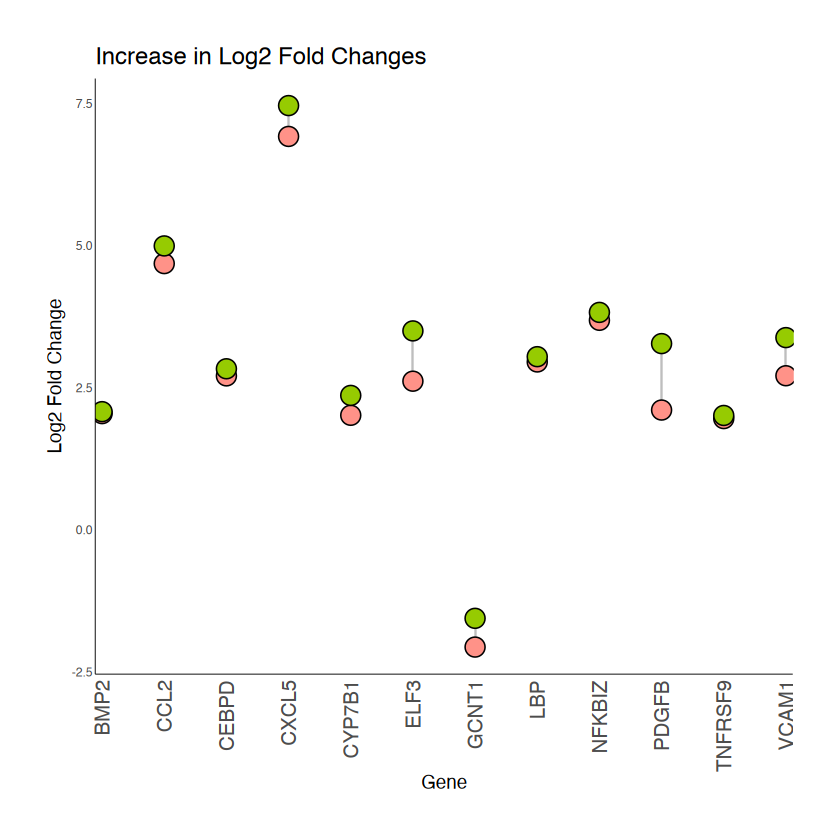

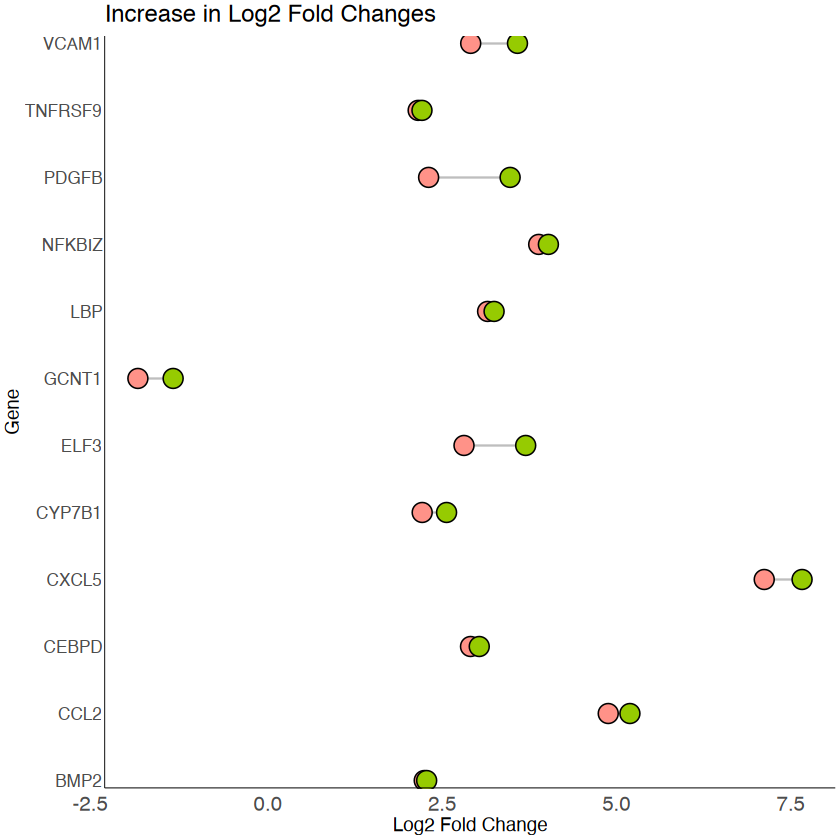

In [176]:
library(ggplot2)

# Data Preparation (Assuming 'increased_genes' is your data frame)
# increased_genes <- your_data_frame

# Function to create the lollipop chart
create_lollipop_plot <- function(data, orientation = "vertical") {
  p <- ggplot(data, aes(x = Gene_name)) +
    geom_segment(aes(xend = Gene_name, y = log2FoldChange_I, yend = log2FoldChange_II), col = "grey") +
    geom_point(aes(y = log2FoldChange_I), color = 'black', size = 5, stroke = 0.5, shape = 21, fill = '#ff9288') +  # Specify shape and fill for a border
    geom_point(aes(y = log2FoldChange_II), color = 'black', size = 5, stroke = 0.5, shape = 21, fill = '#96cb01') + # Specify shape and fill for a border
    theme_minimal() +
    theme(
      axis.text.x = element_text(angle = ifelse(orientation == "vertical", 90, 0), hjust = 1, vjust = 0.5, size = 12),  # Adjust font size and angle for x-axis
      axis.text.y = element_text(size = ifelse(orientation == "vertical", 7, 10), margin = margin(t = 0, r = 0, b = 0, l = 0)),  # Adjust font size for y-axis
      axis.ticks.length = unit(0.05, "cm"), # Adjust the length of ticks to reduce space
      axis.line = element_line(size = 0.2),   # Makes axis lines thicker
      panel.grid.major = element_blank(),    # Removes major grid lines
      panel.grid.minor = element_blank(),    # Removes minor grid lines
      plot.title = element_text(size = 14, face = "bold"),
      plot.margin = if (orientation == "horizontal") margin(0.1, 0.1, 0.1, 0.1, "cm") else margin(1, 1, 1, 1, "cm") # Reduce white space around the plot
    ) +
    labs(x = "Gene", y = "Log2 Fold Change", title = "Increase in Log2 Fold Changes") +
    scale_x_discrete(expand = expansion(mult = c(0.01, 0.01)))  # Reduce gaps between x-axis labels
  
  if (orientation == "horizontal") {
    p <- p + coord_flip()  # Flip coordinates for horizontal plot
  }
  
  return(p)
}

# Creating vertical lollipop plot
p_lollipop_increased_vertical <- create_lollipop_plot(increased_genes, orientation = "vertical")
print(p_lollipop_increased_vertical)

# Save the vertical plot to a file with specified dimensions
ggsave("Increased_Lollipop_Plot_Vertical.png", plot = p_lollipop_increased_vertical, width = 12, height = 8, dpi = 300)

# Creating horizontal lollipop plot
p_lollipop_increased_horizontal <- create_lollipop_plot(increased_genes, orientation = "horizontal")
print(p_lollipop_increased_horizontal)

# Save the horizontal plot to a file with specified dimensions
ggsave("Increased_Lollipop_Plot_Horizontal.png", plot = p_lollipop_increased_horizontal, width = 12, height = 8, dpi = 300)


In [177]:
library(dplyr)

# Calculate the absolute differences and categorize them
categorized_genes <- decreased_genes %>%
  mutate(Difference = abs(log2FoldChange_I - log2FoldChange_II)) %>%
  mutate(Category = case_when(
    Difference >= 1.5   ~ "High Difference",
    Difference <= 0.5 ~ "Low Difference",
    TRUE              ~ "Moderate Difference"
  ))

categorized_genes <- categorized_genes %>%
  mutate(Gene_name = str_to_title(Gene_name))

write.csv(categorized_genes,"decreasing_genes_mef_all_entries_lollipop_plot.csv")

# Optionally, filter and view genes with high, low, or moderate differences
high_difference_genes <- filter(categorized_genes, Category == "High Difference")
low_difference_genes <- filter(categorized_genes, Category == "Low Difference")
moderate_difference_genes <- filter(categorized_genes, Category == "Moderate Difference")

write.table(high_difference_genes$Gene_name,"decreasing_genes_mef_high_difference_genes_lollipop_plot.txt", row.names = FALSE, col.names = FALSE, quote = FALSE)
write.table(low_difference_genes$Gene_name,"decreasing_genes_mef_low_difference_genes_lollipop_plot.txt", row.names = FALSE, col.names = FALSE, quote = FALSE)
write.table(moderate_difference_genes$Gene_name,"decreasing_genes_mef_moderate_difference_genes_lollipop_plot.txt", row.names = FALSE, col.names = FALSE, quote = FALSE)


In [178]:
library(dplyr)

# Calculate the absolute differences and categorize them
categorized_genes <- increased_genes %>%
  mutate(Difference = abs(log2FoldChange_I - log2FoldChange_II)) %>%
  mutate(Category = case_when(
    Difference >= 1.5   ~ "High Difference",
    Difference <= 0.5 ~ "Low Difference",
    TRUE              ~ "Moderate Difference"
  ))

categorized_genes <- categorized_genes %>%
  mutate(Gene_name = str_to_title(Gene_name))

write.csv(categorized_genes,"increasing_genes_mef_all_entries_lollipop_plot.csv")

# Optionally, filter and view genes with high, low, or moderate differences
high_difference_genes <- filter(categorized_genes, Category == "High Difference")
low_difference_genes <- filter(categorized_genes, Category == "Low Difference")
moderate_difference_genes <- filter(categorized_genes, Category == "Moderate Difference")



write.table(high_difference_genes$Gene_name,"increasing_genes_mef_high_difference_genes_lollipop_plot.txt", row.names = FALSE, col.names = FALSE, quote = FALSE)
write.table(low_difference_genes$Gene_name,"increasing_genes_mef_low_difference_genes_lollipop_plot.txt", row.names = FALSE, col.names = FALSE, quote = FALSE)
write.table(moderate_difference_genes$Gene_name,"increasing_genes_mef_moderate_difference_genes_lollipop_plot.txt", row.names = FALSE, col.names = FALSE, quote = FALSE)

pdf 
  3

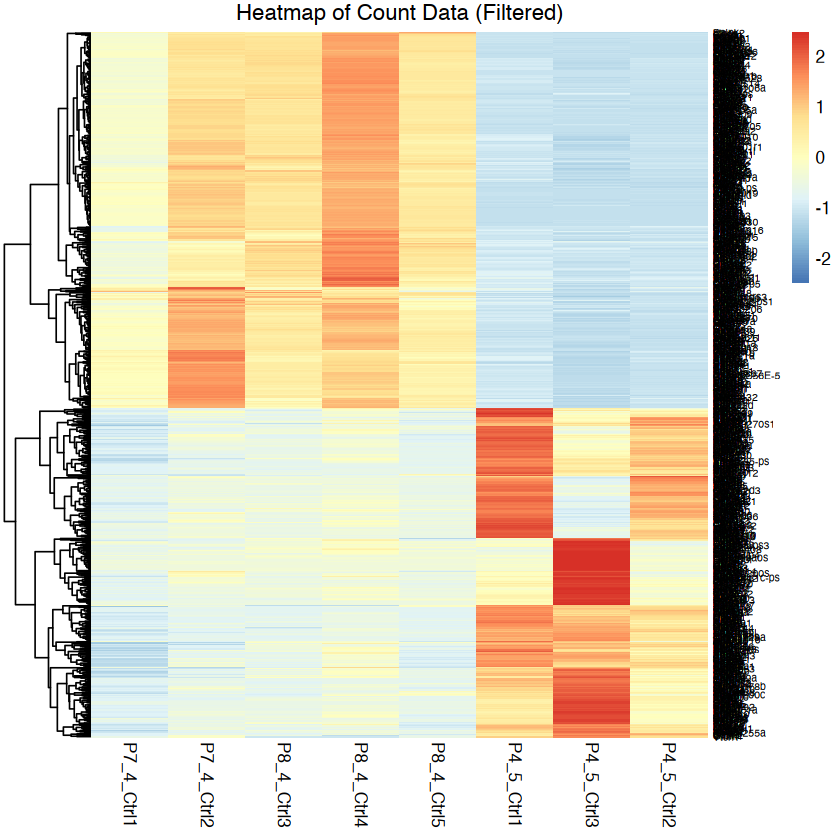

In [179]:
# Open a JPEG device with large dimensions to improve visibility
jpeg("heatmap_plot.jpeg", width = 11, height = 17, units = 'in', res = 300)

# Generate and save the heatmap
pheatmap(filtered_matrix, 
         scale = "row",
         clustering_distance_rows = "euclidean",
         clustering_method = "complete",
         cluster_cols = FALSE, # Do not cluster columns
         show_rownames = TRUE,
         show_colnames = TRUE,
         main = "Heatmap of Count Data (Filtered)",
         fontsize_row = 6) # You might need to adjust this based on visibility in the JPEG

# Close the JPEG device to save the plot
dev.off()


In [180]:
getwd()

[1] "/Users/sshome/Desktop/backup_Jan3_2025/Bioinformatics_projects/Bulk_RNA_seqdata_sp3/cluster_data"

Warning message:
"One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value..."


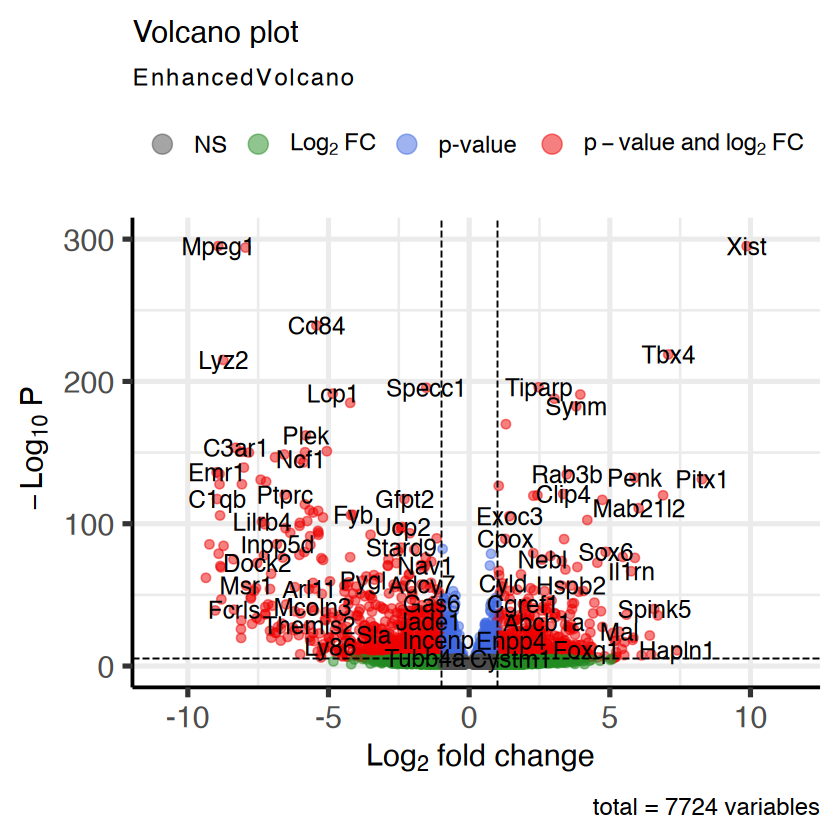

In [181]:
# Number of genes to label
N <- 10  

# Sorting the data frame based on the criteria (e.g., padj)
sorted_indices <- order(res2_III$padj)

# Initializing labels to NA
res2_III$labels <- NA

# Selecting top N genes based on sorted indices
top_N_indices <- sorted_indices[1:N]

# Identifying those among the top N that need to be filtered out
filtered_indices <- top_N_indices[grepl("^Gm|-ik$|Mir|^Rpl", res2_III$SYMBOL[top_N_indices])]

# Identifying how many more genes we need to pick
num_more <- length(filtered_indices)

# Picking the next top-most genes that are valid
next_valid_indices <- sorted_indices[(N + 1):(N + num_more)]
next_valid_indices <- next_valid_indices[!grepl("^Gm|-ik$|Mir|^Rpl", res2_III$SYMBOL[next_valid_indices])]

# Combining the valid top indices and the next valid indices to get top N labels
final_top_N_indices <- c(setdiff(top_N_indices, filtered_indices), next_valid_indices[1:num_more])

# Filtering out NA indices
final_top_N_indices <- final_top_N_indices[!is.na(final_top_N_indices)]
final_top_N_indices <- final_top_N_indices[!is.na(res2_III$SYMBOL[final_top_N_indices])]

# Checking if any of the final_top_N_indices are NA or if corresponding SYMBOLs are NA
if (any(is.na(final_top_N_indices)) || any(is.na(res2_III$SYMBOL[final_top_N_indices]))) {
    stop("NA indices detected. Please resolve before proceeding.")
}

# Setting the labels for these final top N indices
res2_III$labels[final_top_N_indices] <- res2_III$SYMBOL[final_top_N_indices]

# Creating the EnhancedVolcano plot
EnhancedVolcano(res2_III,
                lab = rownames(res2_III),
                x = 'log2FoldChange',
                y = 'padj')


In [182]:
res2_I_df <- data.frame(res2_I)
res2_II_df <- data.frame(res2_II)
res2_III_df <- data.frame(res2_III)

In [190]:
res2_I_full <- data.frame(res2_I_full)
res2_II_full <- data.frame(res2_II_full)

In [191]:
colnames(res2_II_full)

[1] "gene"           "baseMean"       "log2FoldChange" "lfcSE"         
[5] "stat"           "pvalue"         "padj"           "labels"

In [192]:
res2_II_full

gene baseMean log2FoldChange lfcSE stat pvalue padj labels

In [186]:
colnames(res2_I_full)

[1] "baseMean"       "log2FoldChange" "lfcSE"          "stat"          
[5] "pvalue"         "padj"           "labels"

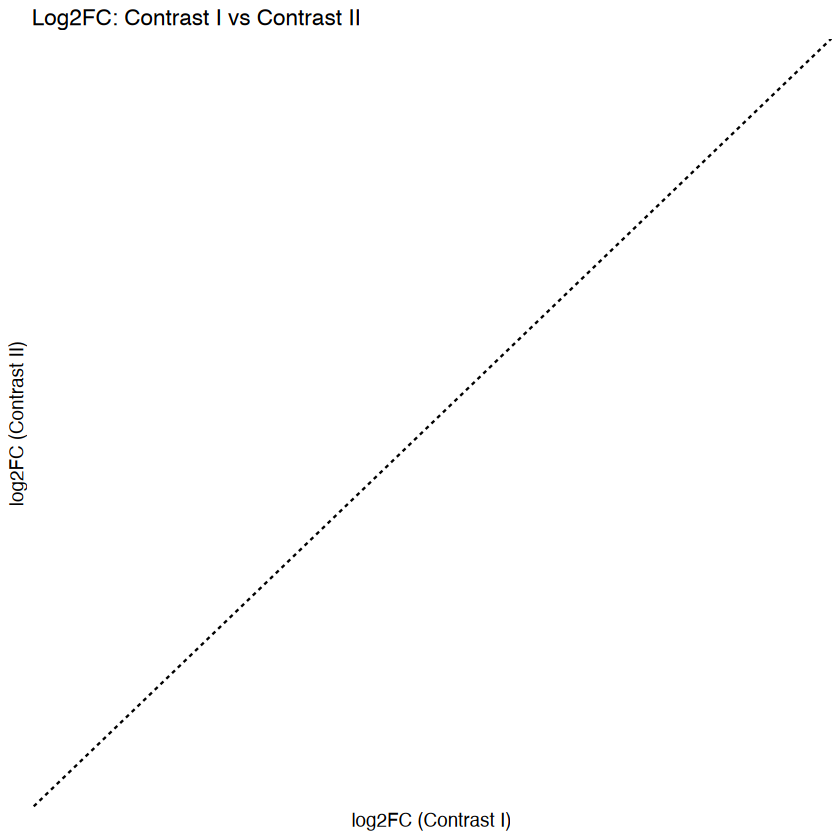

In [189]:
# install.packages(c("dplyr","tibble","ggplot2"))  # uncomment if needed
library(dplyr)
library(tibble)
library(ggplot2)

# Helper: convert a DESeq2 result object to a data.frame with:
#  • rownames pulled into uppercase "gene"
#  • renamed log2FoldChange → log2FC and padj → padj
#  • prefixed columns so they’re unique
prepare_res_df <- function(res_obj, prefix) {
  df <- as.data.frame(res_obj)
  # drop any existing "gene" column to avoid duplicates
  if ("gene" %in% colnames(df)) df$gene <- NULL
  
  df %>%
    rownames_to_column(var = "gene") %>%
    mutate(gene = toupper(gene)) %>%
    rename(
      log2FC = log2FoldChange,
      padj   = padj
    ) %>%
    rename_with(
      ~ paste0(prefix, "_", .),
      c("log2FC", "padj")
    )
}

# Prepare only Contrast I and Contrast II
res_I  <- prepare_res_df(res2_I_full,  "I")
res_II <- prepare_res_df(res2_II_full, "II")

# Merge on the single, true "gene" column
merged_df <- res_I %>%
  select(all_of(c("gene", "I_log2FC",  "I_padj"))) %>%
  inner_join(
    res_II %>% select(all_of(c("gene", "II_log2FC", "II_padj"))),
    by = "gene"
  ) %>%
  # (optional) rename for plotting convenience
  rename(
    log2FC_I  = I_log2FC,
    log2FC_II = II_log2FC
  )

# Scatterplot of Contrast I vs Contrast II
ggplot(merged_df, aes(x = log2FC_I, y = log2FC_II)) +
  geom_point(alpha = 0.6) +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed") +
  theme_minimal() +
  labs(
    title = "Log2FC: Contrast I vs Contrast II",
    x     = "log2FC (Contrast I)",
    y     = "log2FC (Contrast II)"
  ) +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


In [ ]:
lmc_data <- read.csv('merged_LMC_I_II_III_deseq2results.csv')

In [ ]:
res2_I_df$gene <- rownames(res2_I_df)
res2_II_df$gene <- rownames(res2_II_df)


merged_data_mef <- merge(res2_I_df, res2_II_df, by="gene", suffixes = c("_I", "_II"))

res2_III_df <- data.frame(res2_III)
res2_III_df$gene <- rownames(res2_III_df)
mef_data <- merge(merged_data_mef, res2_III_df, by="gene", suffixes = c("", "_III"))


mef_data <- mef_data %>%
  rename_with(.fn = ~paste0(., "_III"), .cols = tail(names(mef_data), 6))



In [ ]:
library(ggplot2)

In [ ]:
ggplot(res2_II_df, aes(x = baseMean, y = log2FoldChange)) +
  geom_point(alpha = 0.6) + # Set alpha for better visualization if points overlap
  scale_x_log10() + # Log-transform the baseMean axis for better visualization
  theme_minimal() +
  labs(x = "Base Mean (log scale)", 
       y = "Log2 Fold Change", 
       title = "Scatter Plot of baseMean vs. log2FoldChange") +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red") # Add a horizontal line at y=0

In [ ]:
ggplot(res2_I_df, aes(x = baseMean, y = log2FoldChange)) +
  geom_point(alpha = 0.6) + # Set alpha for better visualization if points overlap
  scale_x_log10() + # Log-transform the baseMean axis for better visualization
  theme_minimal() +
  labs(x = "Base Mean (log scale)", 
       y = "Log2 Fold Change", 
       title = "Scatter Plot of baseMean vs. log2FoldChange") +
  geom_hline(yintercept = 0, linetype = "dashed", color = "red")

In [ ]:
library(ggplot2)

# Assuming your datasets are read into data frames named `lmc_data` and `mef_data`
# You can read your data with something like:
# lmc_data <- read.csv("path_to_your_lmc_data_file.csv")
# mef_data <- read.csv("path_to_your_mef_data_file.csv")

# 1. Comparison of I conditions between lmc_data and mef_data
ggplot() +
  geom_point(data = mef_data, aes(x = baseMean_I, y = log2FoldChange_I), color = "blue", alpha = 0.5) +
  geom_point(data = lmc_data, aes(x = baseMean_I, y = log2FoldChange_I), color = "red", alpha = 0.5) +
  labs(title = "Comparison of Condition I: MEF vs LMC", x = "Base Mean", y = "Log2 Fold Change") +
  scale_color_manual(values = c("MEF" = "blue", "LMC" = "red")) +
  theme_minimal()



In [ ]:
# Load necessary library for plotting
library(ggplot2)

# Plotting
ggplot(mef_data, aes(x = log2FoldChange_I, y = log2FoldChange_II)) +
  geom_point() +  # Add points
  geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "red") + # Add y=x line for reference
  theme_minimal() +  # Use a minimal theme
  labs(x = "Log2 Fold Change (res2_I)", y = "Log2 Fold Change (res2_II)", 
       title = "Comparison of Log2 Fold Changes between res2_I and res2_II") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))  # Improve label readability

In [ ]:
# Load necessary library for plotting
library(ggplot2)

# Plotting
ggplot(lmc_data, aes(x = log2FoldChange_I, y = log2FoldChange_II)) +
  geom_point() +  # Add points
  geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "red") + # Add y=x line for reference
  theme_minimal() +  # Use a minimal theme
  labs(x = "Log2 Fold Change (res2_I)", y = "Log2 Fold Change (res2_II)", 
       title = "Comparison of Log2 Fold Changes between res2_I and res2_II") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))  # Improve label readability

In [ ]:
#install.packages('htmlwidgets')

In [ ]:
# 2. Comparison of II conditions between lmc_data and mef_data
ggplot() +
  geom_point(data = mef_data, aes(x = baseMean_II, y = log2FoldChange_II), color = "blue", alpha = 0.5) +
  geom_point(data = lmc_data, aes(x = baseMean_II, y = log2FoldChange_II), color = "red", alpha = 0.5) +
  labs(title = "Comparison of Condition II: MEF vs LMC", x = "Base Mean", y = "Log2 Fold Change") +
  scale_color_manual(values = c("MEF" = "blue", "LMC" = "red")) +
  theme_minimal()

In [ ]:
ggplot(mef_data, aes(x = log2FoldChange_I, y = log2FoldChange_II)) +
  geom_point(alpha = 0.5) + # Plot points with semi-transparency for better visualization
  geom_abline(slope = 1, intercept = 0, color = "red", linetype = "dashed") + # Add diagonal line
  labs(title = "MEF Data: Comparison of Log2 Fold Change between Conditions I and II", 
       x = "Log2 Fold Change I", 
       y = "Log2 Fold Change II") +
  theme_minimal() # Use minimal theme for a clean look

In [ ]:
ggplot(lmc_data, aes(x = log2FoldChange_I, y = log2FoldChange_II)) +
  geom_point(alpha = 0.5) + # Plot points with semi-transparency for better visualization
  geom_abline(slope = 1, intercept = 0, color = "red", linetype = "dashed") + # Add diagonal line
  labs(title = "LMC Data: Comparison of Log2 Fold Change between Conditions I and II", 
       x = "Log2 Fold Change I", 
       y = "Log2 Fold Change II") +
  theme_minimal() # Use minimal theme for a clean look

In [ ]:
comparison_data <- merge(mef_data, lmc_data, by = "gene", suffixes = c("_MEF", "_LMC"))

# Now plot baseMean_I from MEF vs baseMean_I from LMC
ggplot(comparison_data, aes(x = log2FoldChange_III_MEF, y = log2FoldChange_III_LMC)) +
  geom_point(alpha = 0.5) +  # Adjust opacity if points are too dense
  geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "red") +  # Add a y=x reference line
  labs(title = "Comparison of log2 Fold Change III between MEF and LMC", x = "Log2 FoldChange III MEF", y = "Log2 FoldChange III LMC") +
  theme_minimal()

In [ ]:
# Loading the DE genes from analysis I and II
gene_list_I <- na.omit(rownames(res2_I))  # Remove NAs
gene_list_II <- na.omit(rownames(res2_II))  # Remove NAs

# Making a list of the gene lists
gene_lists <- list(gene_list_I, gene_list_II)

# Run the venn diagram function
venn.plot <- venn.diagram(
    x = gene_lists,
    filename = NULL,
    category.names = c("", ""),  # Set as empty strings
    output = TRUE,
    fill = c("red", "blue"),
    alpha = 0.5,
    fontface = "bold",
    fontsize = 20,
    cat.fontface = "bold",
    cat.fontsize = 20,
    lty = "solid",
    lwd = 2,
    label.col = "black",  # Set this to "black" to show numbers
    category.pos = NULL  # Set to NULL to avoid positioning non-existing labels
)
# Plot the diagram
grid.draw(venn.plot)

In [ ]:
#Reading the list of DE genes from analysis I,II,III,IV,V respectively and merge them together for next analyses.

DE_I <- data.frame(rownames(res2_I))
DE_II <- data.frame(rownames(res2_II))
DE_III <- data.frame(rownames(res2_III))


colnames(DE_I)[1] <- "Gene_name"
colnames(DE_II)[1] <- "Gene_name"
colnames(DE_III)[1] <- "Gene_name"




In [ ]:
combined_column <- unique(data.frame(c(DE_I$Gene_name,DE_II$Gene_name,DE_III$Gene_name)))
colnames(combined_column)[1] <- "Gene_name"
length(combined_column$Gene_name)

In [ ]:
write.csv(combined_column,"MEF_DE_genes_total_Jan15_2024.csv")

Carrying out gene-set enrichment analysis as highlighted in the following link : https://learn.gencore.bio.nyu.edu/rna-seq-analysis/gene-set-enrichment-analysis/

In [ ]:
# Setting the organism mouse
organism = "org.Mm.eg.db"
library(organism, character.only = TRUE)

In [ ]:
#Reformatting the list of genes for the plot
original_gene_list1 <- res2_I$log2FoldChange
names(original_gene_list1) <- rownames(res2_I)
gene_list1<-na.omit(original_gene_list1)
# sorting the list in decreasing order (required for clusterProfiler)
gene_list1 = sort(gene_list1, decreasing = TRUE)

#Reformatting the list of genes for the plot
original_gene_list2 <- res2_II$log2FoldChange
names(original_gene_list2) <- rownames(res2_II)
gene_list2<-na.omit(original_gene_list2)
# sorting the list in decreasing order (required for clusterProfiler)
gene_list2 = sort(gene_list2, decreasing = TRUE)

#Reformatting the list of genes for the plot
original_gene_list3 <- res2_III$log2FoldChange
names(original_gene_list3) <- rownames(res2_III)
gene_list3<-na.omit(original_gene_list3)
# sorting the list in decreasing order (required for clusterProfiler)
gene_list3 = sort(gene_list3, decreasing = TRUE)

In [ ]:
gse1 <- gseGO(geneList=gene_list1, 
             ont ="BP", 
             keyType = "SYMBOL", 
             nPerm = 10000, 
             minGSSize = 3, 
             maxGSSize = 800, 
             pvalueCutoff = 0.2, 
             verbose = TRUE, 
             OrgDb = organism, 
             pAdjustMethod = "BH")

gse2 <- gseGO(geneList=gene_list2, 
             ont ="BP", 
             keyType = "SYMBOL", 
             nPerm = 10000, 
             minGSSize = 3, 
             maxGSSize = 800, 
             pvalueCutoff = 0.2, 
             verbose = TRUE, 
             OrgDb = organism, 
             pAdjustMethod = "BH")


gse3 <- gseGO(geneList=gene_list3, 
             ont ="BP", 
             keyType = "SYMBOL", 
             nPerm = 10000, 
             minGSSize = 3, 
             maxGSSize = 800, 
             pvalueCutoff = 0.2, 
             verbose = TRUE, 
             OrgDb = organism, 
             pAdjustMethod = "BH")



In [ ]:
gse_termsim1 <- pairwise_termsim(gse1)
gse_termsim2 <- pairwise_termsim(gse2)
gse_termsim3 <- pairwise_termsim(gse3)

In [ ]:
genelist_gse3 <- data.frame(gse3@geneList)
colnames(genelist_gse3)[1] <- "FoldChange"

write.csv(genelist_gse3,'genelist_III_MEF_gsea_results.csv')

In [ ]:
require(DOSE)
dotplot(gse1, showCategory=20, split=".sign") + facet_grid(.~.sign)
dotplot(gse2, showCategory=20, split=".sign") + facet_grid(.~.sign)
dotplot(gse3, showCategory=20, split=".sign") + facet_grid(.~.sign)

In [ ]:
GO_I_mef <- data.frame(gse1@result)
GO_II_mef <- data.frame(gse2@result)
GO_III_mef <- data.frame(gse3@result)

In [ ]:
write.csv(countData2,'MEF_May13_2025_analysis_counts.csv')

In [ ]:
View(as.data.frame(gse1))

In [ ]:
gse1@result$Description <- sub("^(\\w)", "\\U\\1", gse1@result$Description, perl = TRUE)

In [ ]:
dotplot(gse1,showCategory=c("Cellular response to interferon-beta","Antimicrobial humoral response","Cellular response to lipopolysaccharide","Neutrophil migration","Embryonic skeletal system morphogenesis", "B cell receptor signaling pathway","Response to lipopolysaccharide"),split=".sign")+ facet_grid(.~.sign)

In [ ]:
write.csv(GO_I_mef,'mef_GO_I_GSEA_clusterprofiler.csv')
write.csv(GO_II_mef,'mef_GO_II_GSEA_clusterprofiler.csv')
write.csv(GO_III_mef,'mef_GO_III_GSEA_clusterprofiler.csv')


In [ ]:
gse2@result$Description <- sub("^(\\w)", "\\U\\1", gse2@result$Description, perl = TRUE)

In [ ]:
View(as.data.frame(gse2))

In [ ]:
gse3@result$Description <- sub("^(\\w)", "\\U\\1", gse3@result$Description, perl = TRUE)

In [ ]:
dotplot(gse3,showCategory=c("Spindle checkpoint signaling","Peripheral nervous system neuron differentiation","Negative regulation of chromosome segregation","Innate immune response","Response to external biotic stimulus","biological process involved in interspecies interaction between organisms","Plasma membrane invagination","Hemopoiesis","Embryonic morphogenesis","Medium-chain fatty acid metabolic process"),split=".sign")+ facet_grid(.~.sign)

In [ ]:
dotplot(gse3,showCategory=c("Spindle checkpoint signaling","Peripheral nervous system neuron differentiation","Negative regulation of chromosome segregation","Innate immune response","Response to external biotic stimulus","biological process involved in interspecies interaction between organisms","Plasma membrane invagination","Hemopoiesis","Embryonic morphogenesis","Medium-chain fatty acid metabolic process"),split=".sign")+ facet_grid(.~.sign)

In [ ]:
# Assuming `p` is your ggplot object
p <- ridgeplot(gse1) +
  labs(x = "enrichment distribution") +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 8),  # Rotate and reduce text size
    axis.text.y = element_text(size = 6),  # Further reduce text size for y-axis
    strip.text.y = element_text(size = 6, angle = 0)  # Reduce facet label size and optionally rotate
  ) +
  coord_fixed(ratio = 0.7)  # Adjust aspect ratio

p <- ridgeplot(gse2) +
  labs(x = "enrichment distribution") +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 8),  # Rotate and reduce text size
    axis.text.y = element_text(size = 6),  # Further reduce text size for y-axis
    strip.text.y = element_text(size = 6, angle = 0)  # Reduce facet label size and optionally rotate
  ) +
  coord_fixed(ratio = 0.7)  # Adjust aspect ratio


p <- ridgeplot(gse3) +
  labs(x = "enrichment distribution") +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1, size = 8),  # Rotate and reduce text size
    axis.text.y = element_text(size = 6),  # Further reduce text size for y-axis
    strip.text.y = element_text(size = 6, angle = 0)  # Reduce facet label size and optionally rotate
  ) +
  coord_fixed(ratio = 0.7)  # Adjust aspect ratio




In [ ]:
p1 <- gseaplot(gse1, geneSetID = 1, by = "runningScore", title = gse1$Description[1])
p2 <- gseaplot(gse1, geneSetID = 1, by = "preranked", title = gse1$Description[1])
#p3 <- gseaplot(gse1, geneSetID = 1, title = gse1$Description[1])
cowplot::plot_grid(p1, p2, ncol=1, labels=LETTERS[1:2])

In [ ]:
gseaplot2(gse1, geneSetID = 1, title = gse1$Description[1])

In [ ]:
p1 <- gseaplot(gse2, geneSetID = 1, by = "runningScore", title = gse2$Description[1])
p2 <- gseaplot(gse2, geneSetID = 1, by = "preranked", title = gse2$Description[1])
cowplot::plot_grid(p1, p2, ncol=1, labels=LETTERS[1:2])

In [ ]:
gseaplot2(gse2, geneSetID = 1, title = gse2$Description[1])

In [ ]:
p1 <- gseaplot(gse3, geneSetID = 1, by = "runningScore", title = gse3$Description[1])
p2 <- gseaplot(gse3, geneSetID = 1, by = "preranked", title = gse3$Description[1])
cowplot::plot_grid(p1, p2, ncol=1, labels=LETTERS[1:2])

In [ ]:
gseaplot2(gse3, geneSetID = 1, title = gse3$Description[1])

In [ ]:
enriched_terms_df_gse1 <- gse1@result

# View the first few rows of the data frame
head(enriched_terms_df_gse1)

In [ ]:
enriched_terms_df_gse2 <- gse2@result

# View the first few rows of the data frame
head(enriched_terms_df_gse2)

In [ ]:
enriched_terms_df_gse3 <- gse3@result

# View the first few rows of the data frame
head(enriched_terms_df_gse3)

In [ ]:
homeobox <- read.csv('homebox_gene_list.csv',header = FALSE)
colnames(homeobox) <- "Gene_name"

In [ ]:
homeobox$Gene_name <- toupper(homeobox$Gene_name)

In [ ]:
# Load necessary libraries
library(pheatmap)
library(dplyr)

# Ensure the gene names in homeobox are present in the row names of countData
common_genes <- intersect(homeobox$Gene_name, rownames(countData))

# Filter countData to include only rows that have genes present in common_genes
filteredCountData_homeo <- countData[common_genes, ]

# Define the width and height of the plot
# Increase the height to ensure all rows are visible
plot_width <- 20
plot_height <- 100

# Save the heatmap as a PDF
#pdf("Heatmap_of_Homeobox_Gene_Expression.pdf", width = plot_width, height = plot_height)

# Plot the heatmap of the filtered countData with clustering and improved row names visibility
pheatmap(filteredCountData_homeo,
         cluster_rows = TRUE,  # Cluster by rows
         cluster_cols = FALSE,
         annotation_col = as.data.frame(manual_annotation),  # Ensure this is defined or modify as needed
         show_rownames = TRUE,
         show_colnames = FALSE,  # Hiding column names
         scale = "row",
       #  fontsize_row = 4,  # Adjust the font size for row names
      #   fontsize_col = 10,  # Adjust the font size for column names if shown
         main = "Heatmap of Homeobox Gene Expression",
         fontsize = 2,  # Increase overall font size
         cellheight = 2)  # Set the height of each cell (row)



In [ ]:
nf_kb <- read.table('nf_kb_sites.txt')

In [ ]:
colnames(nf_kb)[1] <- "Gene_name"

In [ ]:
library(clusterProfiler)
library(org.Mm.eg.db)

In [ ]:
gene_listI <- rownames(res2_I)
entrez_ids <- mapIds(org.Mm.eg.db, keys = gene_listI, column = "ENTREZID", keytype = "SYMBOL")

# Running KEGG enrichment analysis using the Entrez IDs
kegg_results <- enrichKEGG(gene = entrez_ids, organism = 'mmu', keyType = 'kegg')
# Filter to get genes related to NF-κB signaling pathway (mmu04064)
nfkb_genes <- kegg_results$geneID[kegg_results$ID == 'mmu04064']
# Convert the gene list from a comma-separated string to a vector
nfkb_genes_list <- unlist(strsplit(nfkb_genes, split = "/"))
# Convert Entrez IDs back to Gene Names
nfkb_gene_names <- mapIds(org.Mm.eg.db, keys = nfkb_genes_list, column = "SYMBOL", keytype = "ENTREZID")
nf_I <- data.frame(nfkb_gene_names)

In [ ]:
#This list of genes with Tata,GC boxes have been obtained from Homer analysis

In [ ]:
library(VennDiagram)
library(grid)

# Loading the DE genes from analysis I and II
gene_list_I <- na.omit(rownames(res2_I_up))  # Remove NAs
gene_list_II <- na.omit(rownames(res2_II_up))  # Remove NAs

# Making a list of the gene lists in flipped order
gene_lists <- list(gene_list_II, gene_list_I)

# Run the Venn diagram function with flipped positions, no labels, and no numbers
venn.plot <- venn.diagram(
    x = gene_lists,
    filename = NULL,
    category.names = c("", ""),  # Set category names to empty strings to hide labels
    output = TRUE,
    fill = c("blue", "red"),  # Flipped the colors to match the flipped order
    alpha = 0.5,
    fontface = "bold",
    fontsize = 20,
    cat.fontface = "bold",
    cat.fontsize = 20,
    rotation.degree = 180,  # Rotate the diagram by 180 degrees
    reverse = TRUE,  # Reverse the order of categories
    cex = 0  # Remove the numbers in circles
)

# Plot the diagram
grid.draw(venn.plot)





In [ ]:
library(VennDiagram)
library(grid)

# Loading the DE genes from analysis I and II
gene_list_I <- na.omit(rownames(res2_I_down))  # Remove NAs
gene_list_II <- na.omit(rownames(res2_II_down))  # Remove NAs

# Making a list of the gene lists in flipped order
gene_lists <- list(gene_list_II, gene_list_I)

# Run the Venn diagram function with flipped positions, no labels, and no numbers
venn.plot <- venn.diagram(
    x = gene_lists,
    filename = NULL,
    category.names = c("", ""),  # Set category names to empty strings to hide labels
    output = TRUE,
    fill = c("blue", "red"),  # Flipped the colors to match the flipped order
    alpha = 0.5,
    fontface = "bold",
    fontsize = 20,
    cat.fontface = "bold",
    cat.fontsize = 20,
    rotation.degree = 180,  # Rotate the diagram by 180 degrees
    reverse = TRUE,  # Reverse the order of categories
    cex = 0,  # Remove the numbers in circles
    cat.cex = 0,  # Remove category labels
    label.col = c("transparent", "transparent", "transparent")  # Make labels transparent
)

# Plot the diagram
grid.draw(venn.plot)


In [ ]:
# Loading the DE genes from analysis I and II
gene_list_I <- na.omit(rownames(res2_I_up))  # Remove NAs
gene_list_II <- na.omit(rownames(res2_II_up))  # Remove NAs

# Making a list of the gene lists
gene_lists <- list(gene_list_I, gene_list_II)

# Run the venn diagram function
venn.plot <- venn.diagram(
    x = gene_lists,
    filename = NULL,
    category.names = c("", ""),  # Set as empty strings
    output = TRUE,
    fill = c("red", "blue"),
    alpha = 0.5,
    fontface = "bold",
    fontsize = 20,
    cat.fontface = "bold",
    cat.fontsize = 20,
    lty = "solid",
    lwd = 2,
    label.col = NA,  # Set this to "black" to show numbers
    category.pos = NULL  # Set to NULL to avoid positioning non-existing labels
)
# Plot the diagram
grid.draw(venn.plot)

In [ ]:
library(VennDiagram)
library(grid)

# Loading the DE genes from analysis I and II
gene_list_I <- na.omit(rownames(res2_I_up))  # Remove NAs
gene_list_II <- na.omit(rownames(res2_II_up))  # Remove NAs

# Making a list of the gene lists in flipped order
gene_lists <- list(gene_list_II, gene_list_I)

# Run the Venn diagram function with flipped positions and no labels
venn.plot <- venn.diagram(
    x = gene_lists,
    filename = NULL,
    category.names = c("", ""),  # Set category names to empty strings to hide labels
    output = TRUE,
    fill = c("blue", "red"),  # Flipped the colors to match the flipped order
    alpha = 0.5,
    fontface = "bold",
    fontsize = 20,
    cat.fontface = "bold",
    cat.fontsize = 20,
    lty = "solid",
    lwd = 2,
    label.col = "black",  # Set this to "black" to show numbers
    rotation.degree = 180,  # Rotate the diagram by 180 degrees
    reverse = TRUE  # Reverse the order of categories
)

# Plot the diagram
grid.draw(venn.plot)


In [ ]:
# Loading the DE genes from analysis I and II
gene_list_I <- na.omit(rownames(res2_I_down))  # Remove NAs
gene_list_II <- na.omit(rownames(res2_II_down))  # Remove NAs

# Making a list of the gene lists
gene_lists <- list(gene_list_I, gene_list_II)

# Run the venn diagram function
venn.plot <- venn.diagram(
    x = gene_lists,
    filename = NULL,
    category.names = c("list1", "list2"),  # Set as empty strings
    output = TRUE,
    fill = c("red", "blue"),
    alpha = 0.5,
    fontface = "bold",
    fontsize = 20,
    cat.fontface = "bold",
    cat.fontsize = 20,
    lty = "solid",
    lwd = 2,
    label.col = "black",  # Set this to "black" to show numbers
    category.pos = NULL  # Set to NULL to avoid positioning non-existing labels
)
# Plot the diagram
grid.draw(venn.plot)

In [ ]:
# Loading the DE genes from analysis I and II
gene_list_I <- na.omit(rownames(res2_I_down))  # Remove NAs
gene_list_II <- na.omit(rownames(res2_II_down))  # Remove NAs

# Making a list of the gene lists
gene_lists <- list(gene_list_I, gene_list_II)

# Run the venn diagram function
venn.plot <- venn.diagram(
    x = gene_lists,
    filename = NULL,
    category.names = c("", ""),  # Set as empty strings
    output = TRUE,
    fill = c("red", "blue"),
    alpha = 0.5,
    fontface = "bold",
    fontsize = 20,
    cat.fontface = "bold",
    cat.fontsize = 20,
    lty = "solid",
    lwd = 2,
    label.col = NA,  # Set this to "black" to show numbers
    category.pos = NULL  # Set to NULL to avoid positioning non-existing labels
)
# Plot the diagram
grid.draw(venn.plot)

In [ ]:
# Loading the DE genes from analysis I and II
gene_list_I <- na.omit(rownames(res3_up))  # Remove NAs
gene_list_II <- na.omit(rownames(res3_down))  # Remove NAs

# Making a list of the gene lists
gene_lists <- list(gene_list_I, gene_list_II)

# Run the venn diagram function
venn.plot <- venn.diagram(
    x = gene_lists,
    filename = NULL,
    category.names = c("", ""),  # Set as empty strings
    output = TRUE,
    fill = c("red", "blue"),
    alpha = 0.5,
    fontface = "bold",
    fontsize = 20,
    cat.fontface = "bold",
    cat.fontsize = 20,
    lty = "solid",
    lwd = 2,
    label.col = NA,  # Set this to "black" to show numbers
    category.pos = NULL  # Set to NULL to avoid positioning non-existing labels
)
# Plot the diagram
grid.draw(venn.plot)

In [ ]:
gene_listII <- rownames(res2_II)
entrez_ids <- mapIds(org.Mm.eg.db, keys = gene_listII, column = "ENTREZID", keytype = "SYMBOL")

# Running KEGG enrichment analysis using the Entrez IDs
kegg_results <- enrichKEGG(gene = entrez_ids, organism = 'mmu', keyType = 'kegg')
# Filter to get genes related to NF-κB signaling pathway (mmu04064)
nfkb_genes <- kegg_results$geneID[kegg_results$ID == 'mmu04064']
nfkb_genes_list <- unlist(strsplit(nfkb_genes, split = "/"))
nfkb_gene_names <- mapIds(org.Mm.eg.db, keys = nfkb_genes_list, column = "SYMBOL", keytype = "ENTREZID")
nf_II <- data.frame(nfkb_gene_names)


In [ ]:
colnames(nf_II)[1] <- "Gene_Name"
nf_II$Gene_Name <- toupper(nf_II$Gene_Name)

In [ ]:
filtered_counts <- countData1[countData1$Gene_Name %in% nfkb_gene_names, ]

In [ ]:
rownames(filtered_counts) <- filtered_counts$Gene_Name

In [ ]:
rownames(res2_III) <- toupper(rownames(res2_III))

In [ ]:
rownames(res2_II) <- toupper(rownames(res2_II))

In [ ]:
filtered_data_II <- res2_II[row.names(res2_II) %in% nf_kb, ]

In [ ]:
chk <- data.frame(rownames(res2_III))

In [ ]:
nf_kb <- data.frame(nf_kb)

In [ ]:
nf_kb

In [ ]:
colnames(chk)[1] <- "Gene_name"

In [ ]:
colnames(nf_kb)[1] <- "Gene_name"

In [ ]:
chk2 <- merge(nf_kb,chk,by = "Gene_name")

In [ ]:

nf_kb_genes <- intersect(rownames(res2_III), nf_kb$Gene_name)
filteredresdata <- res2_III[nf_kb_genes, ]

filtered_rows <- grep("^(?!GM|MIR|ENSMUS|RPL|RIK).*$", rownames(filteredresdata), perl = TRUE)


In [ ]:
filteredresdata

In [ ]:
# Sort the filtered genes by the absolute value of log2FoldChange in descending order
sorted_genes <- filteredresdata[order(-abs(filteredresdata$log2FoldChange)), ]

# Select the top 50 genes based on this sorting
top_50_genes <- head(sorted_genes, 50)

In [ ]:
top_50_expression_data <- countData1[rownames(top_50_genes), ]

In [ ]:
# Assuming countdata1 is your data frame or matrix
rownames(countData1) <- toupper(rownames(countData1))


In [ ]:
rownames(top_50_genes)

In [ ]:
# Extract log2FoldChange values for the top 50 genes
log2fc_values_top_50 <- top_50_genes$log2FoldChange

# Convert to a matrix for pheatmap
log2fc_matrix_top_50 <- matrix(log2fc_values_top_50, nrow = length(log2fc_values_top_50), ncol = 1, 
                               dimnames = list(rownames(top_50_genes), "Log2FoldChange"))
genes_to_keep <- !grepl("^(Gm|Mir|ENSMUS|Rpl.*|.*Rik|mt-|Malat1)", rownames(log2fc_matrix_top_50))

# Filter both the log2FoldChange values and update row names accordingly
log2fc_values_filtered <- log2fc_values_top_50[genes_to_keep]
row_names_filtered <- rownames(log2fc_matrix_top_50)[genes_to_keep]

# Update the matrix for pheatmap using filtered genes
log2fc_matrix_filtered <- matrix(log2fc_values_filtered, nrow = length(log2fc_values_filtered), ncol = 1, 
                                 dimnames = list(row_names_filtered, "Log2FoldChange"))



color_palette_fc <- colorRampPalette(c("blue", "white", "red"))(100)
# Plot the heatmap with a slimmer appearance by adjusting cellwidth and cellheight
pheatmap(log2fc_matrix_filtered,
         cluster_rows = FALSE, 
         cluster_cols = FALSE, 
         show_rownames = TRUE,
         color = color_palette_fc,
         cellwidth = 50)  # Adjust the cell height if necessary

In [ ]:
# Load necessary libraries
library(ggplot2)
library(reshape2)  # For melting the matrix

# Convert your matrix to a long format
long_data <- melt(log2fc_matrix_filtered)

ggplot(long_data, aes(x = Var2, y = Var1, fill = value)) +
  geom_tile() +  # Creates the heatmap tiles
  scale_fill_gradient2(low = "blue", high = "red", mid = "yellow", midpoint = 0) +  # Customize your color scale
  coord_fixed(ratio = 0.5) +  # Adjust this value to change tile thickness
  theme_minimal() +  # Use a minimal theme
  theme(axis.text.x = element_text(angle = 45, hjust = 1), # Rotate x-axis labels if needed
        axis.title = element_blank(), # Remove axis titles for a cleaner look
        legend.title = element_blank()) + # Optionally, adjust legend title
  labs(fill = "Log2 FC") # Customize labels as needed


In [ ]:
lmc_I <- read.csv('LMC_I.csv')
lmc_II <- read.csv('LMC_II.csv')
lmc_III <- read.csv('LMC_III.csv')

In [ ]:
lmc_I <- data.frame(lmc_I)
lmc_II <- data.frame(lmc_II)
lmc_III <- data.frame(lmc_III)

In [ ]:
mef_I <- data.frame(mef_I)
mef_II <- data.frame(mef_II)
mef_III <- data.frame(mef_III)

In [ ]:
mef_I$lfcSE <- NULL
mef_II$lfcSE <- NULL
mef_III$lfcSE <- NULL

mef_I$pvalue <- NULL
mef_II$pvalue <- NULL
mef_III$pvalue <- NULL

mef_I$stat <- NULL
mef_II$stat <- NULL
mef_III$stat <- NULL

In [ ]:
colnames(mef_I)[1] <- "baseMean_I"
colnames(mef_II)[1] <- "baseMean_II"
colnames(mef_III)[1] <- "baseMean_III"

colnames(mef_I)[2] <- "log2Foldchange_I"
colnames(mef_II)[2] <- "log2Foldchange_II"
colnames(mef_III)[2] <- "log2Foldchange_III"

colnames(mef_I)[3] <- "AdjustedPvalue_I"
colnames(mef_II)[3] <- "AdjustedPvalue_II"
colnames(mef_III)[3] <- "AdjustedPvalue_III"

In [ ]:
lmc_I$lfcSE <- NULL
lmc_II$lfcSE <- NULL
lmc_III$lfcSE <- NULL

lmc_I$pvalue <- NULL
lmc_II$pvalue <- NULL
lmc_III$pvalue <- NULL

lmc_I$stat <- NULL
lmc_II$stat <- NULL
lmc_III$stat <- NULL


In [ ]:
colnames(lmc_I)[1] <- "Gene"
colnames(lmc_II)[1] <- "Gene"
colnames(lmc_III)[1] <- "Gene"

colnames(lmc_I)[2] <- "baseMean_I"
colnames(lmc_II)[2] <- "baseMean_II"
colnames(lmc_III)[2] <- "baseMean_III"

colnames(lmc_I)[3] <- "log2Foldchange_I"
colnames(lmc_II)[3] <- "log2Foldchange_II"
colnames(lmc_III)[3] <- "log2Foldchange_III"

colnames(lmc_I)[4] <- "AdjustedPvalue_I"
colnames(lmc_II)[4] <- "AdjustedPvalue_II"
colnames(lmc_III)[4] <- "AdjustedPvalue_III"

In [ ]:
lmc_I_II <- merge(lmc_I,lmc_II,by = "Gene")

In [ ]:
mef_I$Gene <- rownames(mef_I)
mef_II$Gene <- rownames(mef_II)
mef_III$Gene <- rownames(mef_III)

In [ ]:
mef_I_II <- merge(mef_I,mef_II,by = "Gene")

In [ ]:
lmc_I_II_filtered <- filter(lmc_I_II, AdjustedPvalue_I < 0.05 | AdjustedPvalue_II < 0.05)

In [ ]:
ggplot(lmc_I_II_filtered, aes(x = log2Foldchange_I, y = log2Foldchange_II)) +
  geom_point() +
  theme_minimal() +
  labs(x = "Log2 Fold Change I", y = "Log2 Fold Change II", title = "Scatter plot of Log2 Fold Changes in LMC Dataset") +
  geom_smooth(method = "lm", color = "blue", se = FALSE) # Adds a linear regression line without confidence interval

In [ ]:
# Assuming 'lmc_I_II_filtered' is correctly set up with 'log2Foldchange_I', 'log2Foldchange_II', and 'Gene' columns.

# Load necessary libraries
library(plotly)

# Define the range for the diagonal line based on your data limits
range_min <- min(c(lmc_I_II_filtered$log2Foldchange_I, lmc_I_II_filtered$log2Foldchange_II))
range_max <- max(c(lmc_I_II_filtered$log2Foldchange_I, lmc_I_II_filtered$log2Foldchange_II))

# Fit a linear model for the regression line
lm_fit <- lm(log2Foldchange_II ~ log2Foldchange_I, data = lmc_I_II_filtered)

# Generate predicted values for the regression line
predict_x <- seq(range_min, range_max, length.out = 100)
predict_y <- predict(lm_fit, newdata = data.frame(log2Foldchange_I = predict_x))

# Create the interactive plot with gene names in hover text
p_interactive <- plot_ly() %>%
  add_trace(data = lmc_I_II_filtered, x = ~log2Foldchange_I, y = ~log2Foldchange_II, type = 'scatter', mode = 'markers',
            hoverinfo = 'text', text = ~paste('Gene:', Gene, '<br>Log2 Fold Change I:', log2Foldchange_I, 
                                              '<br>Log2 Fold Change II:', log2Foldchange_II)) %>%
  #add_trace(x = c(range_min, range_max), y = c(range_min, range_max), type = 'scatter', mode = 'lines',
            #line = list(dash = 'dash', color = 'red'), showlegend = FALSE) %>%
  add_trace(x = predict_x, y = predict_y, type = 'scatter', mode = 'lines',
            line = list(color = 'blue'), showlegend = FALSE) %>%
  layout(title = 'Scatter plot of Log2 Fold Changes in LMC Dataset',
         xaxis = list(title = 'Log2Fold-Change in Wild-type samples (LPS versus Control)'),
         yaxis = list(title = 'Log2Fold-Change in Sp3 knockout samples (LPS versus Control)'),
         hovermode = 'closest')

# Optionally, save the interactive plot as an HTML file
htmlwidgets::saveWidget(p_interactive, file = "interactive_plot_lmc_filtered_I_II_withgenenames.html")



In [ ]:
# Assuming 'lmc_I_II_filtered' is correctly set up with 'log2Foldchange_I', 'log2Foldchange_II', and 'Gene' columns.

# Load necessary libraries
library(plotly)

# Define the range for the diagonal line based on your data limits
range_min <- min(c(lmc_I_II_filtered$log2Foldchange_I, lmc_I_II_filtered$log2Foldchange_II))
range_max <- max(c(lmc_I_II_filtered$log2Foldchange_I, lmc_I_II_filtered$log2Foldchange_II))

# Calculate number of data points above and below the diagonal
above_diagonal <- sum(lmc_I_II_filtered$log2Foldchange_II > lmc_I_II_filtered$log2Foldchange_I)
below_diagonal <- sum(lmc_I_II_filtered$log2Foldchange_II < lmc_I_II_filtered$log2Foldchange_I)

# Fit a linear model for the regression line
lm_fit <- lm(log2Foldchange_II ~ log2Foldchange_I, data = lmc_I_II_filtered)

# Generate predicted values for the regression line
predict_x <- seq(range_min, range_max, length.out = 100)
predict_y <- predict(lm_fit, newdata = data.frame(log2Foldchange_I = predict_x))

# Create the interactive plot with gene names in hover text
p_interactive <- plot_ly() %>%
  add_trace(data = lmc_I_II_filtered, x = ~log2Foldchange_I, y = ~log2Foldchange_II, type = 'scatter', mode = 'markers',
            hoverinfo = 'text', text = ~paste('Gene:', Gene, '<br>Log2 Fold Change I:', log2Foldchange_I, 
                                              '<br>Log2 Fold Change II:', log2Foldchange_II)) %>%
  add_trace(x = c(range_min, range_max), y = c(range_min, range_max), type = 'scatter', mode = 'lines',
            line = list(dash = 'dash', color = 'red'), showlegend = FALSE) %>%
  add_trace(x = predict_x, y = predict_y, type = 'scatter', mode = 'lines',
            line = list(color = 'blue'), showlegend = FALSE) %>%
  layout(title = 'Scatter plot of Log2 Fold Changes in LMC Dataset',
         xaxis = list(title = 'Log2Fold-Change in Wild-type samples (LPS versus Control)'),
         yaxis = list(title = 'Log2Fold-Change in Sp3 knockout samples (LPS versus Control)'),
         hovermode = 'closest',
         annotations = list(
           list(x = 0.95, y = 0.05, xref = 'paper', yref = 'paper', text = paste('Above diagonal:', above_diagonal), showarrow = FALSE, align = 'right'),
           list(x = 0.95, y = 0.00, xref = 'paper', yref = 'paper', text = paste('Below diagonal:', below_diagonal), showarrow = FALSE, align = 'right')
         ))

# Optionally, save the interactive plot as an HTML file
htmlwidgets::saveWidget(p_interactive, file = "interactive_plot_lmc_filtered_I_II_withgenenames_withdiagnol.html")



In [ ]:
library(ggplot2)
library(reshape2)

In [ ]:
gene_data <- read.csv("gene_list_MEF_LMC_comparison_heatmap.csv", header = FALSE)

In [ ]:
colnames(gene_data)[1] <- "Gene"

In [ ]:
head(gene_data)

In [ ]:
mef_I_II_filtered <- filter(mef_I_II, AdjustedPvalue_I < 0.05 | AdjustedPvalue_II < 0.05)

In [ ]:
library(ggplot2)

ggplot(mef_I_II_filtered, aes(x = log2Foldchange_I, y = log2Foldchange_II)) +
  geom_point() +
  theme_minimal() +
  labs(x = "Log2 Fold Change I", y = "Log2 Fold Change II", title = "Scatter plot of Log2 Fold Changes in MEF Dataset") +
  geom_abline(slope = 1, intercept = 0, color = "blue") # Adds a true diagonal line


In [ ]:
lmc_mef <- merge(lmc_III,mef_III,by = "Gene")

In [ ]:
lmc_I$Gene <- rownames(lmc_I)
lmc_II$Gene <- rownames(lmc_II)
lmc_III$Gene <- rownames(lmc_III)

In [ ]:
lmc_mef <- merge(mef_III,lmc_III,by = "Gene")

In [ ]:
lmc_mef

In [ ]:
ggplot(mef_I_II, aes(x = log(baseMean_I), y = log(baseMean_I), label = Gene)) +
  geom_point() +  # Add points
  geom_text(vjust = 1.5, hjust = 1.5, size = 3) +  # Optionally add gene labels
  theme_minimal() +  # Use a minimal theme
  labs(title = "Scatter Plot of Basemean Values",
       x = "Basemean in MEF_I",
       y = "Basemean in MEF_II") +
  theme(plot.title = element_text(hjust = 0.5))  # Center the plot title

In [ ]:
annotation_col = as.data.frame(manual_annotation)

In [ ]:
annotation_col

In [ ]:
library(readxl)
mef_ipa <- read_xlsx('IPA/LMC_MEF_IPA_files/mef_ipa_upstream_regulators.xlsx')
mef_ipa <- mef_ipa[3:nrow(mef_ipa),1:17]

In [ ]:
df <- mef_ipa

In [ ]:
manual_annotation1 <- data.frame(
  Genotype = factor(c("wt", "wt", "wt","wt","wt","wt","wt","wt","wt","wt","mut","mut","mut","mut","mut","mut")),
  Condition = factor(c("Control", "Control", "Control", "Control","Control","LPS", "LPS", "LPS","LPS","LPS","Control","Control", "Control","LPS","LPS","LPS"))
)

#annotation_col = as.data.frame(manual_annotation)

ann_colors <- list(
  Genotype = c("wt" = "#fe9388", "mut" = "#9bca1e"),
  Condition = c("Control" = "#05d8e1", "LPS" = "#e298fe")
)


# Ensure row names of annotations match the sample names, if needed
rownames(manual_annotation1) <- colnames(df[,2:ncol(df)])

In [ ]:
# Load required libraries
library(dplyr)
library(pheatmap)

# Assuming your dataframe is called 'df'
# Step 1: Calculate LPS response difference between WT and mutant
df_differences <- df %>%
  mutate(across(2:17, as.numeric)) %>%  # Ensure all expression columns are numeric
  rowwise() %>%
  mutate(
    wt_control = mean(c_across(2:6)),
    wt_lps = mean(c_across(7:11)),
    mut_control = mean(c_across(12:14)),
    mut_lps = mean(c_across(15:17)),
    wt_lps_response = wt_lps - wt_control,
    mut_lps_response = mut_lps - mut_control,
    lps_response_difference = abs(wt_lps_response - mut_lps_response),
    drastic_score = max(abs(wt_lps_response), abs(mut_lps_response))  # New score for drastic changes
  )

# Step 2: Sort dataframe based on drastic score
df_sorted <- df_differences %>%
  arrange(desc(drastic_score))

# Step 3: Select top 100 rows
df_top100 <- df_sorted %>%
  select(1:17) %>%
  head(100)

# Step 4: Convert expression values to integers
df_top100[, 2:17] <- lapply(df_top100[, 2:17], function(x) as.integer(round(x)))

# Prepare data for heatmap
heatmap_data <- as.matrix(df_top100[, -1])
rownames(heatmap_data) <- df_top100[[1]]

# Define the new color scheme: white for low, purple for middle, green for high
color_scheme <- colorRampPalette(c("white", "#8E44AD", "#2ECC71"))(100)

# Set the size of the plot
options(repr.plot.width=10, repr.plot.height=30)

# Create heatmap
pheatmap(heatmap_data,
         scale = "none",  # No scaling of rows
         cluster_rows = FALSE,
         cluster_cols = FALSE,
         show_rownames = TRUE,
         show_colnames = TRUE,
         color = color_scheme,
         main = "Top 100 Genes with Drastic LPS Response: WT and Mutant",
         fontsize_row = 8,  # Reduced font size for row names
         fontsize_col = 8,  # Slightly larger font size for column names
         na_col = "grey",
         cellheight = 8,annotation_col = as.data.frame(manual_annotation1))  # Increased cell height for better visibility

In [ ]:
gene_data <- read.csv("gene_list_MEF_LMC_comparison_heatmap.csv",header = FALSE)
colnames(gene_data)[1] <- "Gene_name"

# Display the first few rows to understand its structure
head(gene_data)
gene_data$Gene_name <- toupper(gene_data$Gene_name)

In [ ]:
rownames(countData) <- toupper(rownames(countData))
cellcycle_genes <- intersect(rownames(countData), gene_data$Gene_name)
filteredCountData_cc <- countData[cellcycle_genes, ]

In [ ]:
library(pheatmap)
library(tidyverse)

# Assuming filteredCountData_cc is your matrix
# Select only the columns we want to focus on
selected_data <- filteredCountData_cc[, c(1:5, 11:13)]

# Create a new annotation dataframe for the selected columns
manual_annotation <- data.frame(
  Condition = c(rep("Wild-type", 5), rep("Mutant", 3))
)
rownames(manual_annotation) <- colnames(selected_data)

# Create breaks from -2 to 2
breaks <- seq(-2, 2, length.out = 101)

# Create the heatmap with the selected data
pheatmap(selected_data, 
         cluster_rows = FALSE, 
         cluster_cols = FALSE, 
         scale = "row",
         annotation_col = manual_annotation, 
         show_rownames = FALSE,
         main = "Heatmap of Gene Expression (Wild-type vs Mutant)",
         fontsize_row = 8,
         fontsize_col = 8,
         cellheight = 10,
         breaks = breaks,
         legend_breaks = seq(-2, 2, 1),
         legend_labels = c("-2", "-1", "0", "1", "2"))

In [ ]:
sessionInfo()
#display all packages and versions used in the notebook document.